# **Comparação de Investimentos Utilizando Modelos de Machine Learning para Previsão de Retornos e Análise de Risco**


Este trabalho tem como objetivo desenvolver um modelo comparador de investimentos que utilize técnicas de Machine Learning para prever os retornos e analisar o risco de diferentes opções de investimento, incluindo ações, fundos de investimento e ETFs. Através da coleta e análise de dados históricos de preços, volumes, e indicadores financeiros, será possível treinar modelos preditivos e avaliar a performance de cada investimento, auxiliando investidores na tomada de decisões mais informadas.

Objetivo Geral:
Comparar diferentes opções de investimento (ações, fundos de investimento e ETFs) com base em previsões de retorno e análise de risco, utilizando modelos de Machine Learning.

Objetivos Específicos:


*   Coletar e preparar dados históricos de ações da B3, fundos de investimento da ANBIMA e ETFs.
*   Realizar análises exploratórias para entender a distribuição e padrões nos dados.
*   Desenvolver modelos preditivos utilizando algoritmos de Machine Learning para prever os retornos dos diferentes investimentos.
*   Avaliar o desempenho dos modelos usando métricas de erro (RMSE, MAE).
*   Comparar os investimentos com base nas previsões de retorno e análise de risco, incluindo volatilidade e outros indicadores financeiros.
*   Fornecer recomendações sobre quais investimentos apresentam melhor retorno ajustado pelo risco.








# 1 - Organizar Ferramentas:



## 1.1 Importar Pacotes

In [1673]:
# Pacotes

import pandas as pd
import requests
import os
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from scipy.stats import shapiro
from scipy.optimize import minimize

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import pmdarima as pm
from pmdarima import auto_arima

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error , r2_score
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

## 1.2 Funções

In [1674]:
def std_deviation(weights, cov_matrix):
    '''
    Calcula o desvio padrão do portfolio.
    Primeiro calcula a variância do portfolio, medida de risco associada a portfolios. Representa a volatilidade combinada dos ativos no portfolio,
    levando em consideração volatilidades individuais e correlações entre eles.
    '''
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)


In [1675]:
def expected_returns(weights, log_returns):
    '''
    Calcula o retorno esperado do portfolio. Baseado em retornos históricos
    '''
    return np.sum(log_returns.mean() * weights) * 252

In [1676]:
def sharpe_ratio (weights, log_returns, cov_matrix, risk_free_rate):
    '''
    Calcula o ratio de Sharpe do portfolio.
    '''
    return (expected_returns(weights, log_returns) - risk_free_rate) / std_deviation(weights, cov_matrix)

In [1677]:
def negative_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    '''
    Calcula o ratio de Sharpe negativo. (Maximização)
    '''
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

In [1678]:
def decompor_serie_temporal(serie, model='additive', period=252, plot=True):
    """
    Decompõe uma série temporal em seus componentes: tendência, sazonalidade e resíduos.

    Parameters:
    - serie (pd.Series): A série temporal a ser decomposta.
    - model (str): Tipo de modelo para decomposição ('additive' ou 'multiplicative'). Padrão é 'additive'.
    - period (int): O período da sazonalidade. Padrão é 252 (aproximadamente um ano de dados diários).
    - plot (bool): Se True, plota os componentes da decomposição. Padrão é True.

    Returns:
    - decomposition (DecomposeResult): O resultado da decomposição contendo os componentes observados, tendência, sazonalidade e resíduos.
    """
    # Realizar a decomposição sazonal
    decomposition = seasonal_decompose(serie, model=model, period=period)

    # Plotar os resultados, se necessário
    if plot:
        fig, axes = plt.subplots(4, 1, figsize=(12, 12))
        decomposition.observed.plot(ax=axes[0], title='Observado')
        decomposition.trend.plot(ax=axes[1], title='Tendência')
        decomposition.seasonal.plot(ax=axes[2], title='Sazonalidade')
        decomposition.resid.plot(ax=axes[3], title='Resíduos')
        plt.tight_layout()
        plt.show()

    return decomposition

In [1679]:

def teste_normalidade(residuos, ticker):
    """
    Testa a normalidade dos resíduos usando o Teste de Shapiro-Wilk.

    Parameters:
    - residuos (pd.Series): Resíduos da decomposição.
    - ticker (str): Nome do ativo ou ticker.

    Returns:
    - None
    """
    statistic, p_value = shapiro(residuos.dropna())
    print(f'\nTeste de Shapiro-Wilk para {ticker}: Estatística={statistic:.3f}, p-valor={p_value:.3f}')
    if p_value > 0.05:
        print('Provavelmente normal')
    else:
        print('Provavelmente não normal')


In [1680]:

def teste_estacionariedade(serie_temporal, ticker):
    """
    Testa a estacionariedade da série temporal usando o Teste de Dickey-Fuller Aumentado.

    Parameters:
    - serie_temporal (pd.DataFrame): Série temporal a ser testada.
    - ticker (str): Nome do ativo ou ticker.

    Returns:
    - None
    """
    result = adfuller(serie_temporal[ticker].dropna())
    print(f'Teste de Dickey-Fuller Aumentado para {ticker}:')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] <= 0.05:
        print('Série provavelmente estacionária\n')
    else:
        print('Série provavelmente não estacionária\n')


In [1681]:


def analise_autocorrelacao(residuos, ticker):
    """
    Plota a autocorrelação e autocorrelação parcial dos resíduos.

    Parameters:
    - residuos (pd.Series): Resíduos da decomposição.
    - ticker (str): Nome do ativo ou ticker.

    Returns:
    - None
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(residuos.dropna(), ax=axes[0])
    plot_pacf(residuos.dropna(), ax=axes[1])
    plt.suptitle(f'Autocorrelação e Autocorrelação Parcial para {ticker}')
    plt.tight_layout()
    plt.show()


In [1682]:
def plot_cumulative_returns(data):
  """
  Plota os retornos acumulados de um dataframe contendo dados de ações.

  Args:
    data: DataFrame contendo os dados de retornos de ações, com uma coluna 'data'.
  """

  # Calcula os retornos acumulados
  cumulative_returns = (1 + data).cumprod() - 1

  return cumulative_returns


In [1683]:
def create_df(df, steps=1):
    '''
    Cria dados de treino e teste para um modelo de machine learning. Em formato de Série Temporal
    '''
    dataX , dataY = [], []
    for i in range(len(df)-steps-1):
        a = df[i:(i+steps), 0]
        dataX.append(a)
        dataY.append(df[i + steps, 0])
    return np.array(dataX), np.array(dataY)

In [1684]:
# Função para Regressão Linear
def regressao_linear(df, coluna , best_window = 252):
    """
    Executa uma regressão linear para prever valores com base em uma coluna específica.
    
    Args:
        df (DataFrame): DataFrame contendo os dados históricos.
        coluna (str): Nome da coluna de interesse para a regressão.

    Returns:
        dict: Contém o modelo ajustado, métricas (MSE, MAE, R²) e previsões futuras.
    """
    # Extraindo as variáveis independentes e dependentes
    X = df['Date_ordinal'].values.reshape(-1, 1)  # Data em formato ordinal como variável independente
    y = df[coluna].values  # Coluna como variável dependente

    # Ajustando o modelo de regressão linear
    modelo = LinearRegression()
    modelo.fit(X, y)

    # Fazendo previsões nos dados históricos
    previsoes_historicas = modelo.predict(X)

    # Gerando previsões futuras
    dias_previsao = best_window  # Número de dias úteis no futuro
    ultima_data = df.index[-1]
    datas_futuras = pd.date_range(start=ultima_data, periods=dias_previsao + 1, freq='B')[1:]
    datas_ordinais_futuras = datas_futuras.map(lambda x: x.toordinal()).values.reshape(-1, 1)
    previsoes_futuras = modelo.predict(datas_ordinais_futuras)

    # Calculando métricas
    mse = mean_squared_error(y, previsoes_historicas)
    mae = mean_absolute_error(y, previsoes_historicas)
    r2 = r2_score(y, previsoes_historicas)

    # Retornando resultados
    return {
        'modelo': modelo,
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'previsoes_historicas': previsoes_historicas,
        'previsoes_futuras': previsoes_futuras,
        'datas_futuras': datas_futuras
    }



# 2 - Definir os Ativos e o Período de Tempo

In [1685]:
# Definir ativos do portfolio desejado
portfolio_value = 100*1000
benchmark = ['^BVSP']
portfolio = ['PETR4.SA','SBSP3.SA','RENT3.SA','ITUB4.SA','VALE3.SA'] # Selecione os tickers desejados
weights = [0.2, 0.2, 0.2, 0.2, 0.2]

# Definir datas e períodos
years = 3

end_date = datetime.today()
start_date = end_date - timedelta(days=365*years)

# 3 - Coleta dos Dados

## 3.1 Histórico de Ativos

In [1686]:
# Criar um dataframe vazio para armazenar o preços ajustados de fechamento dos ativos

df_adj = pd.DataFrame()

# Baixar os dados de fechamento de cada ticker

for tickers in portfolio:
  df_adj[tickers] = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
  df_adj.fillna(0 , inplace=True)

# Mostrar o dataframe

df_adj

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


PETR4.SA   SBSP3.SA   RENT3.SA   ITUB4.SA   VALE3.SA
Date                                                             
2021-12-28  11.357904  37.474430  48.797234  18.368296  60.518539
2021-12-29  11.263190  37.296600  47.475925  18.214378  60.675632
2021-12-30  11.227673  37.605461  48.296059  17.915079  61.233299
2022-01-03  11.480244  37.390194  46.373322  18.409466  61.264713
2022-01-04  11.523655  36.360680  46.637577  18.931540  60.542107
...               ...        ...        ...        ...        ...
2024-12-18  35.965580  87.900002  29.930000  30.969999  54.810001
2024-12-19  35.820984  87.190002  32.549999  31.139999  53.770000
2024-12-20  35.522152  86.620003  33.680000  31.500000  54.619999
2024-12-23  35.531796  88.400002  32.880001  30.889999  54.849998
2024-12-26  35.770000  88.559998  32.529999  31.090000  55.009998

[750 rows x 5 columns]

## 3.2 Taxa Básica (SELIC)

In [1687]:
# URL para acessar a taxa SELIC diária do Banco Central
url = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json"

url = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json&dataInicial={}&dataFinal={}".format(
    start_date.strftime('%d/%m/%Y'), end_date.strftime('%d/%m/%Y')
)

# Solicitar os dados
response = requests.get(url)
data = response.json()

# Converter para DataFrame
selic = pd.DataFrame(data)

# Converter a coluna data para datetime e valor para float
selic['data'] = pd.to_datetime(selic['data'], format='%d/%m/%Y')
selic['valor'] = selic['valor'].astype(float)
selic = selic.set_index('data')


# Mostrar os primeiros registros
selic.tail()

valor
data                
2024-12-19  0.045513
2024-12-20  0.045513
2024-12-23  0.045513
2024-12-24  0.045513
2024-12-26  0.045513

## 3.3 CDI

In [1688]:
# Baixar dados do CDI diário
url_cdi = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.12/dados?formato=json&dataInicial={}&dataFinal={}".format(
    start_date.strftime('%d/%m/%Y'), end_date.strftime('%d/%m/%Y')
)
response_cdi = requests.get(url_cdi)
data_cdi = response_cdi.json()

# Converter para DataFrame
cdi = pd.DataFrame(data_cdi)
cdi['data'] = pd.to_datetime(cdi['data'], format='%d/%m/%Y')
cdi['valor'] = cdi['valor'].astype(float) / 100  # Converter de porcentagem para decimal
cdi = cdi.set_index('data')
cdi = cdi.rename(columns={'valor': 'cdi'})

cdi.tail()

# Estabelecendo a taxa livre de risco

risk_free_rate = cdi['cdi'].iloc[-1]
risk_free_rate

0.00045513

## 3.4 Indice Ibovespa

In [1689]:
# Baixar dados históricos do IBOV (Índice Bovespa)
ibov = pd.DataFrame()
ibov['IBOV'] = yf.download('^BVSP', start=start_date, end=end_date)['Adj Close']

ibov.tail()

[*********************100%%**********************]  1 of 1 completed


IBOV
Date                
2024-12-18  120772.0
2024-12-19  121188.0
2024-12-20  122102.0
2024-12-23  120767.0
2024-12-26  121077.5

# 4 - Preparação dos Dados

## 4.1 Calculo dos Retornos em Log-Normal

In [1690]:
# Calculo dos retornos de cada ticker em log-normal

log_returns = np.log(df_adj/df_adj.shift(1))

# Apagar dados ausentes

log_returns.dropna()

PETR4.SA  SBSP3.SA  RENT3.SA  ITUB4.SA  VALE3.SA
Date                                                        
2021-12-29 -0.008374 -0.004757 -0.027451 -0.008415  0.002592
2021-12-30 -0.003158  0.008247  0.017127 -0.016569  0.009149
2022-01-03  0.022246 -0.005741 -0.040626  0.027222  0.000513
2022-01-04  0.003774 -0.027921  0.005682  0.027964 -0.011865
2022-01-05 -0.039467 -0.043937 -0.029344 -0.019170  0.009426
...              ...       ...       ...       ...       ...
2024-12-18 -0.026188 -0.030144 -0.027851 -0.028960 -0.023441
2024-12-19 -0.004029 -0.008110  0.083916  0.005474 -0.019157
2024-12-20 -0.008377 -0.006559  0.034127  0.011494  0.015684
2024-12-23  0.000271  0.020341 -0.024040 -0.019555  0.004202
2024-12-26  0.006682  0.001808 -0.010702  0.006454  0.002913

[749 rows x 5 columns]

## 4.2 Cálculo dos Retornos do Índice IBOV Diário

In [1691]:
log_ibov = np.log(ibov/ibov.shift(1)).dropna()
log_ibov

IBOV
Date                
2021-12-29 -0.007245
2021-12-30  0.006844
2022-01-03 -0.008623
2022-01-04 -0.003934
2022-01-05 -0.024527
...              ...
2024-12-18 -0.031990
2024-12-19  0.003439
2024-12-20  0.007514
2024-12-23 -0.010994
2024-12-26  0.002568

[749 rows x 1 columns]

## 4.3 Cálculo dos Retornos do CDI

In [1692]:
log_cdi = np.log(cdi/cdi.shift(1)).dropna()
log_cdi


cdi
data           
2021-12-28  0.0
2021-12-29  0.0
2021-12-30  0.0
2021-12-31  0.0
2022-01-03  0.0
...         ...
2024-12-18  0.0
2024-12-19  0.0
2024-12-20  0.0
2024-12-23  0.0
2024-12-24  0.0

[753 rows x 1 columns]

## 4.4 Cálculo dos Retornos Históricos do Portfolio

In [1693]:
historical_returns = (log_returns * weights).sum(axis=1)
historical_returns = historical_returns.rename('returns')
historical_returns


Date
2021-12-28    0.000000
2021-12-29   -0.009281
2021-12-30    0.002959
2022-01-03    0.000723
2022-01-04   -0.000473
                ...   
2024-12-18   -0.027317
2024-12-19    0.011619
2024-12-20    0.009274
2024-12-23   -0.003756
2024-12-26    0.001431
Name: returns, Length: 750, dtype: float64

# 5 - Análise Exploratória dos Dados

### Preço

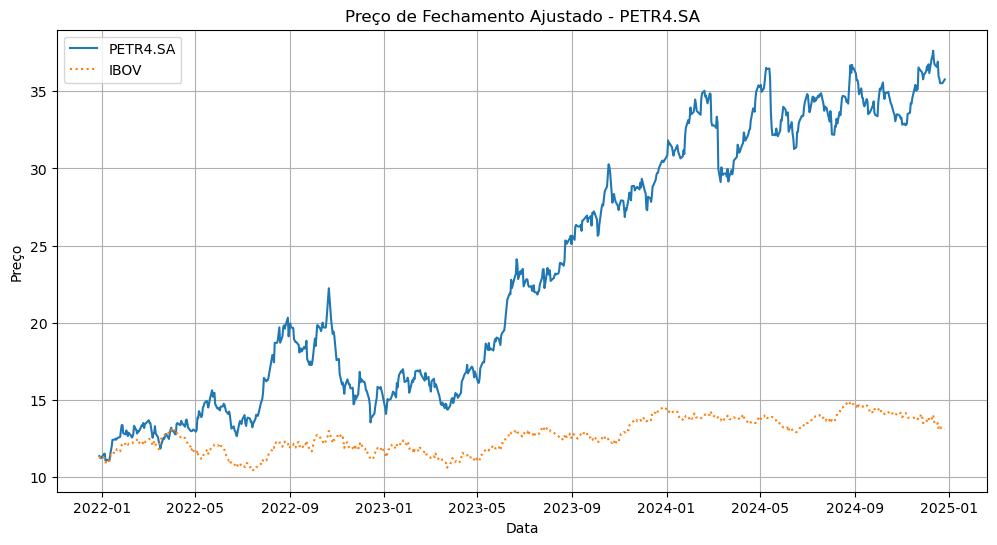

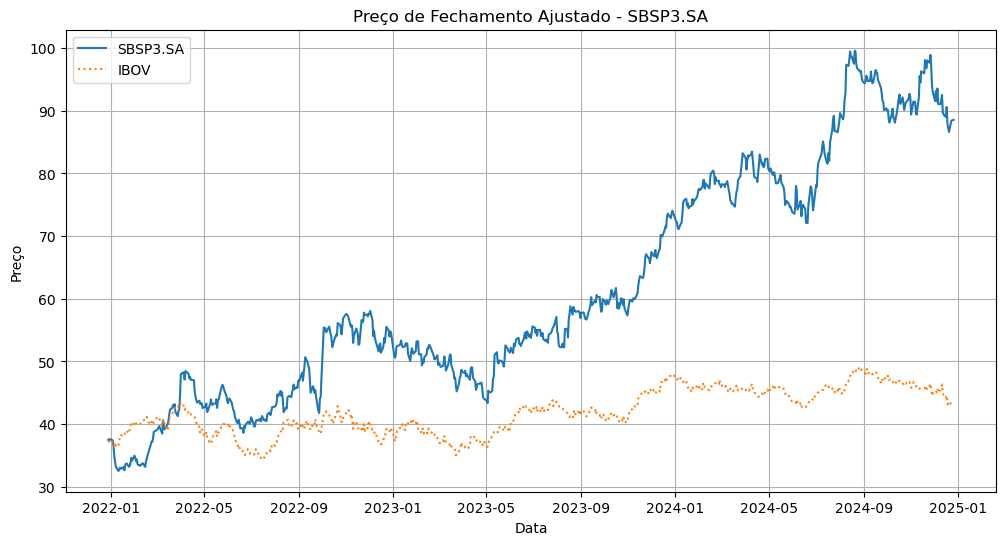

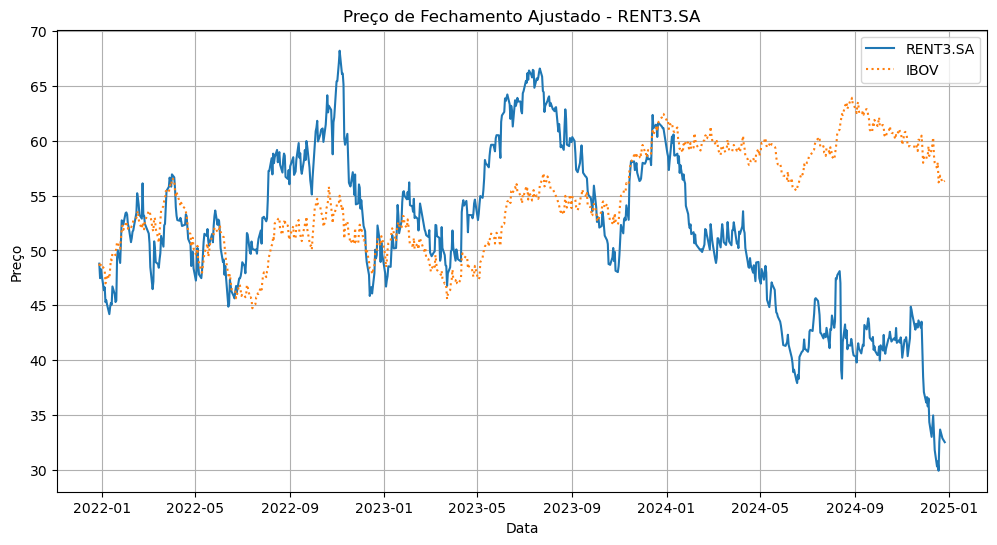

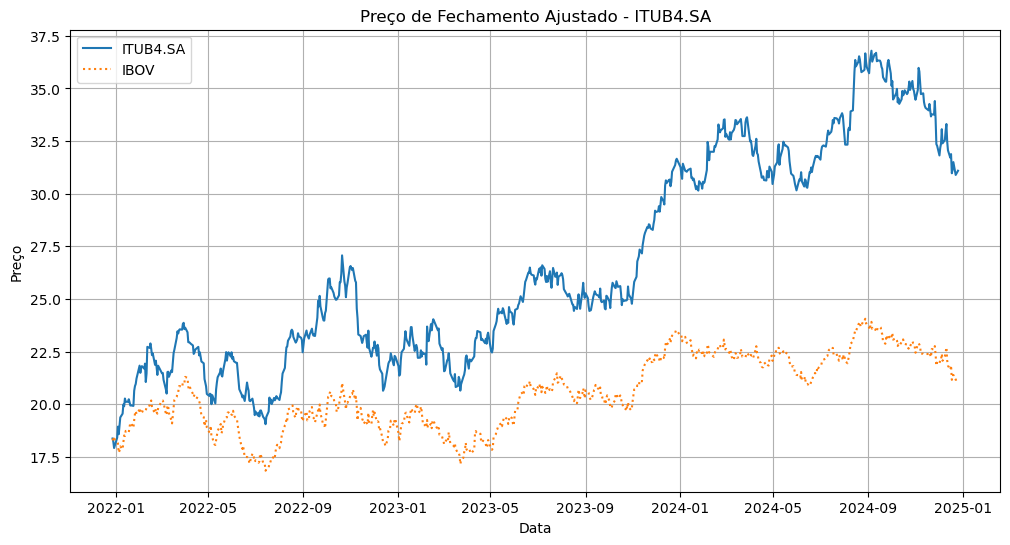

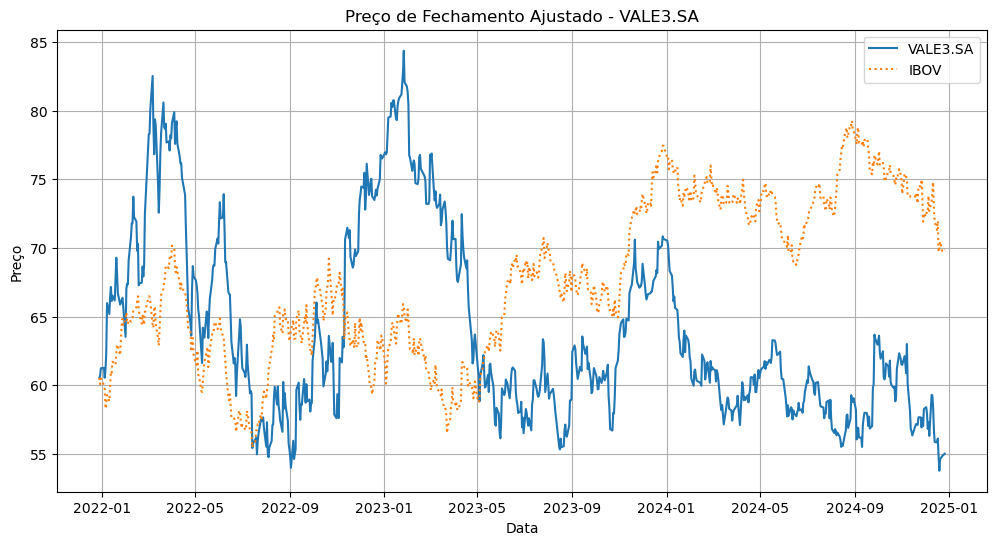

In [1694]:
# Plotar os preços de fechamento ajustados de cada ativo
for ticker in portfolio:
    plt.figure(figsize=(12, 6))
    plt.plot(df_adj.index, df_adj[ticker], label=ticker)

    # Adicionar benchmarks
    plt.plot(ibov.index, ibov['IBOV'] / ibov['IBOV'].iloc[0] * df_adj[ticker].iloc[0], label='IBOV', linestyle=':')

    plt.title('Preço de Fechamento Ajustado - {}'.format(ticker))
    plt.xlabel('Data')
    plt.ylabel('Preço')
    plt.legend()
    plt.grid(True)
    plt.show()


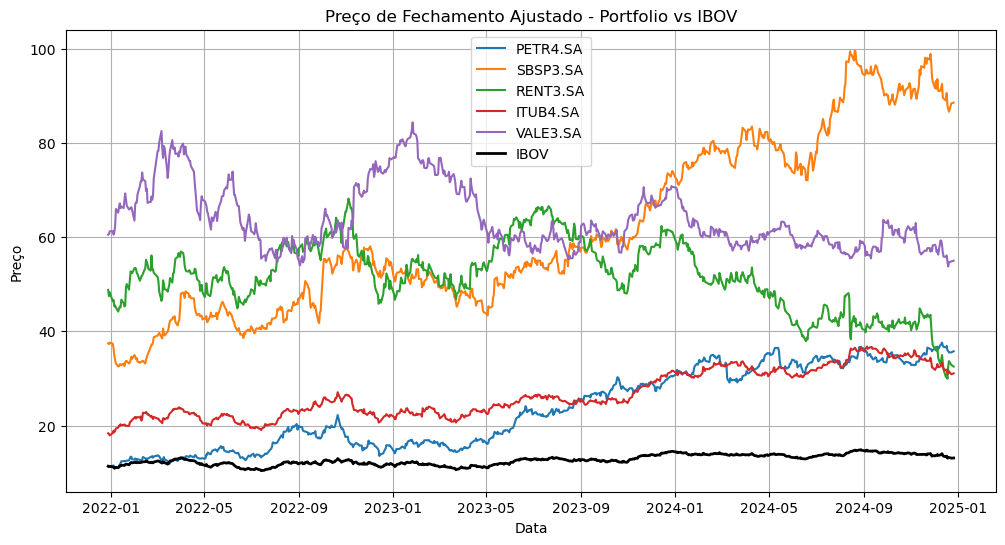

In [1695]:

# Plotar os preços de fechamento ajustados de cada ativo
plt.figure(figsize=(12, 6))

for ticker in portfolio:
    plt.plot(df_adj.index, df_adj[ticker], label=ticker)

# Adicionar o IBOV em destaque
plt.plot(ibov.index, ibov['IBOV'] / ibov['IBOV'].iloc[0] * df_adj[portfolio[0]].iloc[0], label='IBOV', linewidth=2, color='black')
plt.title('Preço de Fechamento Ajustado - Portfolio vs IBOV')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.grid(True)
plt.show()


### Retornos

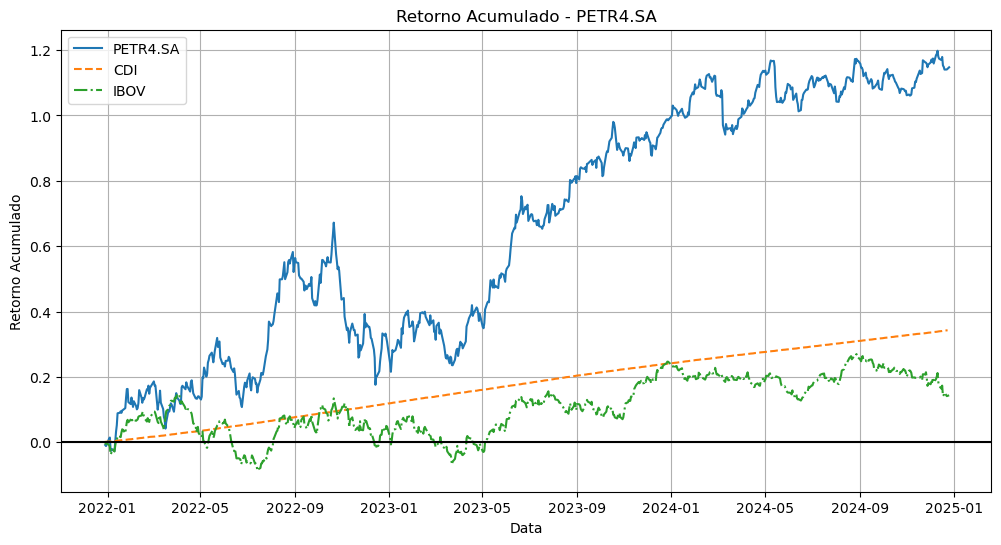

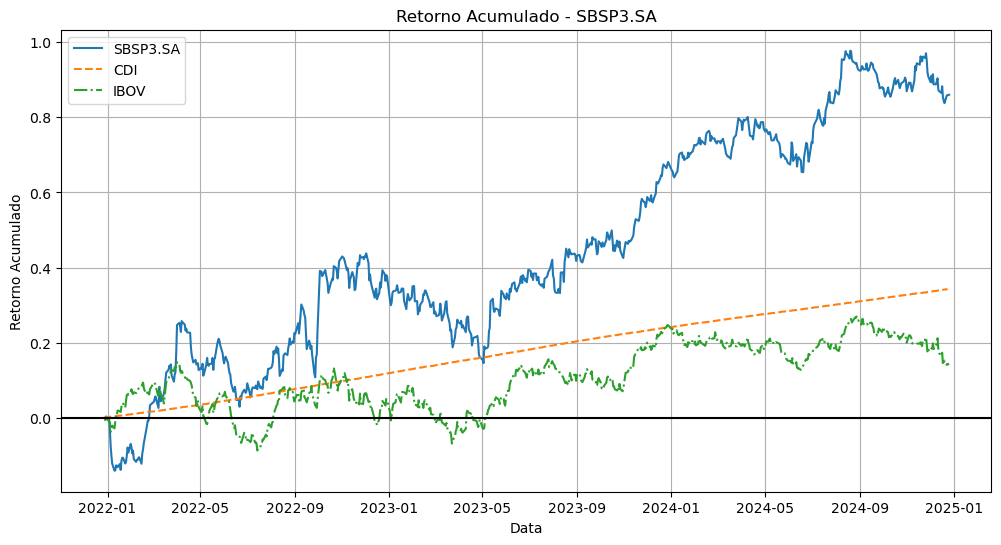

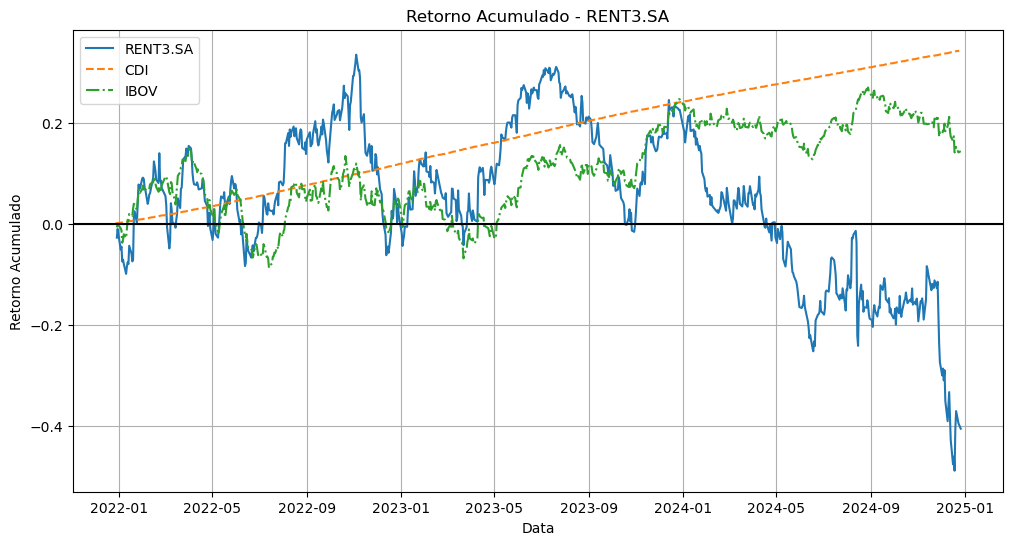

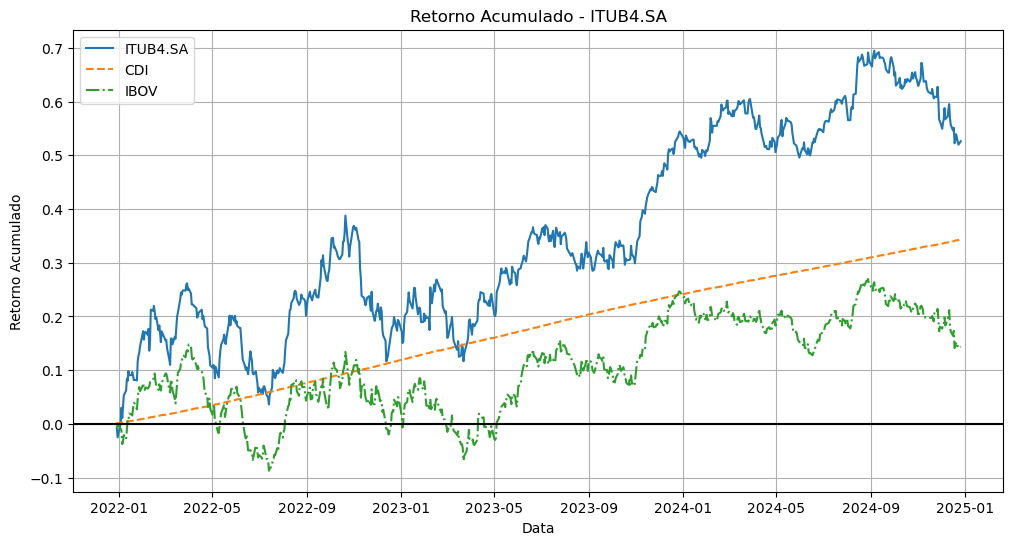

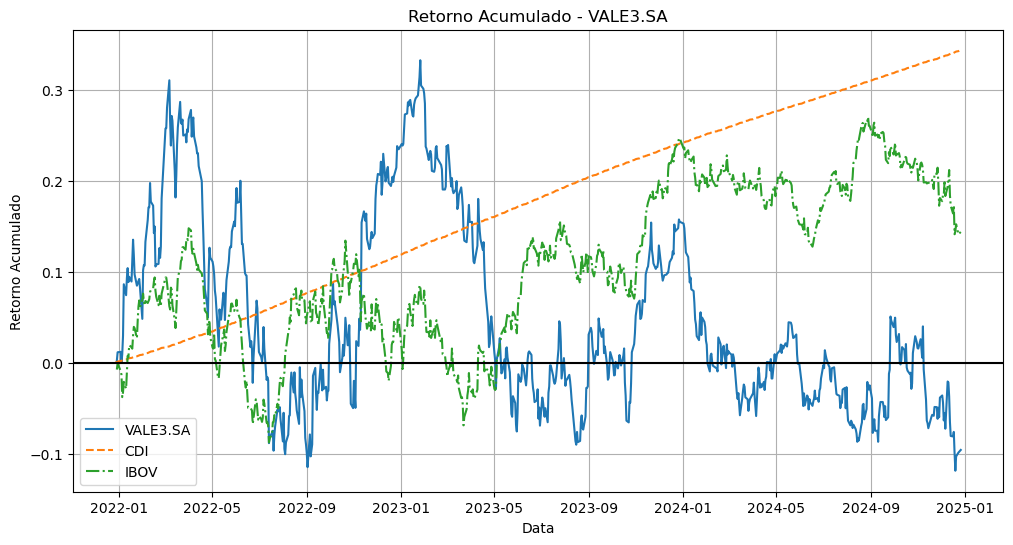

In [1696]:
# Plotar os retornos diários de cada ativo
for ticker in log_returns.columns:
    plt.figure(figsize=(12, 6))
    plt.plot(log_returns.index, log_returns[ticker].cumsum(), label=ticker)

    # Adicionar benchmarks
    plt.plot(cdi.index, cdi['cdi'].cumsum(), label='CDI', linestyle='--')
    plt.plot(log_ibov.index, log_ibov['IBOV'].cumsum(), label='IBOV', linestyle='-.')
    plt.axhline(0,color='k')


    plt.title('Retorno Acumulado - {}'.format(ticker))
    plt.xlabel('Data')
    plt.ylabel('Retorno Acumulado')
    plt.legend()
    plt.grid(True)
    plt.show()


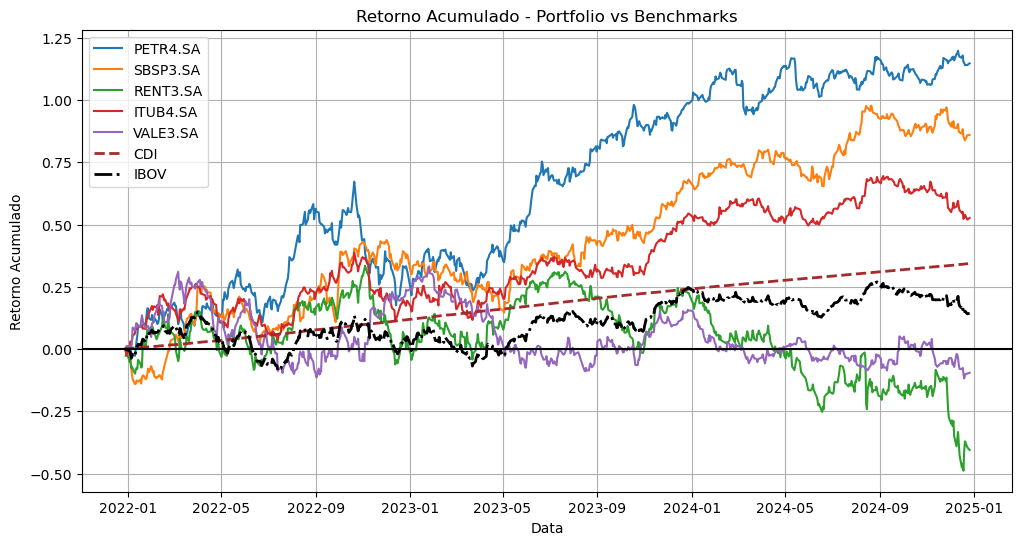

In [1697]:
# Plota grãfico unificado
plt.figure(figsize=(12, 6))

# Plotar os retornos diários de cada ativo
for ticker in log_returns.columns:
    plt.plot(log_returns.index, log_returns[ticker].cumsum(), label=ticker)

# Adicionar benchmarks em destaque
plt.plot(cdi.index, cdi['cdi'].cumsum(), label='CDI', linestyle='--', linewidth=2, color='brown')
plt.plot(log_ibov.index, log_ibov['IBOV'].cumsum(), label='IBOV', linestyle='-.', linewidth=2, color='black')
plt.axhline(0,color='k')


plt.title('Retorno Acumulado - Portfolio vs Benchmarks')
plt.xlabel('Data')
plt.ylabel('Retorno Acumulado')
plt.legend()
plt.grid(True)
plt.show()


### Análise Temporal dos Ativos


 ---------  RESULTADOS ---------- 

PETR4.SA




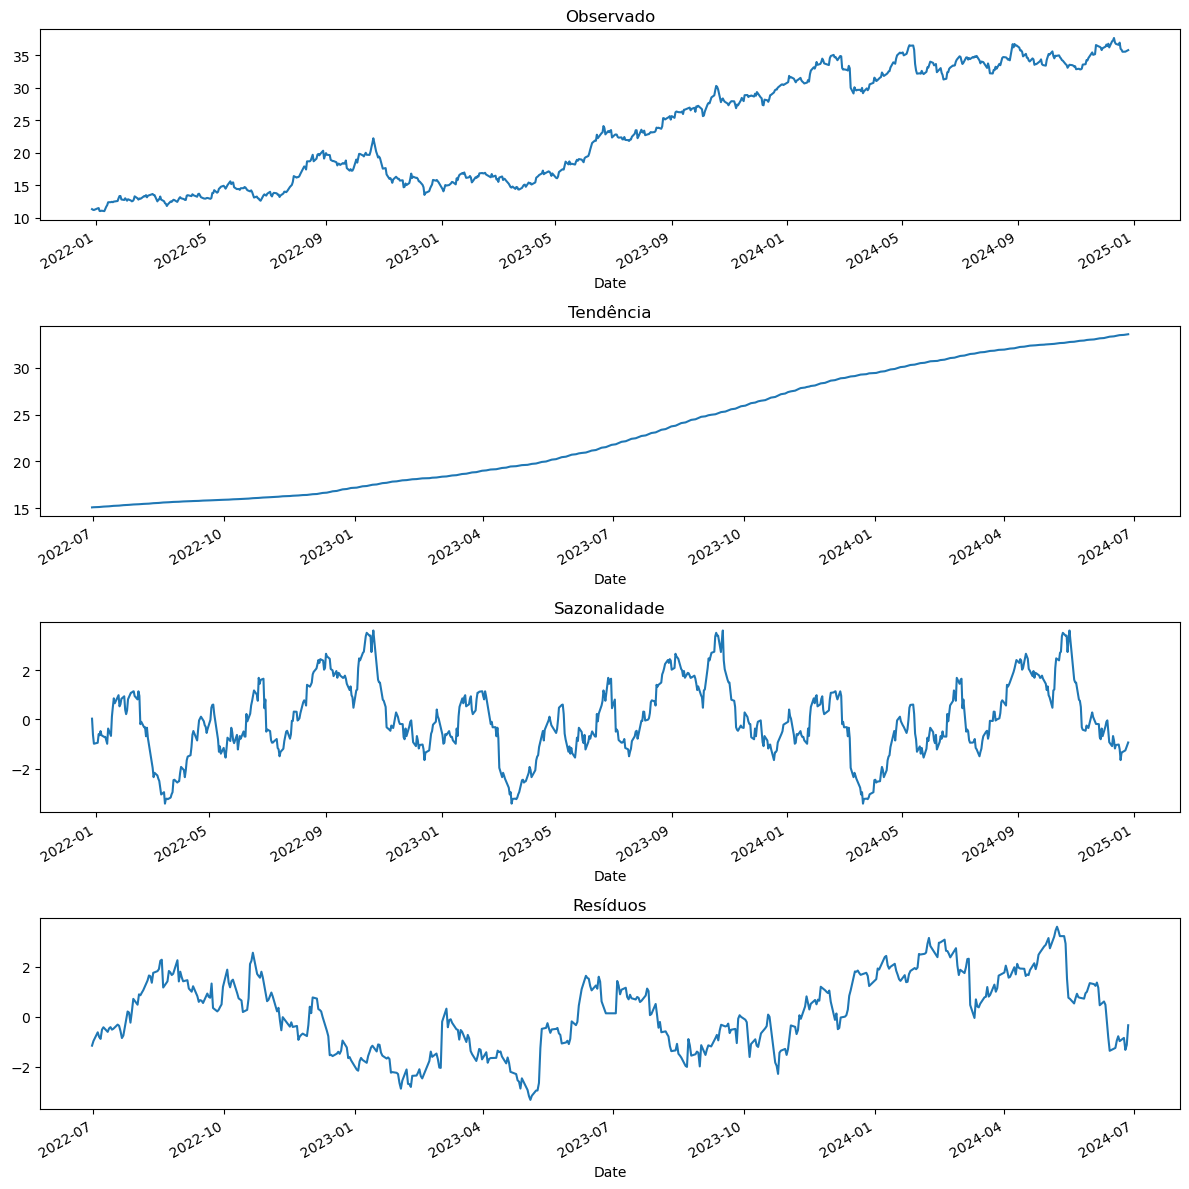


Teste de Shapiro-Wilk para PETR4.SA: Estatística=0.986, p-valor=0.000
Provavelmente não normal
Teste de Dickey-Fuller Aumentado para PETR4.SA:
ADF Statistic: -0.727890
p-value: 0.839393
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
Série provavelmente não estacionária



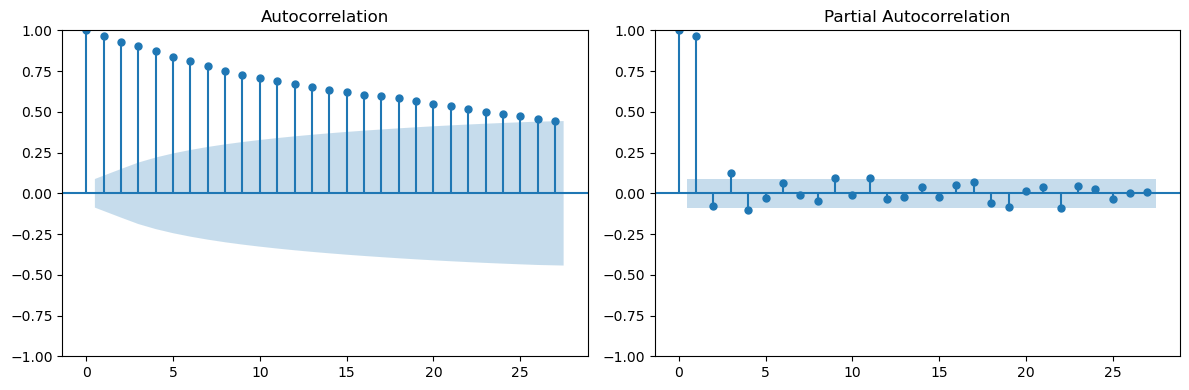


 ---------  RESULTADOS ---------- 

SBSP3.SA




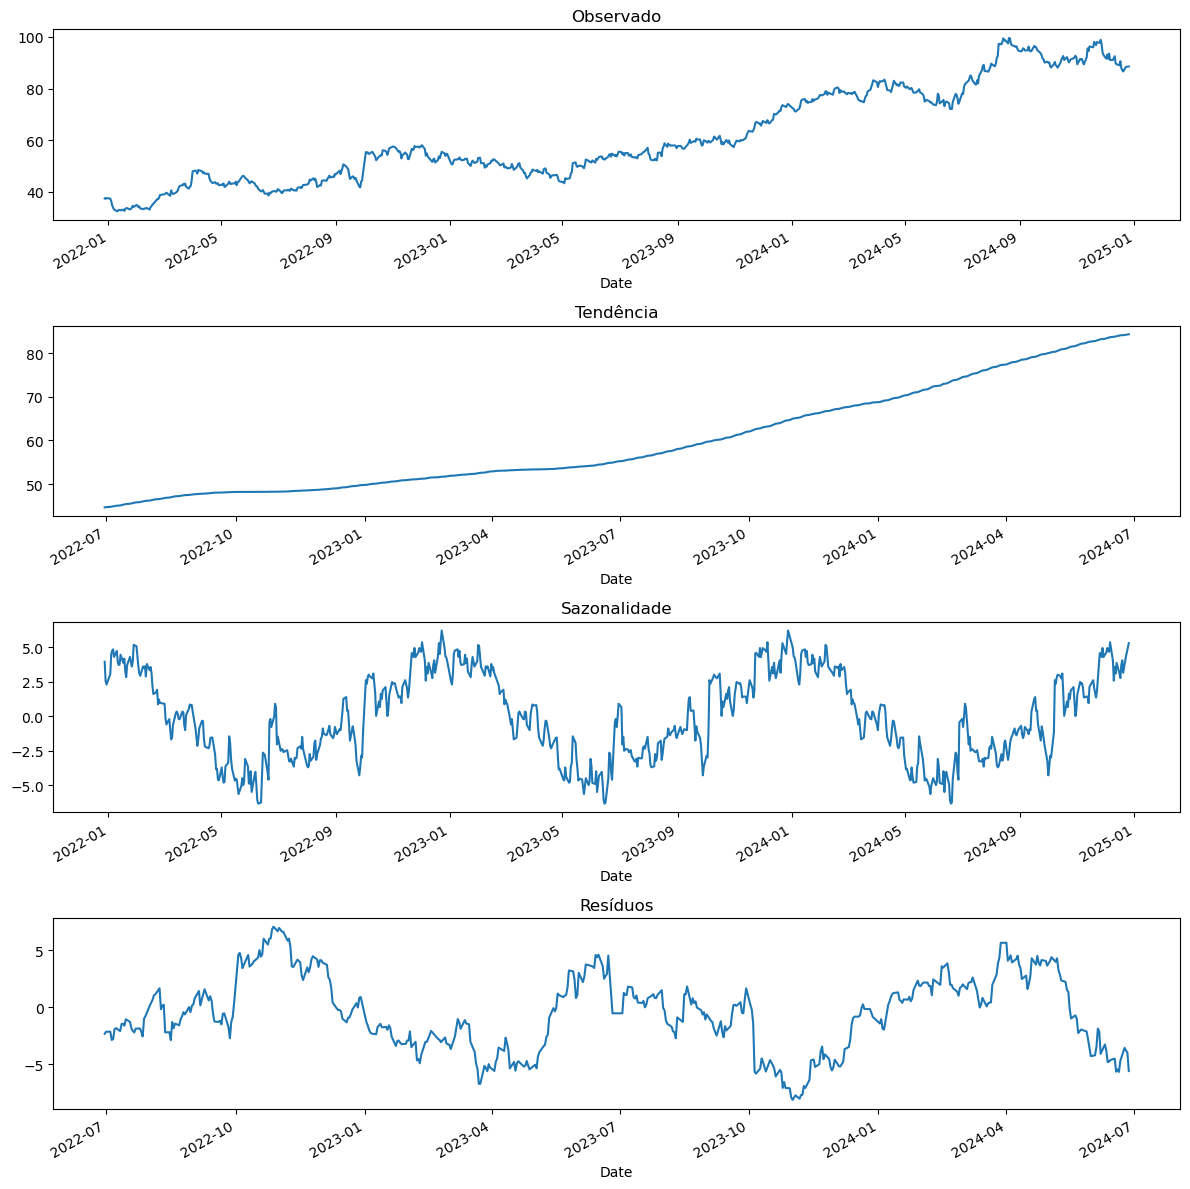


Teste de Shapiro-Wilk para SBSP3.SA: Estatística=0.990, p-valor=0.003
Provavelmente não normal
Teste de Dickey-Fuller Aumentado para SBSP3.SA:
ADF Statistic: -0.725344
p-value: 0.840075
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
Série provavelmente não estacionária



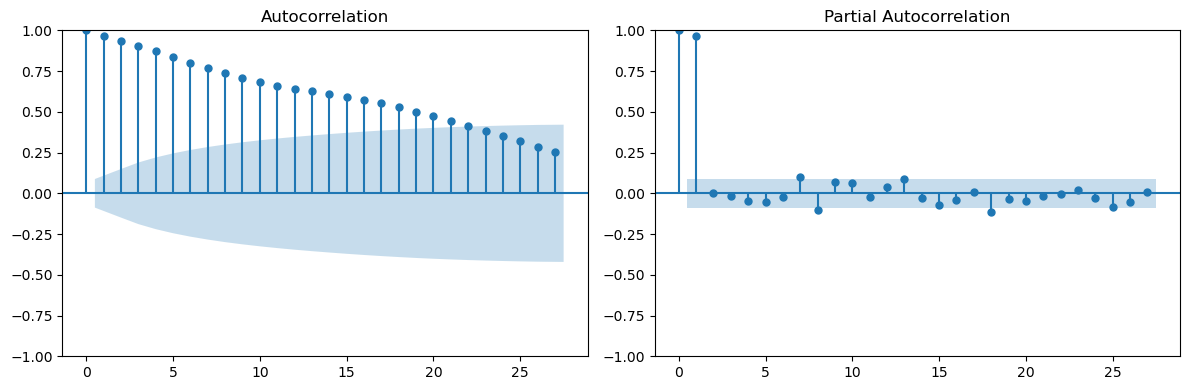


 ---------  RESULTADOS ---------- 

RENT3.SA




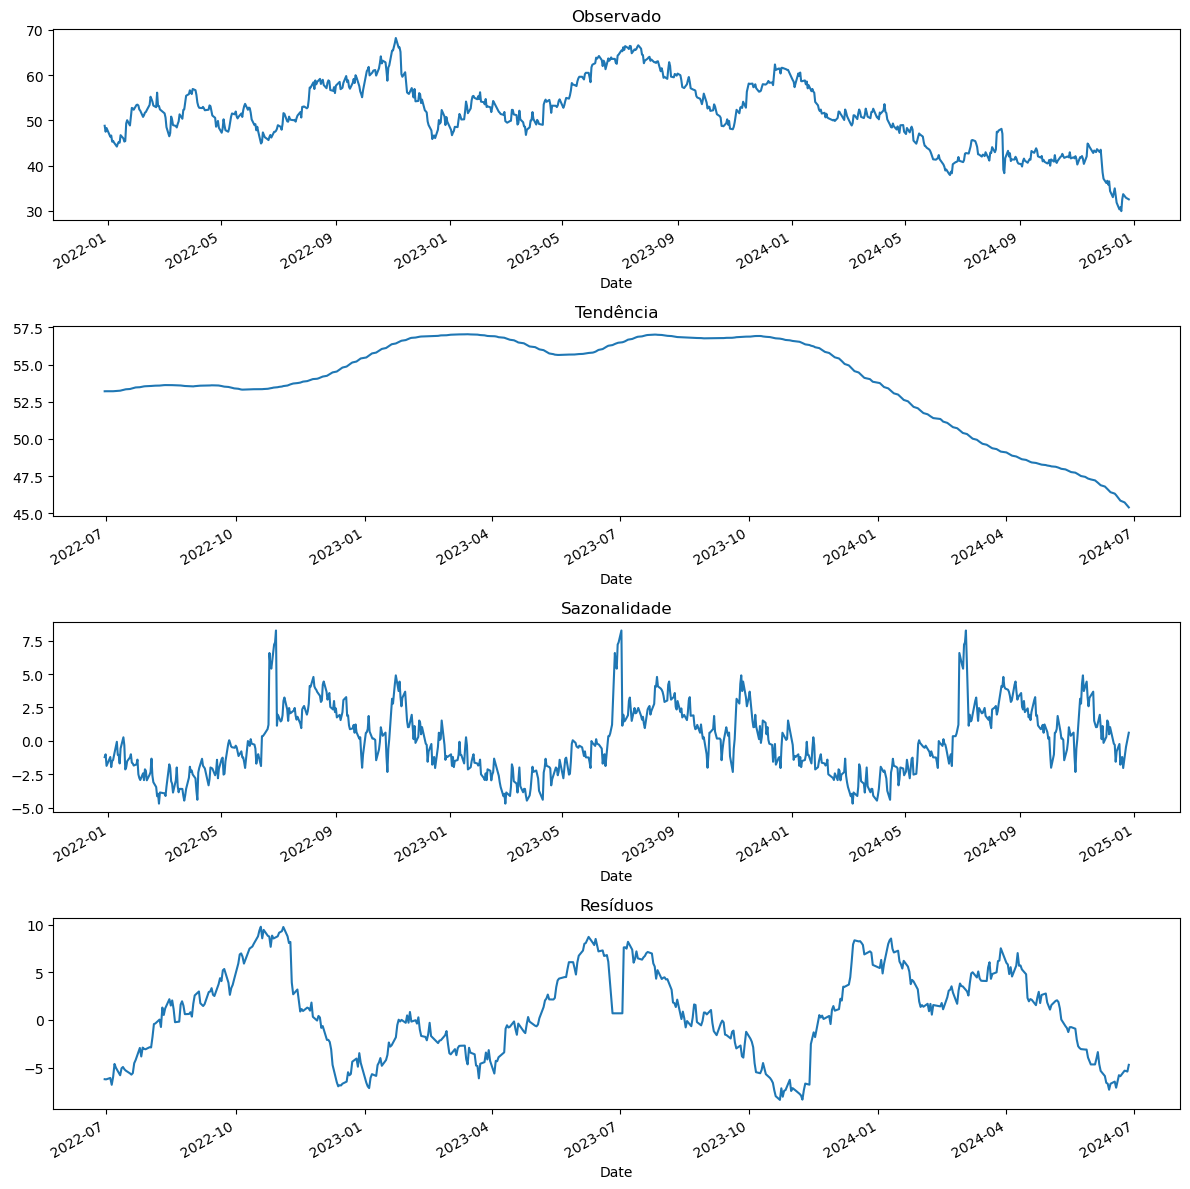


Teste de Shapiro-Wilk para RENT3.SA: Estatística=0.974, p-valor=0.000
Provavelmente não normal
Teste de Dickey-Fuller Aumentado para RENT3.SA:
ADF Statistic: -1.224633
p-value: 0.662911
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
Série provavelmente não estacionária



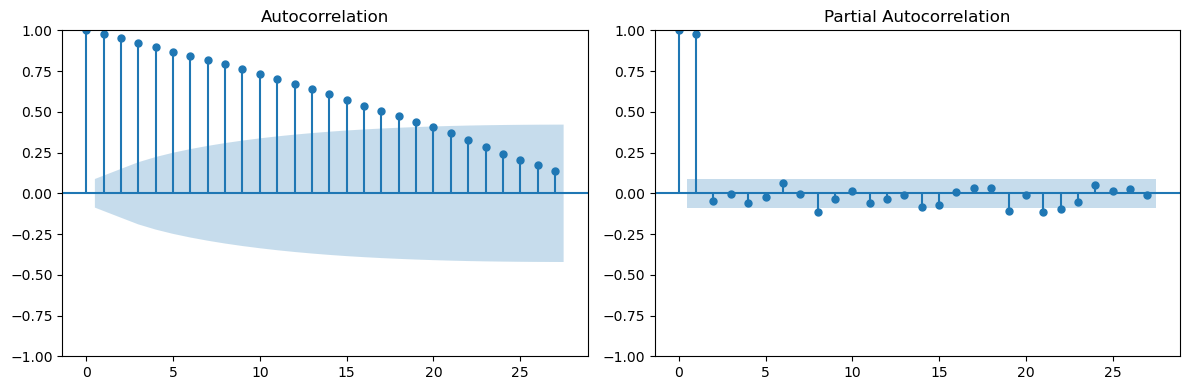


 ---------  RESULTADOS ---------- 

ITUB4.SA




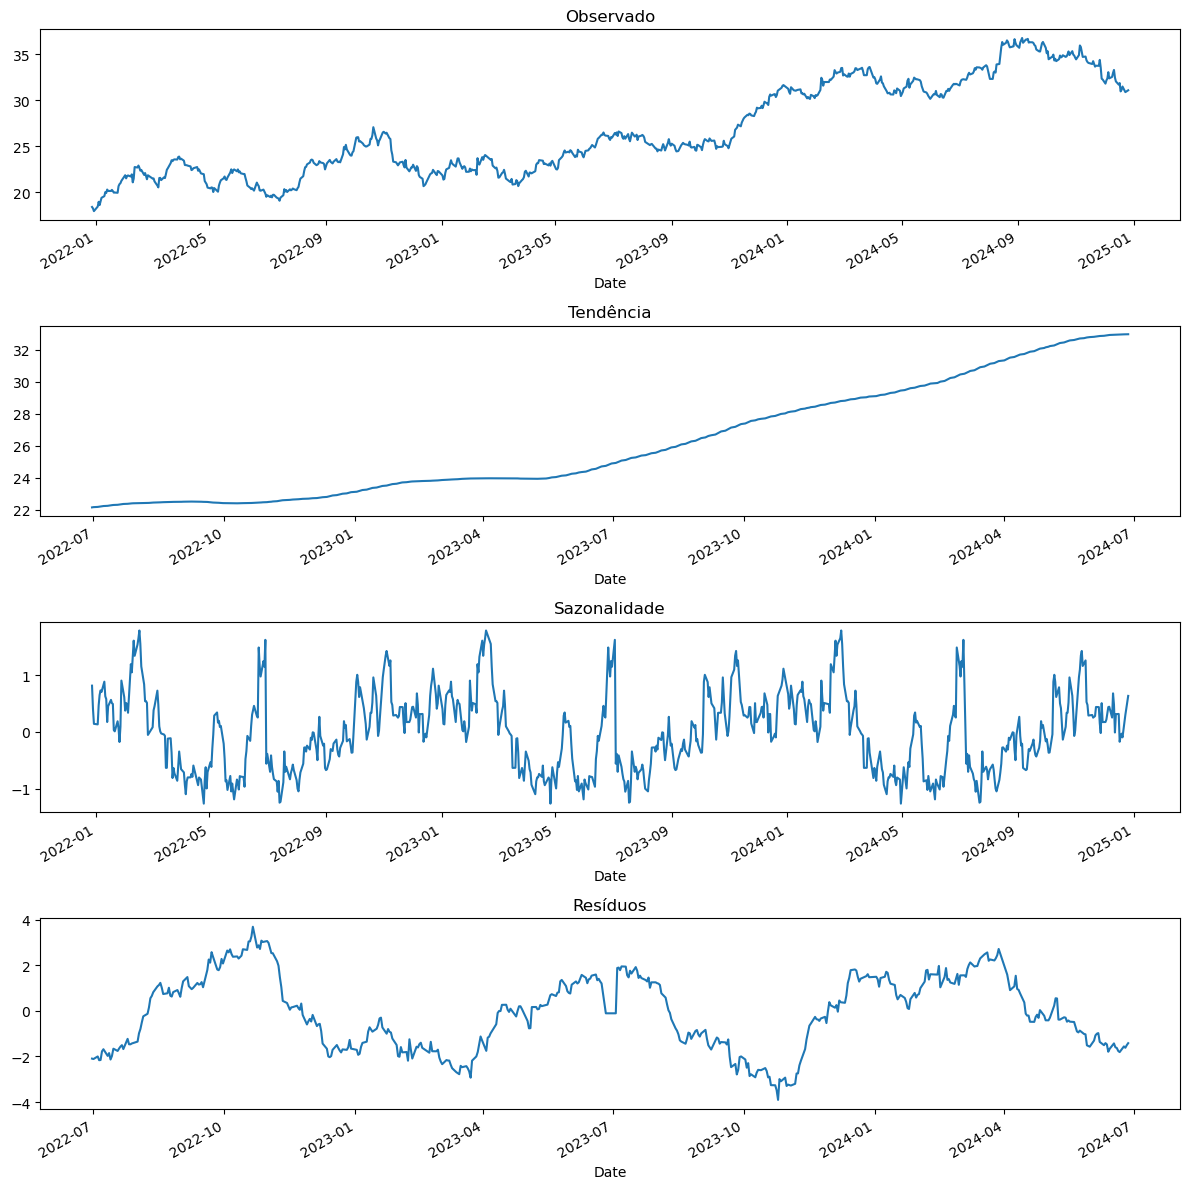


Teste de Shapiro-Wilk para ITUB4.SA: Estatística=0.978, p-valor=0.000
Provavelmente não normal
Teste de Dickey-Fuller Aumentado para ITUB4.SA:
ADF Statistic: -1.482946
p-value: 0.541930
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
Série provavelmente não estacionária



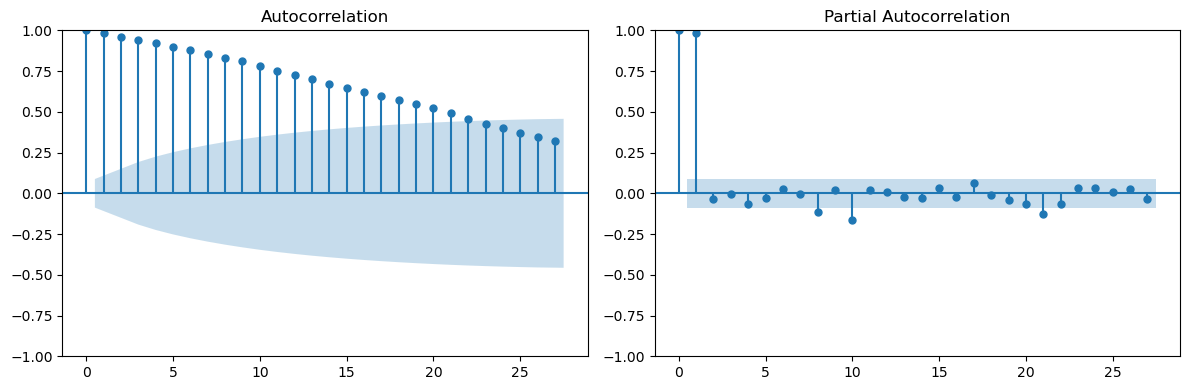


 ---------  RESULTADOS ---------- 

VALE3.SA




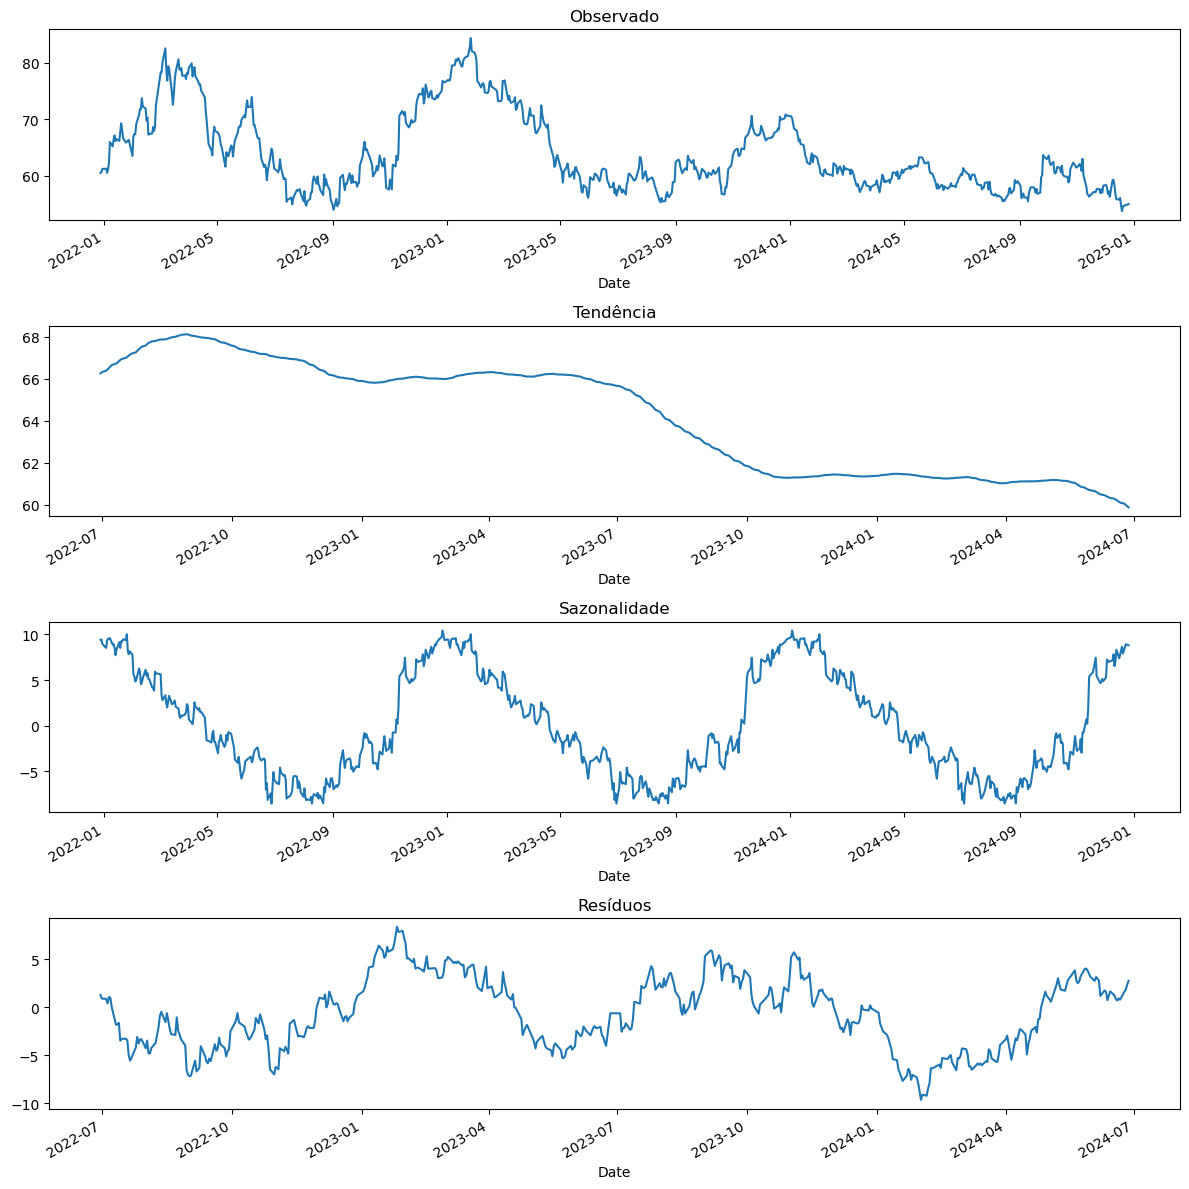


Teste de Shapiro-Wilk para VALE3.SA: Estatística=0.985, p-valor=0.000
Provavelmente não normal
Teste de Dickey-Fuller Aumentado para VALE3.SA:
ADF Statistic: -2.292872
p-value: 0.174277
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
Série provavelmente não estacionária



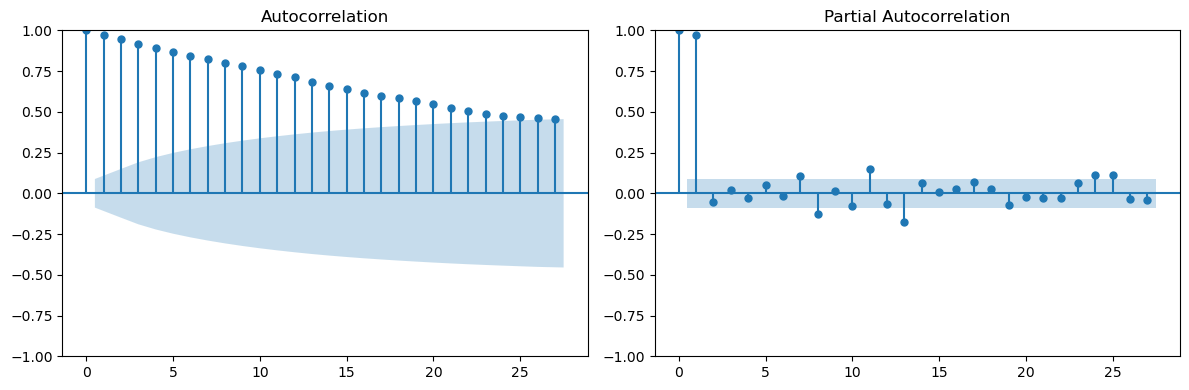

In [1698]:
# Análise de todos os tickers do Portfolio

for ticker in log_returns:

    print("\n ---------  RESULTADOS ---------- \n")
    print(f"{ticker}\n\n")
    # Decomposição da série temporal
    decomposition = seasonal_decompose(df_adj[ticker], model='additive', period=252)  # Considerando um ano com 252 dias úteis

    # Plotar a decomposição
    fig, axes = plt.subplots(4, 1, figsize=(12, 12))
    decomposition.observed.plot(ax=axes[0], title='Observado')
    decomposition.trend.plot(ax=axes[1], title='Tendência')
    decomposition.seasonal.plot(ax=axes[2], title='Sazonalidade')
    decomposition.resid.plot(ax=axes[3], title='Resíduos')
    plt.tight_layout()
    plt.show()

    # Teste de normalidade dos resíduos (Shapiro-Wilk)
    from scipy.stats import shapiro
    statistic, p_value = shapiro(decomposition.resid.dropna())
    print(f'\nTeste de Shapiro-Wilk para {ticker}: Estatística={statistic:.3f}, p-valor={p_value:.3f}')
    if p_value > 0.05:
        print('Provavelmente normal')
    else:
        print('Provavelmente não normal')

    # Teste de estacionariedade (Dickey-Fuller Aumentado)
    result = adfuller(df_adj[ticker])
    print(f'Teste de Dickey-Fuller Aumentado para {ticker}:')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] <= 0.05:
        print('Série provavelmente estacionária\n')
    else:
        print('Série provavelmente não estacionária\n')

    # Autocorrelação e Autocorrelação Parcial dos resíduos
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(decomposition.resid.dropna(), ax=axes[0])
    plot_pacf(decomposition.resid.dropna(), ax=axes[1])
    plt.tight_layout()
    plt.show()


### Calculo da Matriz de Covariância

In [1699]:
# Calculo da matriz de covariância usando os retornos

cov_matrix = log_returns.cov()*252 # anualizando os dados
print(cov_matrix) # Fazer um gráfico bonitinho disso


          PETR4.SA  SBSP3.SA  RENT3.SA  ITUB4.SA  VALE3.SA
PETR4.SA  0.112933  0.020214  0.021029  0.020938  0.022387
SBSP3.SA  0.020214  0.086143  0.043596  0.022550  0.008943
RENT3.SA  0.021029  0.043596  0.139612  0.037540  0.010981
ITUB4.SA  0.020938  0.022550  0.037540  0.052941  0.012592
VALE3.SA  0.022387  0.008943  0.010981  0.012592  0.090804


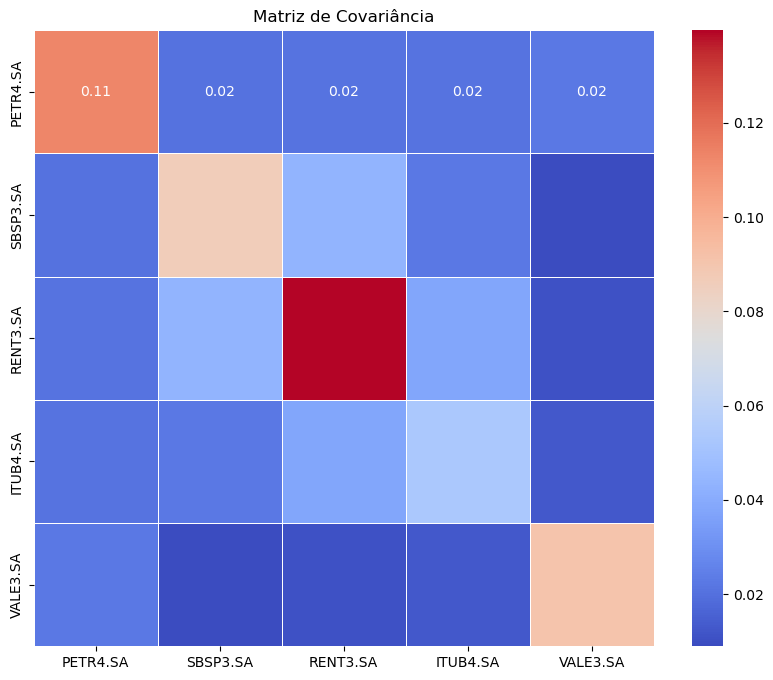

In [1700]:
# Cria um mapa de calor (heatmap) para visualizar a matriz de covariância
plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Covariância')
plt.show()




# 6 - Modelagem e Previsão

## 6.1 Análise do Portfolio

### Encontrar o X-Day dos Retornos Históricos do Portfolio

In [1701]:
# Especificar um intervalo de confiança
confidence_interval = 0.95
test_windows = [30, 60, 90, 180, 252]  # Diferentes janelas de dias


### Calcular o VaR (Value at Risk)


VaR para janela de 30 dias: R$ 8564.20


VaR para janela de 60 dias: R$ 9009.10


VaR para janela de 90 dias: R$ 7769.46


VaR para janela de 180 dias: R$ 846.81


VaR para janela de 252 dias: R$ -540.24


Resultados do VaR para diferentes janelas de tempo:

Janela de 30 dias: VaR = R$ 8564.20
Janela de 60 dias: VaR = R$ 9009.10
Janela de 90 dias: VaR = R$ 7769.46
Janela de 180 dias: VaR = R$ 846.81
Janela de 252 dias: VaR = R$ -540.24

Melhor janela de tempo: 252 dias com VaR = R$ -540.24



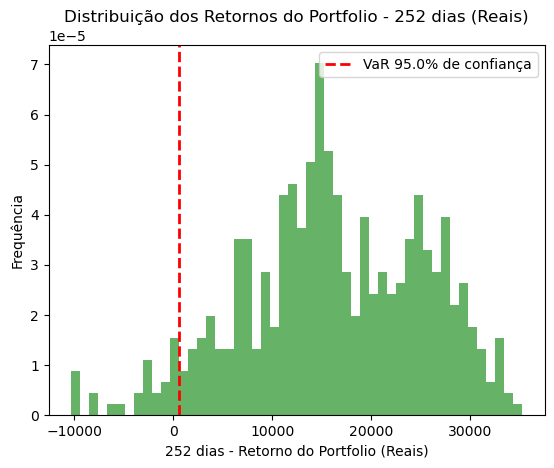

In [1702]:
# Lista para armazenar os resultados do VaR
test_windows_results = []

# Loop para calcular o VaR para cada janela de tempo
for window in test_windows:
    range_returns = historical_returns.rolling(window=window).sum().dropna()

    if range_returns.empty:
        print(f'Janela de {window} dias sem dados suficientes.')
        continue

    VaR = -np.percentile(range_returns, 100 - (confidence_interval * 100)) * portfolio_value
    test_windows_results.append((window, VaR))
    print(f'\nVaR para janela de {window} dias: R$ {VaR:.2f}\n')

# Mostrar todos os resultados armazenados em test_windows_results
print("\nResultados do VaR para diferentes janelas de tempo:\n")
for window, var in test_windows_results:
    print(f"Janela de {window} dias: VaR = R$ {var:.2f}")

# Encontrar o melhor valor de VaR (o menor, pois ele representa a perda máxima)
best_window, best_VaR = min(test_windows_results, key=lambda x: x[1])
print(f'\nMelhor janela de tempo: {best_window} dias com VaR = R$ {best_VaR:.2f}\n')

# Plotar o gráfico da distribuição dos retornos do portfólio com a melhor janela
range_returns_best = historical_returns.rolling(window=best_window).sum().dropna()
plt.hist(range_returns_best * portfolio_value, bins=50, density=True, alpha=0.6, color='g')
plt.axvline(-best_VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR {confidence_interval*100}% de confiança')
plt.xlabel(f'{best_window} dias - Retorno do Portfolio (Reais)')
plt.ylabel('Frequência')
plt.title(f'Distribuição dos Retornos do Portfolio - {best_window} dias (Reais)')
plt.legend()
plt.show()

### Backtesting

In [1703]:
# Escolha a melhor janela com base na análise anterior
# Por exemplo, se a janela de 180 dias for a escolhida

backtesting_days = best_window  # Período de backtesting (1 ano)
violacoes = []

for i in range(backtesting_days, len(historical_returns)):
    # Calcular o VaR com os dados anteriores ao dia i
    janela_treino = historical_returns[i-backtesting_days:i]
    range_returns = janela_treino.rolling(window=best_window).sum().dropna()

    if range_returns.empty:
        print(f'Janela de {best_window} dias sem dados suficientes no índice {i}.')
        continue  # Pula a iteração se range_returns estiver vazio

    VaR = -np.percentile(range_returns, 100 - (confidence_interval * 100)) * portfolio_value

    # Comparar com o retorno real
    retorno_real = historical_returns.iloc[i] * portfolio_value
    if retorno_real < -VaR:
        violacoes.append(1)
    else:
        violacoes.append(0)

# Imprimir a taxa de violação observada
taxa_violacao = np.mean(violacoes)
print(f'Taxa de Violação Observada: {taxa_violacao:.4f}')

Taxa de Violação Observada: 0.9518


### Stress Test


VaR em cenário de stress (choque de 50.0%): R$ -270.12




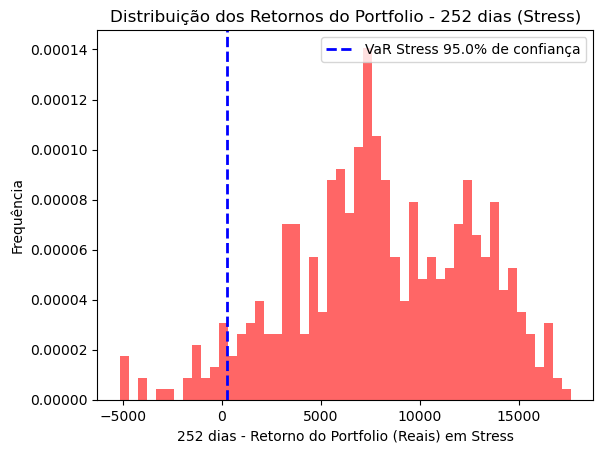

In [1704]:
# Parâmetros do Stress Test
shock_factor = 0.5  # Aplicando um choque de 50% nos retornos (simula uma queda acentuada)

# Simular cenário de stress aplicando um choque negativo nos retornos
stress_scenario_returns = historical_returns.copy()
stress_scenario_returns *= np.random.uniform(1 - shock_factor, 1 - shock_factor, size=len(stress_scenario_returns))

# Calcular os retornos acumulados no cenário de stress
range_returns_stress = stress_scenario_returns.rolling(window=best_window).sum().dropna()

# Calcular o VaR no cenário de stress
VaR_stress = -np.percentile(range_returns_stress, 100 - (confidence_interval * 100)) * portfolio_value

# Exibir o resultado do VaR em cenário de stress
print(f'\nVaR em cenário de stress (choque de {shock_factor*100}%): R$ {VaR_stress:.2f}\n\n')

# Visualizar a distribuição dos retornos no cenário de stress
plt.hist(range_returns_stress * portfolio_value, bins=50, density=True, alpha=0.6, color='r')
plt.axvline(-VaR_stress, color='b', linestyle='dashed', linewidth=2, label=f'VaR Stress {confidence_interval*100}% de confiança')
plt.xlabel(f'{best_window} dias - Retorno do Portfolio (Reais) em Stress')
plt.ylabel('Frequência')
plt.title(f'Distribuição dos Retornos do Portfolio - {best_window} dias (Stress)')
plt.legend()
plt.show()

### Análise dos Retornos do Portfolio Escolhido



Saldo atual do Portfolio: R$ 140650.63
Saldo atual do CDI: R$ 134261.80
Saldo atual do IBOV: R$ 114376.66


Diferença Portfolio vs. CDI: R$ 6388.83
Diferença Portfolio vs. IBOV: R$ 26273.97



C:\Users\jeand\AppData\Local\Temp\ipykernel_37080\2424190984.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  saldo_atual_portfolio = portfolio_return[-1]
C:\Users\jeand\AppData\Local\Temp\ipykernel_37080\2424190984.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  saldo_atual_cdi = cdi_return[-1]
C:\Users\jeand\AppData\Local\Temp\ipykernel_37080\2424190984.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  saldo_atual_ibov

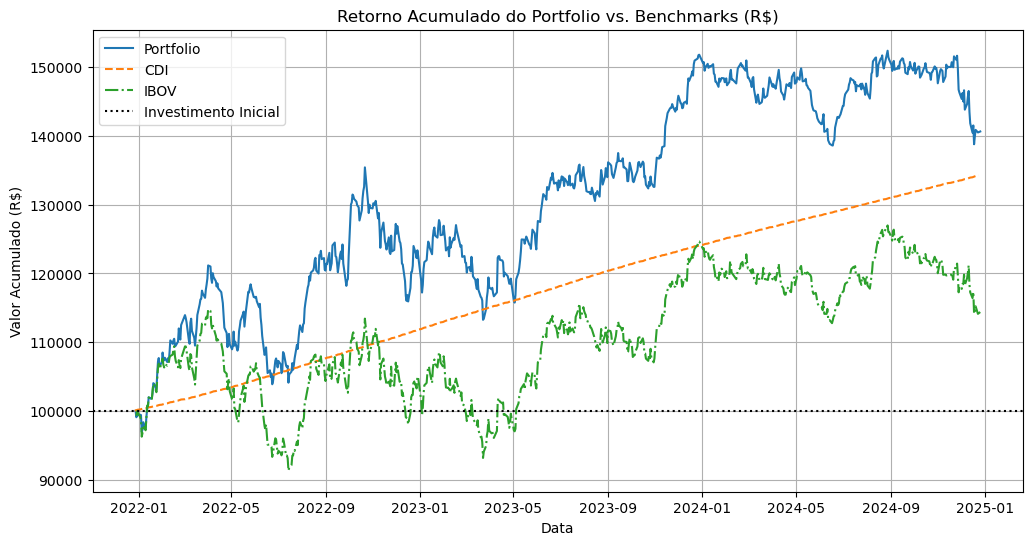

In [1705]:
# Calcula o retorno acumulado do portfolio
portfolio_return = (historical_returns.cumsum() + 1) * portfolio_value

# Calcula o retorno acumulado do CDI
cdi_return = (cdi['cdi'].cumsum() + 1) * portfolio_value

# Calcula o retorno acumulado do IBOV
ibov_return = (log_ibov['IBOV'].cumsum() + 1) * portfolio_value

# Obter os saldos atuais
saldo_atual_portfolio = portfolio_return[-1]
saldo_atual_cdi = cdi_return[-1]
saldo_atual_ibov = ibov_return[-1]

# Calcular as diferenças
diferenca_cdi = saldo_atual_portfolio - saldo_atual_cdi
diferenca_ibov = saldo_atual_portfolio - saldo_atual_ibov

# Imprimir os resultados
print('\n')
print(f"Saldo atual do Portfolio: R$ {saldo_atual_portfolio:.2f}")
print(f"Saldo atual do CDI: R$ {saldo_atual_cdi:.2f}")
print(f"Saldo atual do IBOV: R$ {saldo_atual_ibov:.2f}\n")
print(f"\nDiferença Portfolio vs. CDI: R$ {diferenca_cdi:.2f}")
print(f"Diferença Portfolio vs. IBOV: R$ {diferenca_ibov:.2f}\n")

# Plota os retornos acumulados
plt.figure(figsize=(12, 6))
plt.plot(historical_returns.index, portfolio_return, label='Portfolio')
plt.plot(cdi.index, cdi_return, label='CDI', linestyle='--')
plt.plot(log_ibov.index, ibov_return, label='IBOV', linestyle='-.')
plt.axhline(portfolio_value, color='k', linestyle=':', label='Investimento Inicial')
plt.title('Retorno Acumulado do Portfolio vs. Benchmarks (R$)')
plt.xlabel('Data')
plt.ylabel('Valor Acumulado (R$)')
plt.legend()
plt.grid(True)
plt.show()


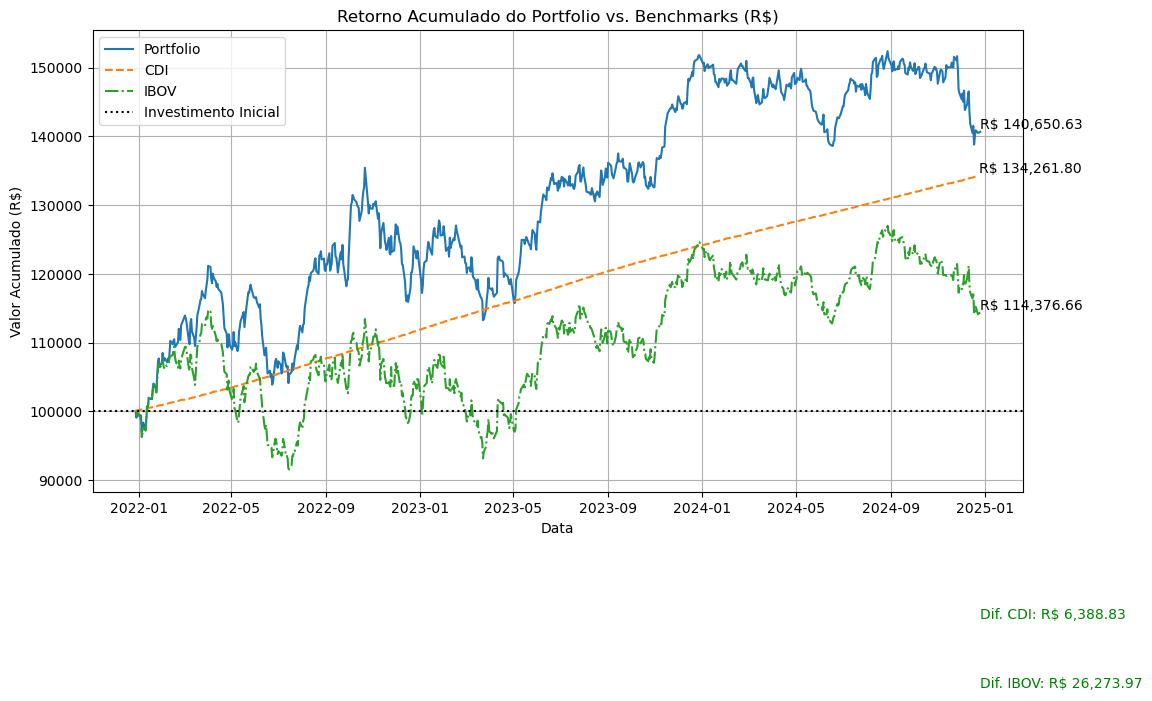

In [1706]:
# Calcula o retorno acumulado do portfolio
portfolio_return = (historical_returns.cumsum() + 1) * portfolio_value

# Calcula o retorno acumulado do CDI
cdi_return = (cdi['cdi'].cumsum() + 1) * portfolio_value

# Calcula o retorno acumulado do IBOV
ibov_return = (log_ibov['IBOV'].cumsum() + 1) * portfolio_value

# Plota os retornos acumulados
plt.figure(figsize=(12, 6))
plt.plot(historical_returns.index, portfolio_return, label='Portfolio')
plt.plot(cdi.index, cdi_return, label='CDI', linestyle='--')
plt.plot(log_ibov.index, ibov_return, label='IBOV', linestyle='-.')
plt.axhline(portfolio_value, color='k', linestyle=':', label='Investimento Inicial')
plt.title('Retorno Acumulado do Portfolio vs. Benchmarks (R$)')
plt.xlabel('Data')
plt.ylabel('Valor Acumulado (R$)')
plt.legend()
plt.grid(True)

# Calcula os valores finais
final_portfolio = portfolio_return.iloc[-1]
final_cdi = cdi_return.iloc[-1]
final_ibov = ibov_return.iloc[-1]

# Calcula as diferenças
diff_cdi = final_portfolio - final_cdi
diff_ibov = final_portfolio - final_ibov

# Adiciona os valores e diferenças no gráfico
plt.text(historical_returns.index[-1], final_portfolio, f'R$ {final_portfolio:,.2f}', ha='left', va='bottom')
plt.text(cdi.index[-1], final_cdi, f'R$ {final_cdi:,.2f}', ha='left', va='bottom')
plt.text(log_ibov.index[-1], final_ibov, f'R$ {final_ibov:,.2f}', ha='left', va='bottom')

plt.text(historical_returns.index[-1], final_portfolio/2, f'Dif. CDI: R$ {diff_cdi:,.2f}', ha='left', va='center', color='green' if diff_cdi > 0 else 'red')
plt.text(historical_returns.index[-1], final_portfolio/2 - 10000, f'Dif. IBOV: R$ {diff_ibov:,.2f}', ha='left', va='center', color='green' if diff_ibov > 0 else 'red')

plt.show()


In [1707]:
# Calcula as métricas para o portfolio
portfolio_mean_return = historical_returns.mean() * best_window  # Retorno médio anualizado
portfolio_std_dev = historical_returns.std() * np.sqrt(best_window)  # Desvio padrão anualizado
portfolio_sharpe_ratio = (portfolio_mean_return - risk_free_rate) / portfolio_std_dev  # Sharpe Ratio

# Calcula as métricas para o CDI
cdi_mean_return = cdi['cdi'].mean() * best_window
cdi_std_dev = cdi['cdi'].std() * np.sqrt(best_window)
cdi_sharpe_ratio = (cdi_mean_return - risk_free_rate) / cdi_std_dev  # Sharpe Ratio para o CDI (próximo de zero)

# Calcula as métricas para o IBOV
ibov_mean_return = log_ibov['IBOV'].mean() * best_window
ibov_std_dev = log_ibov['IBOV'].std() * np.sqrt(best_window)
ibov_sharpe_ratio = (ibov_mean_return - risk_free_rate) / ibov_std_dev

# Cria um DataFrame para exibir as métricas
metrics_df = pd.DataFrame({
    'Métrica': ['Retorno Médio Anualizado', 'Desvio Padrão Anualizado', 'Sharpe Ratio'],
    'Portfolio': [portfolio_mean_return, portfolio_std_dev, portfolio_sharpe_ratio],
    'CDI': [cdi_mean_return, cdi_std_dev, cdi_sharpe_ratio],
    'IBOV': [ibov_mean_return, ibov_std_dev, ibov_sharpe_ratio]
})

# Exibe o DataFrame
print(metrics_df.to_string(index=False))


                 Métrica  Portfolio        CDI     IBOV
Retorno Médio Anualizado   0.136586   0.114509 0.048370
Desvio Padrão Anualizado   0.192119   0.000788 0.173979
            Sharpe Ratio   0.708577 144.766572 0.275406


## 6.2 Previsão do Portfolio

### Portfolio - CAPM

In [1708]:
# Apaga primeira linha de historical_returns

historical_returns = historical_returns.iloc[1:]
historical_returns


Date
2021-12-29   -0.009281
2021-12-30    0.002959
2022-01-03    0.000723
2022-01-04   -0.000473
2022-01-05   -0.024498
                ...   
2024-12-18   -0.027317
2024-12-19    0.011619
2024-12-20    0.009274
2024-12-23   -0.003756
2024-12-26    0.001431
Name: returns, Length: 749, dtype: float64

In [1709]:
# Calcula o retorno médio do portfolio
portfolio_mean_return = historical_returns.mean() * best_window

# Calcula o retorno médio do IBOV
ibov_mean_return = log_ibov['IBOV'].mean() * best_window

# Calcula a covariância entre o portfolio e o IBOV
cov_portfolio_ibov = historical_returns.cov(log_ibov['IBOV']) * best_window

# Calcula a variância do IBOV
var_ibov = log_ibov['IBOV'].var() * best_window

# Calcula o beta do portfolio
beta_portfolio = cov_portfolio_ibov / var_ibov

# Calcula o retorno esperado do portfolio usando o CAPM
expected_return_capm = risk_free_rate + beta_portfolio * (ibov_mean_return - risk_free_rate)

# Calcula o alfa do portfolio
alpha_portfolio = portfolio_mean_return - expected_return_capm

# Imprime os resultados
print(f"Beta do Portfolio: {beta_portfolio:.4f}")
print(f"Retorno Esperado (CAPM): {expected_return_capm:.4f}")
print(f"Alfa do Portfolio: {alpha_portfolio:.4f}")


Beta do Portfolio: 1.0140
Retorno Esperado (CAPM): 0.0490
Alfa do Portfolio: 0.0877


Erro de Previsão do CAPM: 0.0877
R-quadrado do Modelo CAPM: 0.8421

Interpretação dos Resultados:
- Beta do Portfolio (1.0140): Indica que o portfolio é 1.01 vezes mais volátil que o IBOV.
- Alfa do Portfolio (0.0877): Positivo, indicando que o portfolio gerou retornos acima do esperado pelo CAPM, sugerindo uma possível habilidade do gestor.
- R-quadrado do Modelo CAPM (0.8421): Indica que 84.21% da variância do retorno do portfolio é explicada pelo IBOV.


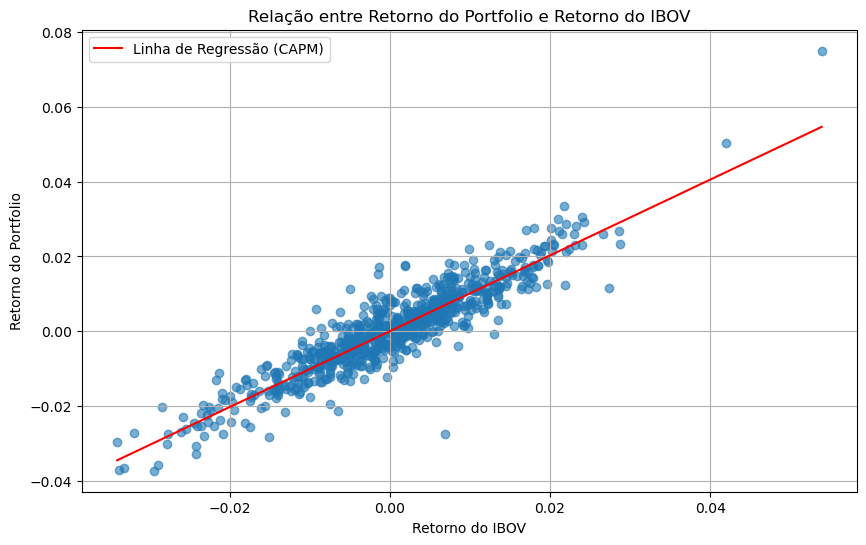

In [1710]:

# Calcula o erro de previsão do CAPM
capm_prediction_error = portfolio_mean_return - expected_return_capm

# Calcula o R-quadrado do modelo CAPM (quanto da variância do retorno do portfolio é explicada pelo IBOV)
r_squared = (cov_portfolio_ibov ** 2) / (var_ibov * historical_returns.var() * best_window)

# Imprime os resultados adicionais
print(f"Erro de Previsão do CAPM: {capm_prediction_error:.4f}")
print(f"R-quadrado do Modelo CAPM: {r_squared:.4f}")

# Interpretação dos resultados
print("\nInterpretação dos Resultados:")
print(f"- Beta do Portfolio ({beta_portfolio:.4f}): Indica que o portfolio é {beta_portfolio:.2f} vezes mais volátil que o IBOV.")
if alpha_portfolio > 0:
    print(f"- Alfa do Portfolio ({alpha_portfolio:.4f}): Positivo, indicando que o portfolio gerou retornos acima do esperado pelo CAPM, sugerindo uma possível habilidade do gestor.")
elif alpha_portfolio < 0:
    print(f"- Alfa do Portfolio ({alpha_portfolio:.4f}): Negativo, indicando que o portfolio gerou retornos abaixo do esperado pelo CAPM.")
else:
    print(f"- Alfa do Portfolio ({alpha_portfolio:.4f}): Zero, indicando que o portfolio gerou retornos em linha com o esperado pelo CAPM.")
print(f"- R-quadrado do Modelo CAPM ({r_squared:.4f}): Indica que {r_squared*100:.2f}% da variância do retorno do portfolio é explicada pelo IBOV.")

# Visualização dos resultados
plt.figure(figsize=(10, 6))
plt.scatter(log_ibov['IBOV'], historical_returns, alpha=0.6)
plt.xlabel('Retorno do IBOV')
plt.ylabel('Retorno do Portfolio')
plt.title('Relação entre Retorno do Portfolio e Retorno do IBOV')

# Adicionar a linha de regressão (CAPM)
x = np.linspace(log_ibov['IBOV'].min(), log_ibov['IBOV'].max(), 100)
y = risk_free_rate + beta_portfolio * (x - risk_free_rate)
plt.plot(x, y, color='red', label='Linha de Regressão (CAPM)')

plt.legend()
plt.grid(True)
plt.show()


### Portfolio - Regressão Linear

In [1711]:
df_modelagem = log_returns.copy()

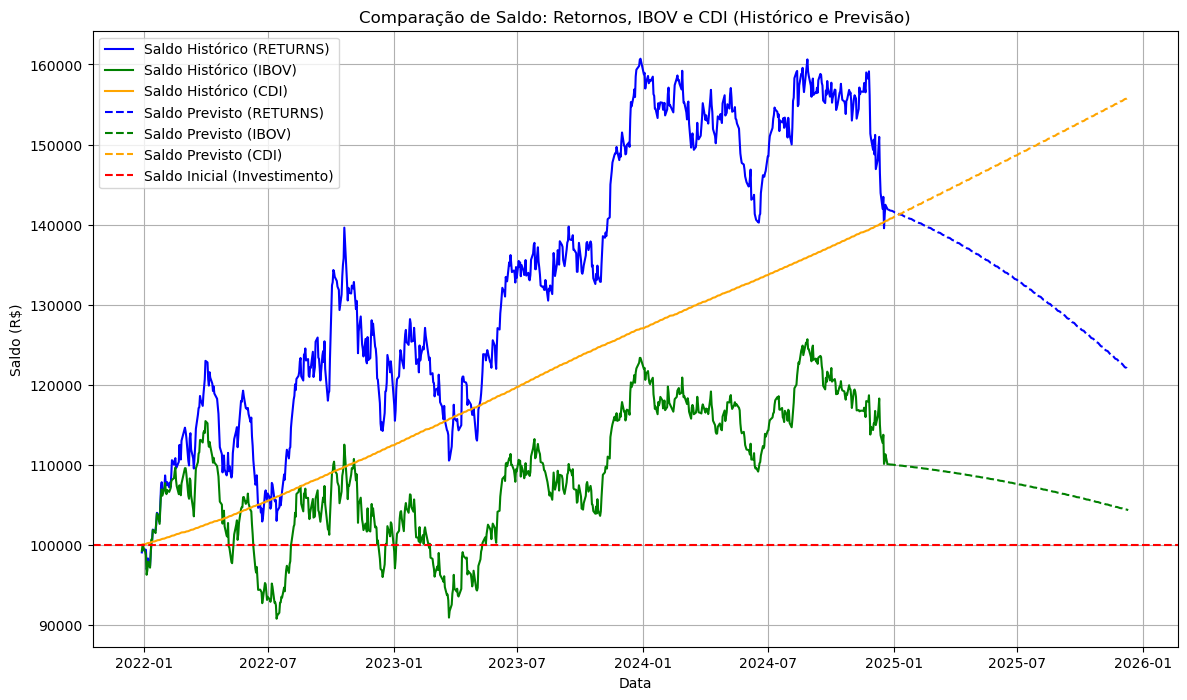


Métricas para RETURNS:
  - MSE: 0.000146
  - MAE: 0.009270
  - R²: 0.001720

Métricas para IBOV:
  - MSE: 0.000120
  - MAE: 0.008454
  - R²: 0.000258

Métricas para CDI:
  - MSE: 0.000000
  - MAE: 0.000038
  - R²: 0.147756


In [1712]:
# Preparação inicial
valor_investido = portfolio_value  # Exemplo: R$100.000
dias_previsao = best_window  # Quantidade de dias úteis para prever no futuro

# Junta a df_modelagem, o cdi, e ibov, usando o index de date de df_modelagem como base
df_modelagem = df_modelagem.join(cdi, how='left').join(log_ibov, how='left')
df_modelagem = df_modelagem.join(historical_returns, how = 'left')
df_modelagem.dropna(inplace=True)

# Criando uma coluna ordinal para as datas no DataFrame
df_modelagem['Date_ordinal'] = df_modelagem.index.map(lambda x: x.toordinal())

# Executando regressão linear para retornos, IBOV e CDI
resultados = {}
for coluna in ['returns', 'IBOV', 'cdi']:
    resultados[coluna] = regressao_linear(df_modelagem, coluna , best_window=best_window)

# Calculando saldo acumulado histórico e futuro para cada série
saldos = {'historico': {}, 'futuro': {}}
for coluna in ['returns', 'IBOV', 'cdi']:
    # Saldo histórico
    saldo_historico = [valor_investido]
    for retorno in df_modelagem[coluna]:
        saldo_historico.append(saldo_historico[-1] * (1 + retorno))
    saldos['historico'][coluna] = saldo_historico[1:]
    
    # Saldo futuro
    saldo_futuro = [saldos['historico'][coluna][-1]]
    for retorno in resultados[coluna]['previsoes_futuras']:
        saldo_futuro.append(saldo_futuro[-1] * (1 + retorno))
    saldos['futuro'][coluna] = saldo_futuro[1:]

# Plotando os resultados
plt.figure(figsize=(14, 8))

# Histórico
for coluna, cor in zip(['returns', 'IBOV', 'cdi'], ['blue', 'green', 'orange']):
    plt.plot(df_modelagem.index, saldos['historico'][coluna], label=f'Saldo Histórico ({coluna.upper()})', color=cor)

# Futuro
for coluna, cor in zip(['returns', 'IBOV', 'cdi'], ['blue', 'green', 'orange']):
    plt.plot(resultados[coluna]['datas_futuras'], saldos['futuro'][coluna], linestyle='--', label=f'Saldo Previsto ({coluna.upper()})', color=cor)

# Linha do investimento inicial
plt.axhline(y=valor_investido, color='red', linestyle='--', label='Saldo Inicial (Investimento)')

# Configurações do gráfico
plt.xlabel('Data')
plt.ylabel('Saldo (R$)')
plt.title('Comparação de Saldo: Retornos, IBOV e CDI (Histórico e Previsão)')
plt.legend()
plt.grid(True)
plt.show()

# Métricas da regressão
for coluna in ['returns', 'IBOV', 'cdi']:
    print(f"\nMétricas para {coluna.upper()}:")
    print(f"  - MSE: {resultados[coluna]['mse']:.6f}")
    print(f"  - MAE: {resultados[coluna]['mae']:.6f}")
    print(f"  - R²: {resultados[coluna]['r2']:.6f}")


### Previsão do Portfolio - ARIMA

#### Portfólio

<class 'pandas.core.series.Series'>
Date
2021-12-29     99071.921171
2021-12-30     99367.847829
2022-01-03     99440.143549
2022-01-04     99392.851153
2022-01-05     96943.004342
                  ...      
2024-12-18    138793.858439
2024-12-19    139955.749417
2024-12-20    140883.137018
2024-12-23    140507.538430
2024-12-26    140650.629150
Name: returns, Length: 749, dtype: float64


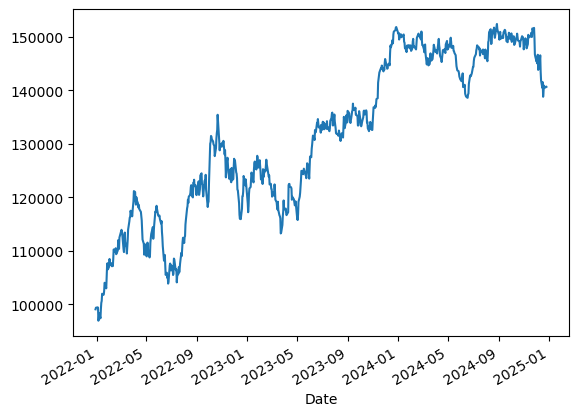

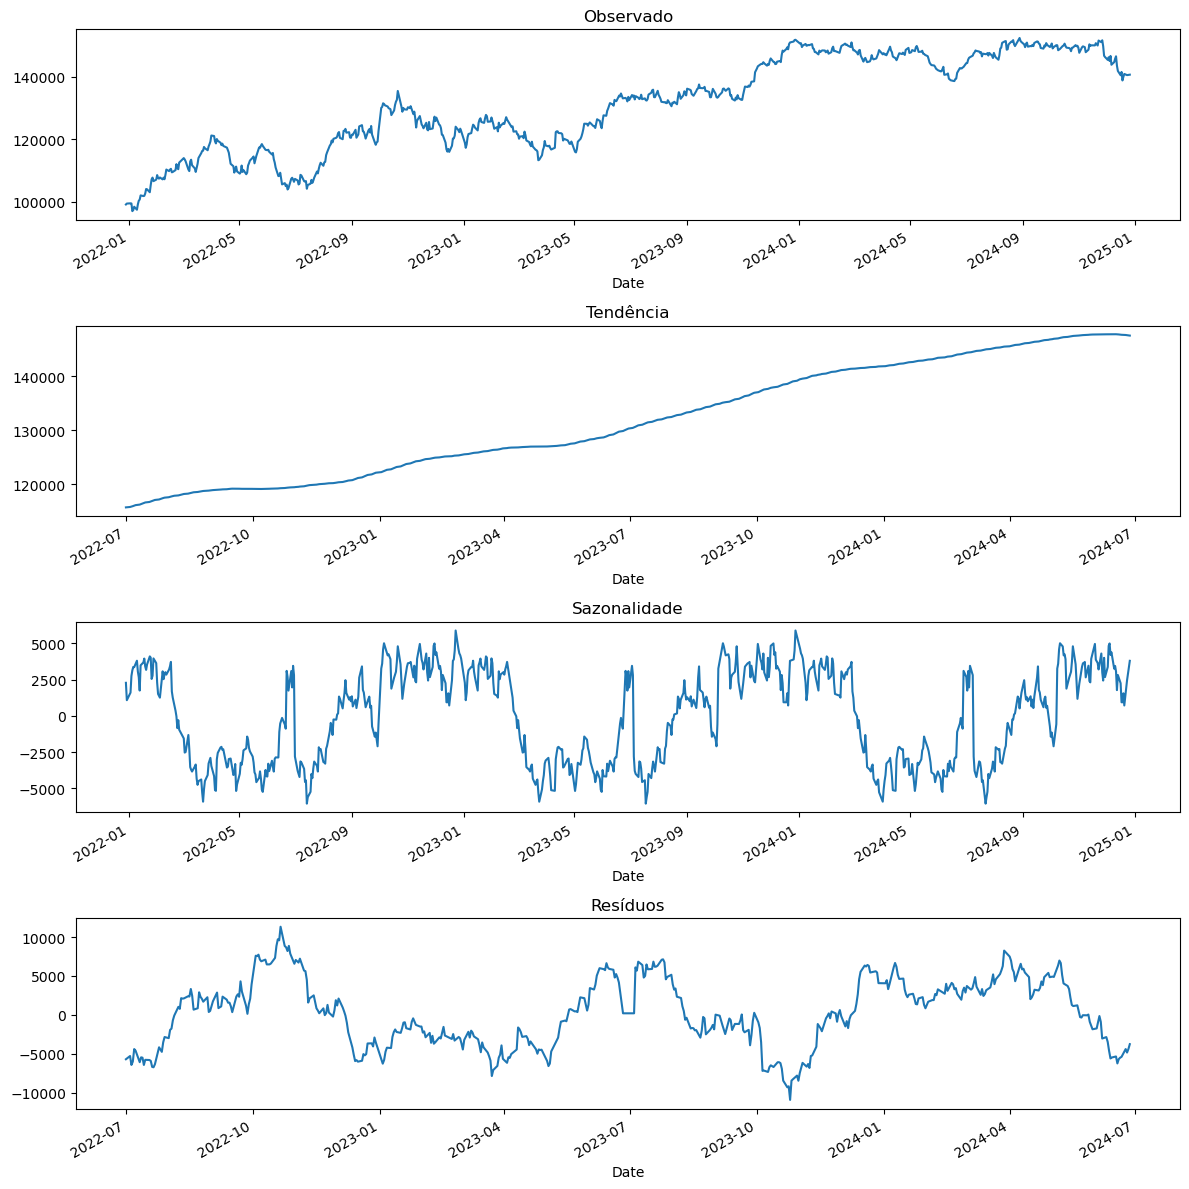


Teste de Shapiro-Wilk para retornos do portfolio: Estatística=0.985, p-valor=0.000
Provavelmente não normal

Teste de Dickey-Fuller Aumentado para retornos do portfolio:
ADF Statistic: -2.210533
p-value: 0.202445
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
Série provavelmente não estacionária



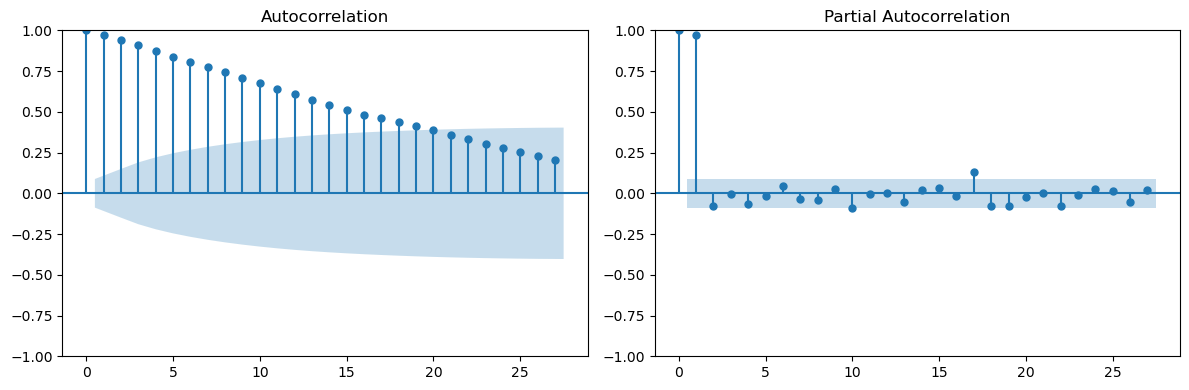

In [1713]:
# análise dos retornos

# Calcula o retorno acumulado do portfolio
portfolio_return = (historical_returns.cumsum() + 1) * portfolio_value
print(type(portfolio_return))
print(portfolio_return)
portfolio_return.plot()

# fazendo a decomposição
decomposition = seasonal_decompose(portfolio_return.dropna(), model='additive', period=best_window)

# Plotar a decomposição
fig, axes = plt.subplots(4, 1, figsize=(12, 12))
decomposition.observed.plot(ax=axes[0], title='Observado')
decomposition.trend.plot(ax=axes[1], title='Tendência')
decomposition.seasonal.plot(ax=axes[2], title='Sazonalidade')
decomposition.resid.plot(ax=axes[3], title='Resíduos')
plt.tight_layout()
plt.show()

# Teste de normalidade dos resíduos (Shapiro-Wilk)
statistic, p_value = shapiro(decomposition.resid.dropna())
print(f'\nTeste de Shapiro-Wilk para retornos do portfolio: Estatística={statistic:.3f}, p-valor={p_value:.3f}')
if p_value > 0.05:
    print('Provavelmente normal')
else:
    print('Provavelmente não normal')

# Teste de estacionariedade (Dickey-Fuller Aumentado)
result_adfuller = adfuller(portfolio_return.dropna())
print(f'\nTeste de Dickey-Fuller Aumentado para retornos do portfolio:')
print('ADF Statistic: %f' % result_adfuller[0])
print('p-value: %f' % result_adfuller[1])
print('Critical Values:')
for key, value in result_adfuller[4].items():
    print('\t%s: %.3f' % (key, value))

# Verifique se o p-valor do teste ADF é menor que 0.05
if result_adfuller[1] <= 0.05:
    print('Série provavelmente estacionária\n')
else:
    print('Série provavelmente não estacionária\n')



# Autocorrelação e Autocorrelação Parcial dos resíduos
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(decomposition.resid.dropna(), ax=axes[0])
plot_pacf(decomposition.resid.dropna(), ax=axes[1])
plt.tight_layout()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=12773.777, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=16521.738, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=15568.263, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=19789.274, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=12773.053, Time=0.40 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=12774.687, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=12775.358, Time=0.23 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=12775.038, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=12768.565, Time=0.65 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=12770.315, Time=0.83 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=12770.323, Time=0.59 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   :

c:\Users\jeand\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jeand\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jeand\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jeand\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive pa

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                  599
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -5121.476
Date:                Thu, 26 Dec 2024   AIC                          10256.951
Time:                        23:15:04   BIC                          10287.718
Sample:                             0   HQIC                         10268.929
                                - 599                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.271e+05    1.6e+04      7.920      0.000    9.56e+04    1.59e+05
ar.L1          0.0596      0.146      0.409      0.682      -0.226       0.345
ar.L2          0.1718      0.128      1.344      0.1

c:\Users\jeand\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\jeand\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\jeand\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


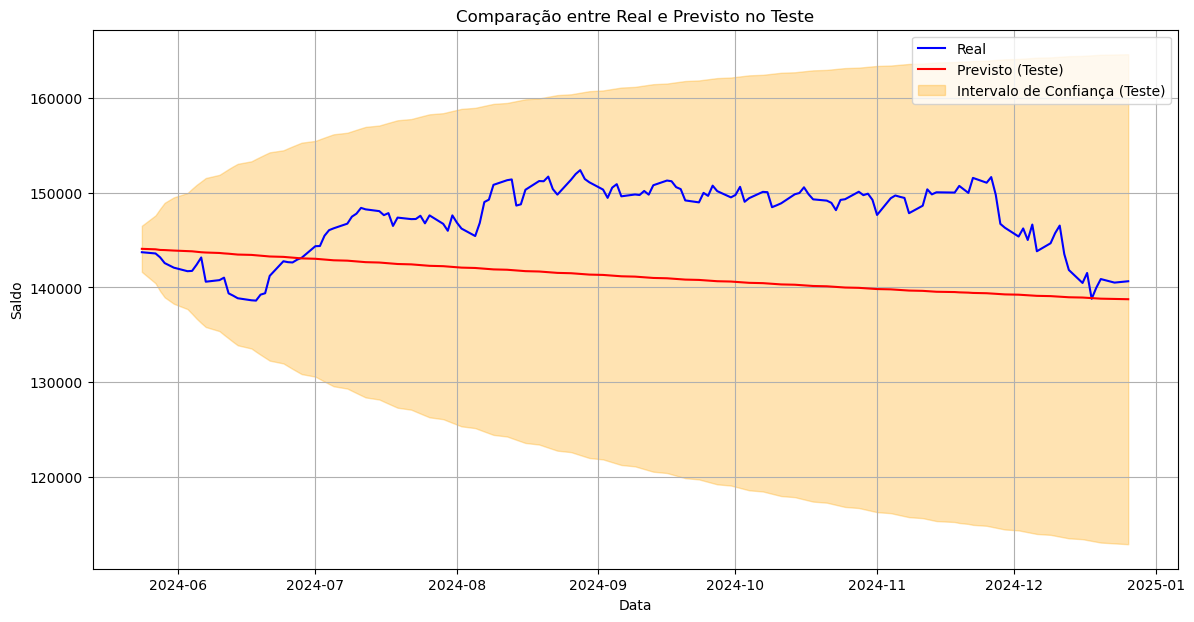

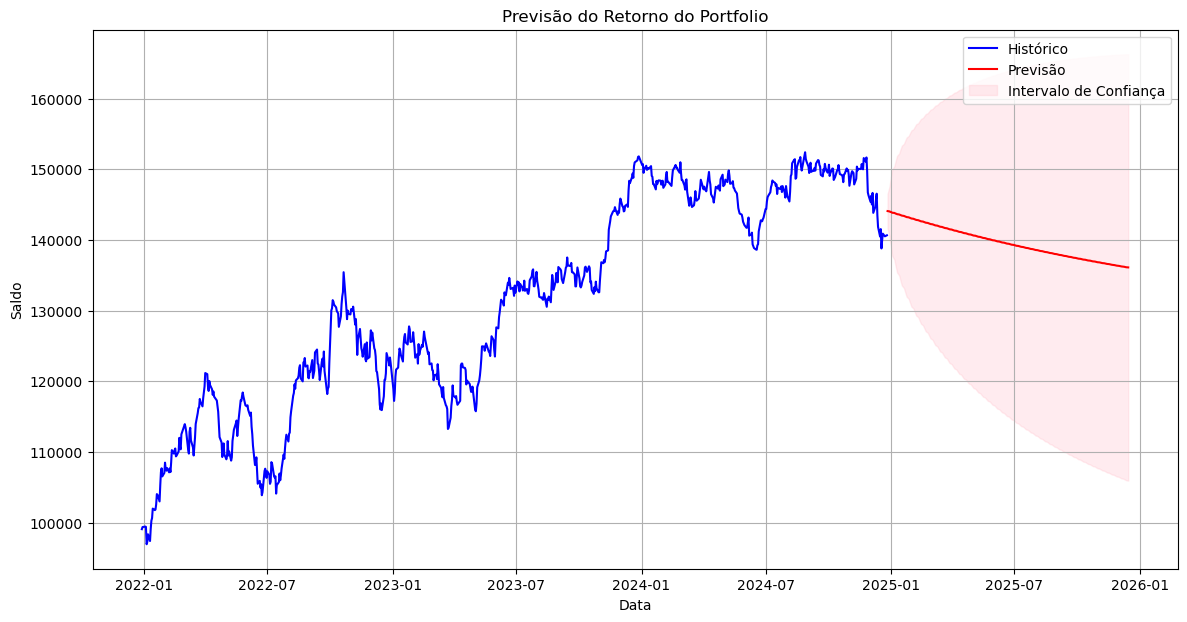

In [1714]:

# Ajustar o modelo Auto-ARIMA
modelo_auto_arima = auto_arima(portfolio_return,
                               start_p=1, start_q=1,
                               max_p=15, max_q=15,
                               d=0,  # Determina d automaticamente
                               seasonal=True,  # Ajuste conforme necessidade
                               trace=True,
                               error_action='ignore',
                               suppress_warnings=True,
                               stepwise=True)

print(modelo_auto_arima.summary())

# Dividir os dados em treino e teste (80% treino, 20% teste)
train_size = int(len(portfolio_return) * 0.8)
train_data, test_data = portfolio_return[:train_size], portfolio_return[train_size:]

# Imprimir os shapes dos conjuntos de treino e teste
print("Shape dos dados de treino:", train_data.shape)
print("Shape dos dados de teste:", test_data.shape)

model_ARIMA = ARIMA(train_data, order=(3,0,2))
result = model_ARIMA.fit()
print(result.summary())

# Realizar previsões no conjunto de teste
predictions_test = result.get_forecast(steps=len(test_data))
pred_conf_int = predictions_test.conf_int()
predicted_mean = predictions_test.predicted_mean

# Prever o melhor x-day dias no futuro
forecast_steps = best_window
portfolio_forecast = result.get_forecast(steps=forecast_steps)
forecast_conf_int = portfolio_forecast.conf_int()
forecast_mean = portfolio_forecast.predicted_mean

# Plotar gráficos

# Gráfico de comparação do teste
plt.figure(figsize=(14, 7))
#plt.plot(portfolio_return.index[:len(train_data)].index, train_data, label ="Treino", color = 'green')
plt.plot(portfolio_return.index[-len(test_data):], test_data, label='Real', color='blue')
plt.plot(portfolio_return.index[-len(test_data):], predicted_mean, label='Previsto (Teste)', color='red')
plt.fill_between(portfolio_return.index[-len(test_data):], pred_conf_int.iloc[:, 0], pred_conf_int.iloc[:, 1], color='orange', alpha=0.3, label='Intervalo de Confiança (Teste)')
plt.xlabel('Data')
plt.ylabel('Saldo')
plt.title('Comparação entre Real e Previsto no Teste')
plt.legend()
plt.grid(True)
plt.show()


# Criar um índice de datas para a previsão
last_date = portfolio_return.index[-1]
forecast_index = pd.date_range(start=last_date + timedelta(days=1), periods=forecast_steps, freq='B')  # 'B' para dias úteis

# Plotar o gráfico da previsão
plt.figure(figsize=(14, 7))
plt.plot(portfolio_return.index, portfolio_return, label='Histórico', color='blue')
plt.plot(forecast_index, forecast_mean, label='Previsão', color='red')
plt.fill_between(forecast_index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Intervalo de Confiança')
plt.xlabel('Data')
plt.ylabel('Saldo')
plt.title('Previsão do Retorno do Portfolio')
plt.legend()
plt.grid(True)
plt.show()

#### CDI

<class 'pandas.core.frame.DataFrame'>
                      cdi
data                     
2021-12-28  100000.000000
2021-12-29  100000.000000
2021-12-30  100000.000000
2021-12-31  100000.000000
2022-01-03  100000.000000
...                   ...
2024-12-18  126984.720482
2024-12-19  126984.720482
2024-12-20  126984.720482
2024-12-23  126984.720482
2024-12-24  126984.720482

[753 rows x 1 columns]


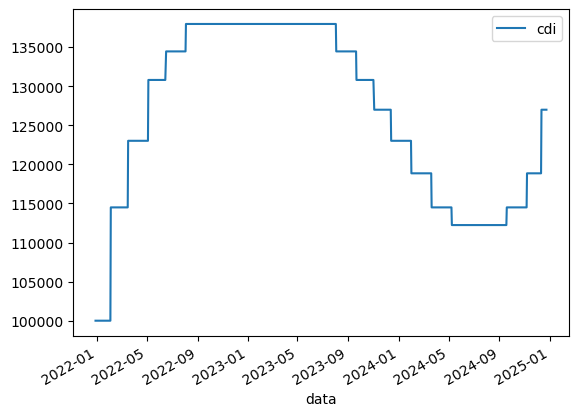

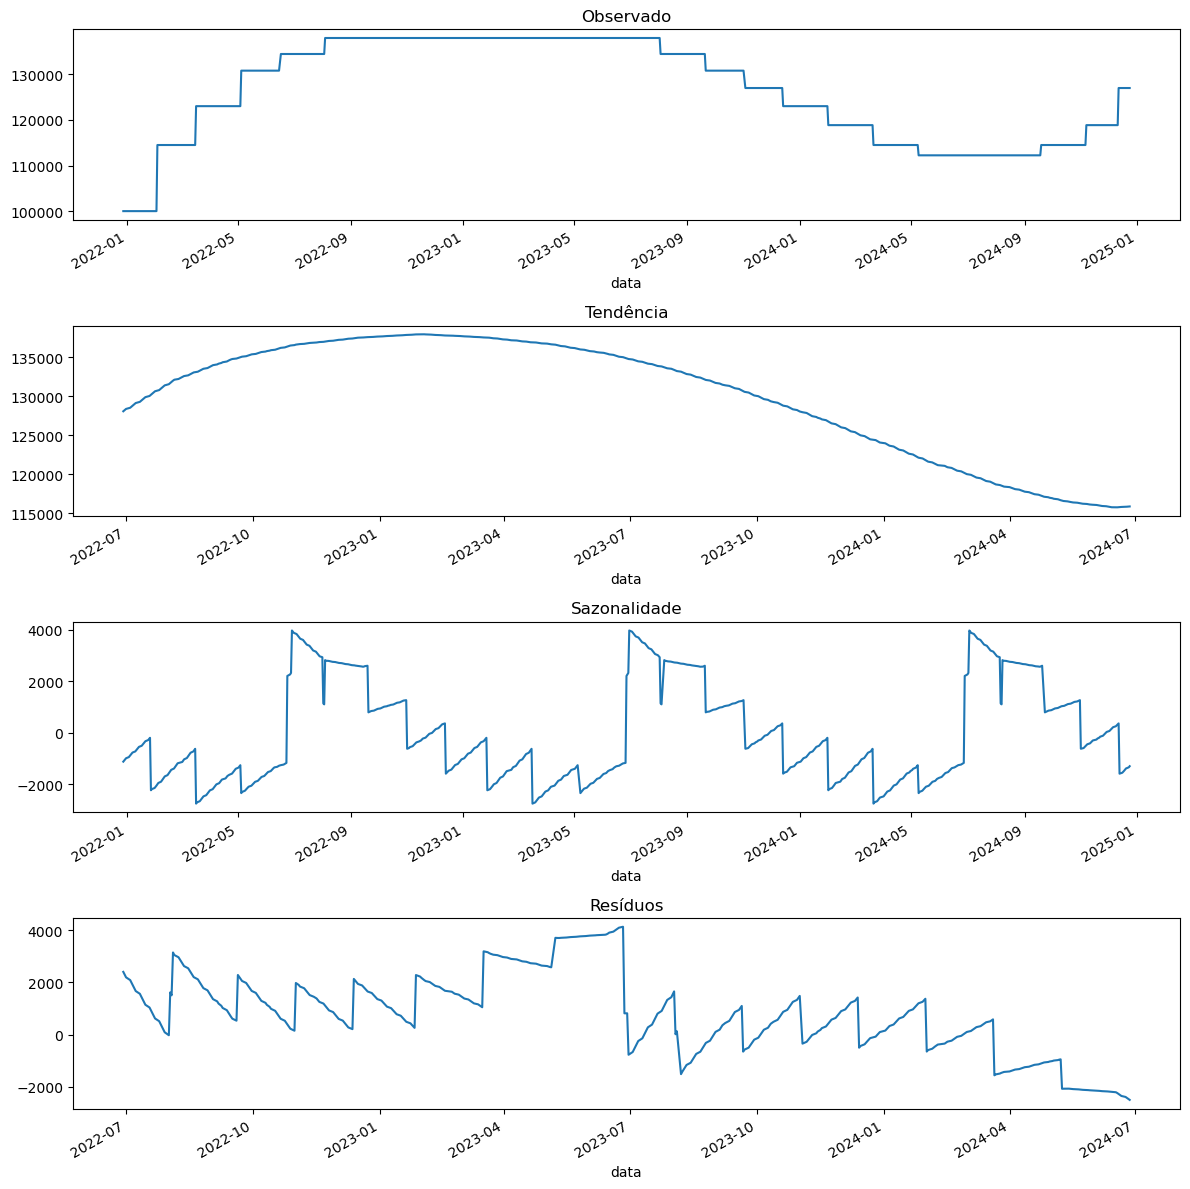


Teste de Shapiro-Wilk para CDI: Estatística=0.982, p-valor=0.000
Provavelmente não normal

Teste de Dickey-Fuller Aumentado para CDI:
ADF Statistic: -2.365285
p-value: 0.151775
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
Série provavelmente não estacionária



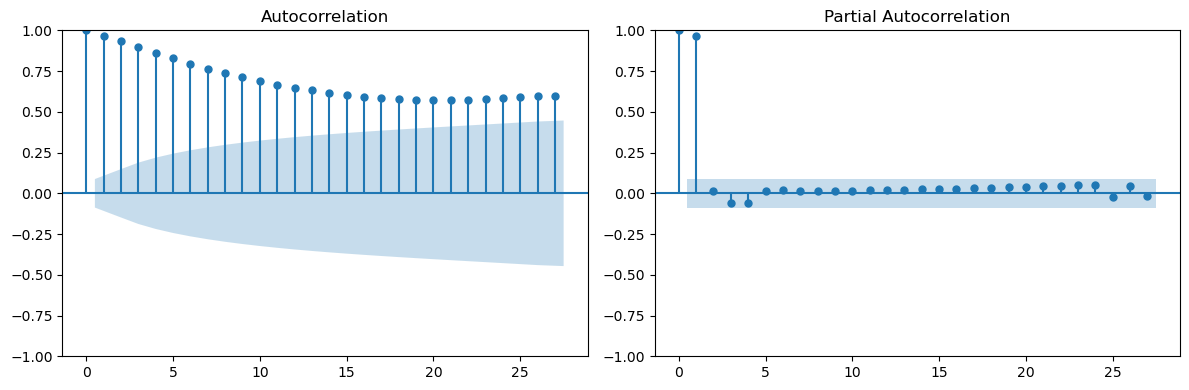

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=12331.247, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=16179.839, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=19834.212, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=12328.707, Time=0.52 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=12330.842, Time=0.68 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=12330.951, Time=0.28 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=12333.389, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 3.156 seconds
                               SARIMAX Result

c:\Users\jeand\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jeand\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jeand\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jeand\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive pa

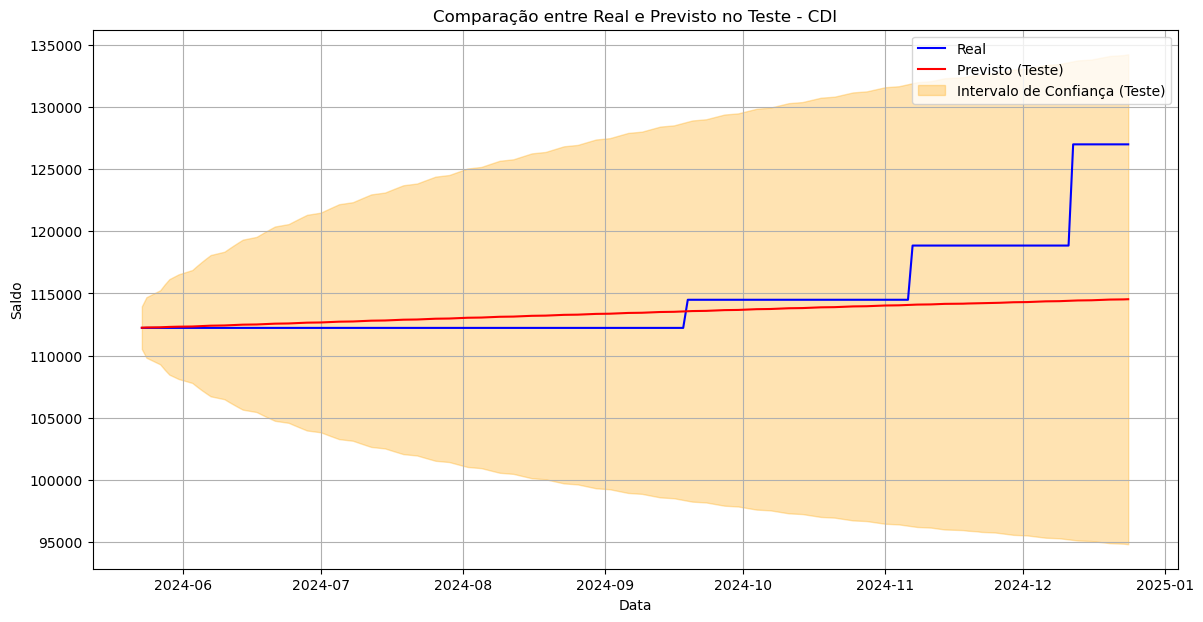

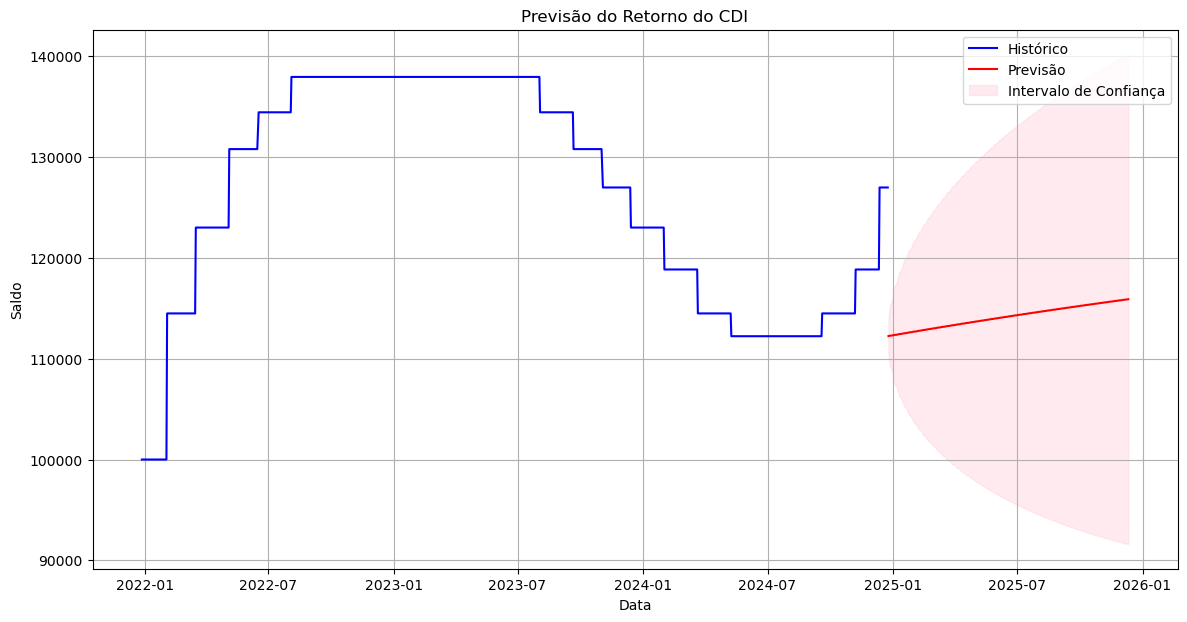

In [1715]:

# Supondo que 'historical_CDI' seja uma série temporal de retornos do CDI
cdi_return = (log_cdi.cumsum() + 1) * portfolio_value
print(type(cdi_return))
print(cdi_return)
cdi_return.plot()

# Decomposição sazonal para CDI
decomposition_cdi = seasonal_decompose(cdi_return.dropna(), model='additive', period=252)

# Plotar a decomposição
fig, axes = plt.subplots(4, 1, figsize=(12, 12))
decomposition_cdi.observed.plot(ax=axes[0], title='Observado')
decomposition_cdi.trend.plot(ax=axes[1], title='Tendência')
decomposition_cdi.seasonal.plot(ax=axes[2], title='Sazonalidade')
decomposition_cdi.resid.plot(ax=axes[3], title='Resíduos')
plt.tight_layout()
plt.show()

# Teste de normalidade dos resíduos (Shapiro-Wilk)
statistic, p_value = shapiro(decomposition_cdi.resid.dropna())
print(f'\nTeste de Shapiro-Wilk para CDI: Estatística={statistic:.3f}, p-valor={p_value:.3f}')
if p_value > 0.05:
    print('Provavelmente normal')
else:
    print('Provavelmente não normal')

# Teste de estacionariedade (Dickey-Fuller Aumentado)
result_adfuller_cdi = adfuller(cdi_return.dropna())
print(f'\nTeste de Dickey-Fuller Aumentado para CDI:')
print('ADF Statistic: %f' % result_adfuller_cdi[0])
print('p-value: %f' % result_adfuller_cdi[1])
print('Critical Values:')
for key, value in result_adfuller_cdi[4].items():
    print('\t%s: %.3f' % (key, value))
if result_adfuller_cdi[1] <= 0.05:
    print('Série provavelmente estacionária\n')
else:
    print('Série provavelmente não estacionária\n')

# Autocorrelação e Autocorrelação Parcial dos resíduos
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(decomposition_cdi.resid.dropna(), ax=axes[0])
plot_pacf(decomposition_cdi.resid.dropna(), ax=axes[1])
plt.tight_layout()
plt.show()

# Ajustar o modelo Auto-ARIMA para CDI
modelo_auto_arima_cdi = auto_arima(cdi_return,
                                   start_p=1, start_q=1,
                                   max_p=15, max_q=15,
                                   d=0,  # Determina d automaticamente
                                   seasonal=True,  # Ajuste conforme necessidade
                                   trace=True,
                                   error_action='ignore',
                                   suppress_warnings=True,
                                   stepwise=True)
print(modelo_auto_arima_cdi.summary())

# Dividir os dados em treino e teste (80% treino, 20% teste) para CDI
train_size_cdi = int(len(cdi_return) * 0.8)
train_data_cdi, test_data_cdi = cdi_return[:train_size_cdi], cdi_return[train_size_cdi:]

# Imprimir os shapes dos conjuntos de treino e teste
print("Shape dos dados de treino CDI:", train_data_cdi.shape)
print("Shape dos dados de teste CDI:", test_data_cdi.shape)

# Ajuste o modelo ARIMA para CDI
model_ARIMA_cdi = ARIMA(train_data_cdi, order=(2,0,1))
result_cdi = model_ARIMA_cdi.fit()
result_cdi.summary()

# Realizar previsões no conjunto de teste
predictions_test_cdi = result_cdi.get_forecast(steps=len(test_data_cdi))
pred_conf_int_cdi = predictions_test_cdi.conf_int()
predicted_mean_cdi = predictions_test_cdi.predicted_mean

# Prever o melhor x-day dias no futuro
forecast_steps_cdi = best_window
forecast_cdi = result_cdi.get_forecast(steps=forecast_steps_cdi)
forecast_conf_int_cdi = forecast_cdi.conf_int()
forecast_mean_cdi = forecast_cdi.predicted_mean

# Plotar gráfico de comparação do teste para CDI
plt.figure(figsize=(14, 7))
plt.plot(cdi_return.index[-len(test_data_cdi):], test_data_cdi, label='Real', color='blue')
plt.plot(cdi_return.index[-len(test_data_cdi):], predicted_mean_cdi, label='Previsto (Teste)', color='red')
plt.fill_between(cdi_return.index[-len(test_data_cdi):], pred_conf_int_cdi.iloc[:, 0], pred_conf_int_cdi.iloc[:, 1], color='orange', alpha=0.3, label='Intervalo de Confiança (Teste)')
plt.xlabel('Data')
plt.ylabel('Saldo')
plt.title('Comparação entre Real e Previsto no Teste - CDI')
plt.legend()
plt.grid(True)
plt.show()

# Criar um índice de datas para a previsão
last_date = cdi_return.index[-1]
forecast_index_cdi = pd.date_range(start=last_date + timedelta(days=1), periods=forecast_steps_cdi, freq='B')  # 'B' para dias úteis

# Plotar o gráfico da previsão
plt.figure(figsize=(14, 7))
plt.plot(cdi_return.index, cdi_return, label='Histórico', color='blue')
plt.plot(forecast_index_cdi, forecast_mean_cdi, label='Previsão', color='red')
plt.fill_between(forecast_index_cdi, forecast_conf_int_cdi.iloc[:, 0], forecast_conf_int_cdi.iloc[:, 1], color='pink', alpha=0.3, label='Intervalo de Confiança')
plt.xlabel('Data')
plt.ylabel('Saldo')
plt.title('Previsão do Retorno do CDI')
plt.legend()
plt.grid(True)
plt.show()


#### IBOV

<class 'pandas.core.frame.DataFrame'>
                     IBOV
Date                     
2021-12-29   99275.494388
2021-12-30   99959.940100
2022-01-03   99097.634523
2022-01-04   98704.259674
2022-01-05   96251.564850
...                   ...
2024-12-18  114124.019804
2024-12-19  114467.878632
2024-12-20  115219.248848
2024-12-23  114119.879686
2024-12-26  114376.656392

[749 rows x 1 columns]


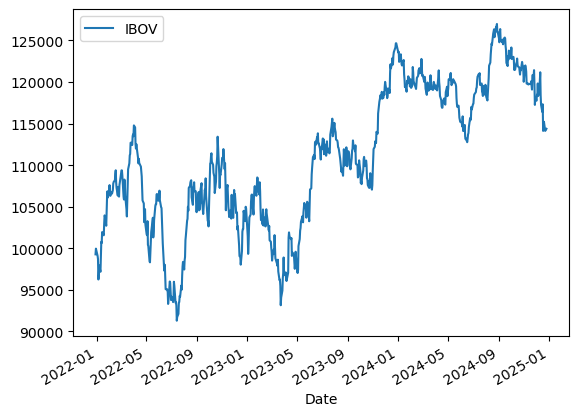

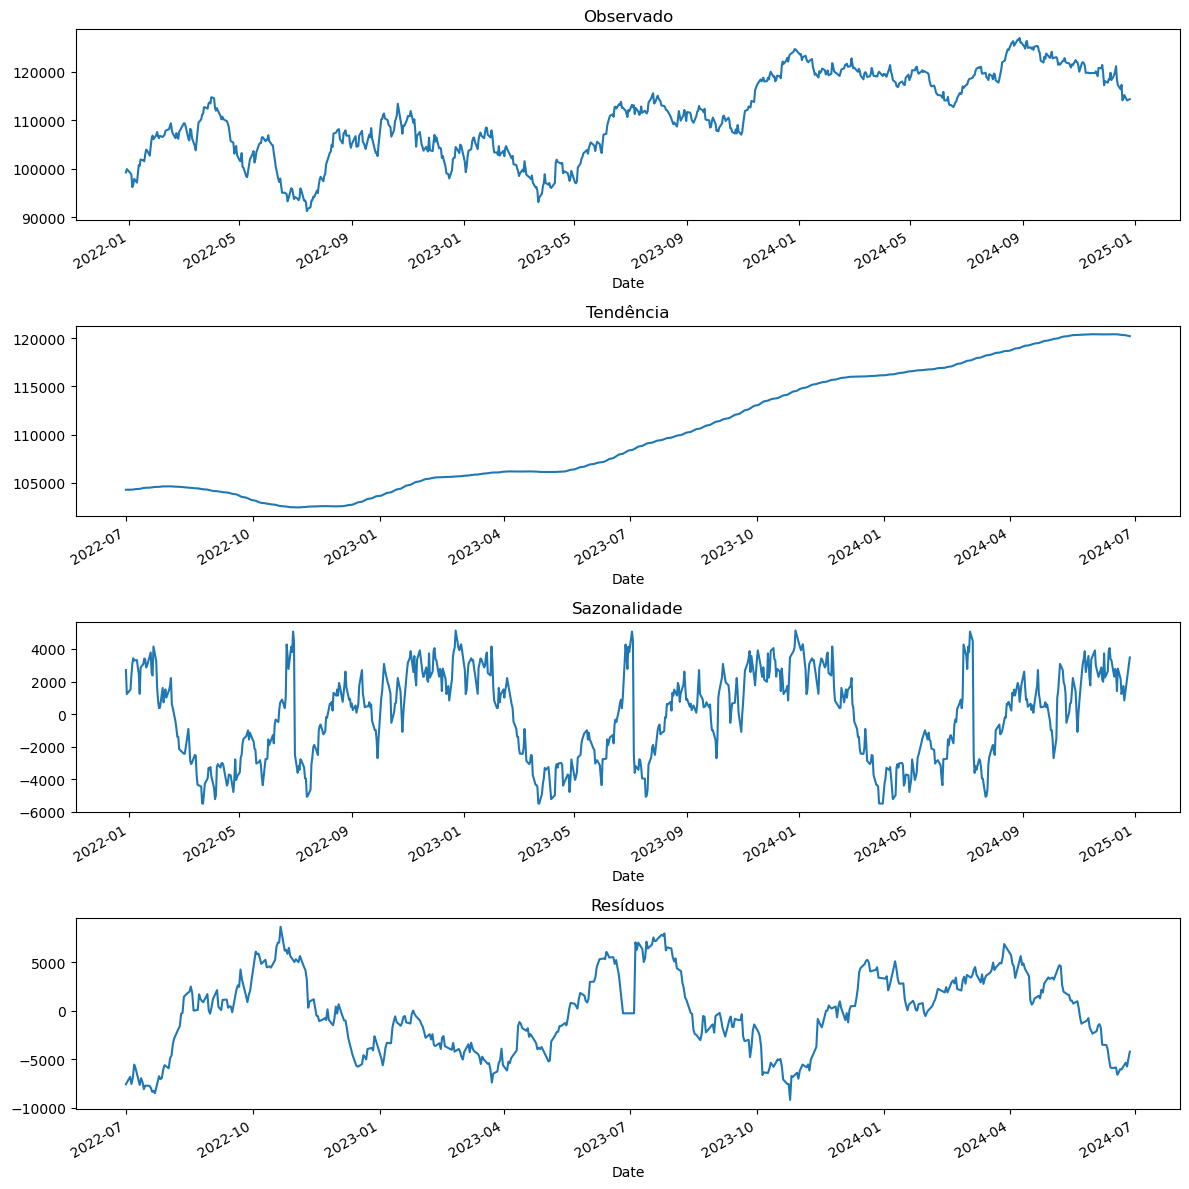


Teste de Shapiro-Wilk para IBOV: Estatística=0.980, p-valor=0.000
Provavelmente não normal

Teste de Dickey-Fuller Aumentado para IBOV:
ADF Statistic: -1.993790
p-value: 0.289303
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
Série provavelmente não estacionária



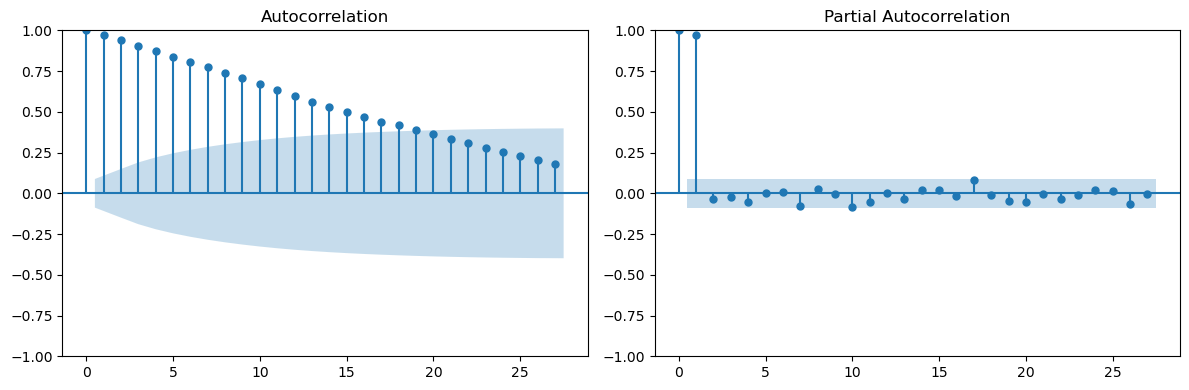

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=12616.728, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=15692.877, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=14784.122, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=19532.964, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=12617.348, Time=0.37 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=12616.652, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=14130.501, Time=0.29 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=12618.397, Time=0.25 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=12618.267, Time=0.12 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=13769.348, Time=0.76 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=12620.263, Time=0.35 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=12622.635, Time=0.24 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 2.770 seconds
               

c:\Users\jeand\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jeand\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jeand\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jeand\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\U

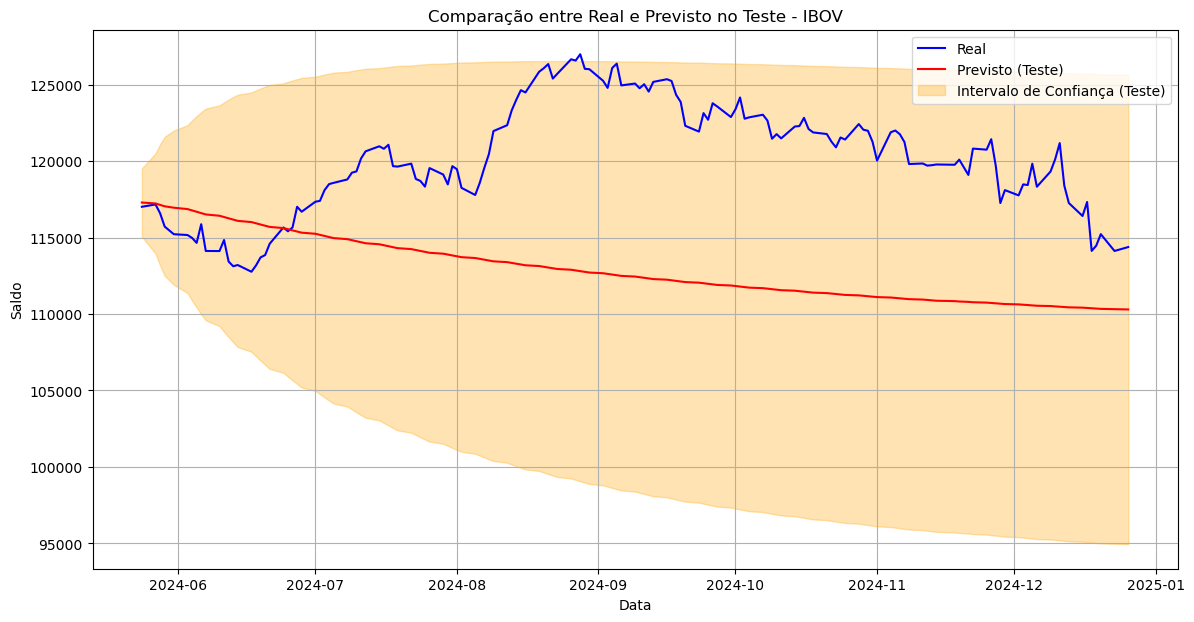

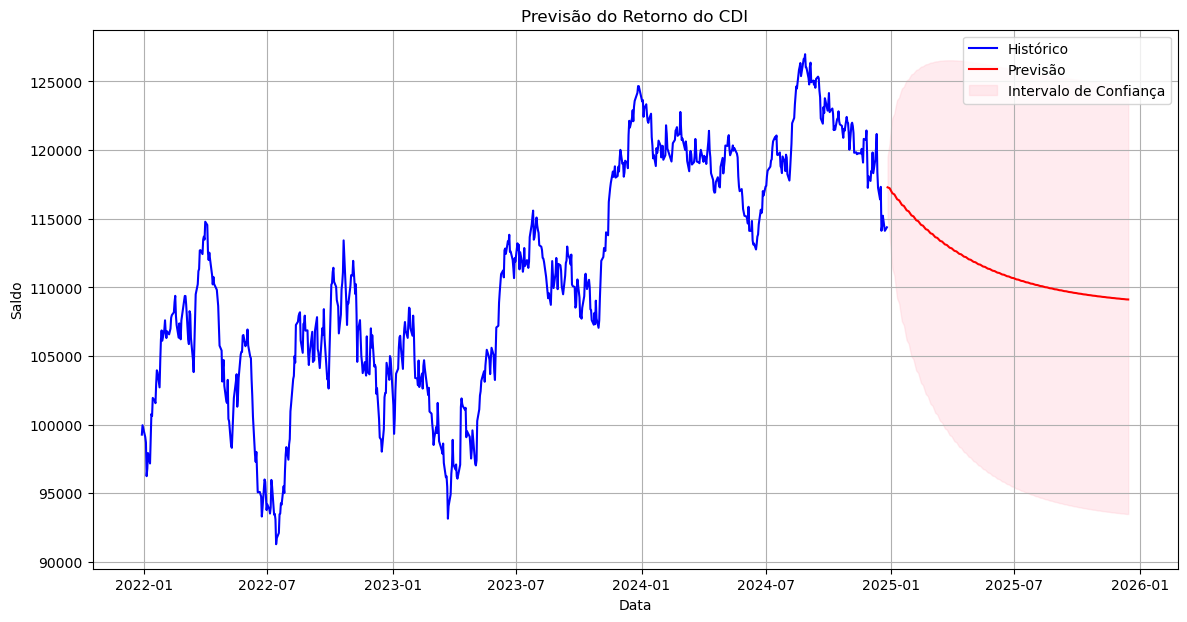

In [1716]:
# Análise do IBOV


# Supondo que 'historical_IBOV' seja uma série temporal de retornos do IBOV
ibov_return = (log_ibov.cumsum() + 1) * portfolio_value
print(type(ibov_return))
print(ibov_return)
ibov_return.plot()

# Decomposição sazonal para IBOV
decomposition_ibov = seasonal_decompose(ibov_return.dropna(), model='additive', period=252)

# Plotar a decomposição
fig, axes = plt.subplots(4, 1, figsize=(12, 12))
decomposition_ibov.observed.plot(ax=axes[0], title='Observado')
decomposition_ibov.trend.plot(ax=axes[1], title='Tendência')
decomposition_ibov.seasonal.plot(ax=axes[2], title='Sazonalidade')
decomposition_ibov.resid.plot(ax=axes[3], title='Resíduos')
plt.tight_layout()
plt.show()

# Teste de normalidade dos resíduos (Shapiro-Wilk)
statistic, p_value = shapiro(decomposition_ibov.resid.dropna())
print(f'\nTeste de Shapiro-Wilk para IBOV: Estatística={statistic:.3f}, p-valor={p_value:.3f}')
if p_value > 0.05:
    print('Provavelmente normal')
else:
    print('Provavelmente não normal')

# Teste de estacionariedade (Dickey-Fuller Aumentado)
result_adfuller_ibov = adfuller(ibov_return.dropna())
print(f'\nTeste de Dickey-Fuller Aumentado para IBOV:')
print('ADF Statistic: %f' % result_adfuller_ibov[0])
print('p-value: %f' % result_adfuller_ibov[1])
print('Critical Values:')
for key, value in result_adfuller_ibov[4].items():
    print('\t%s: %.3f' % (key, value))
if result_adfuller_ibov[1] <= 0.05:
    print('Série provavelmente estacionária\n')
else:
    print('Série provavelmente não estacionária\n')

# Autocorrelação e Autocorrelação Parcial dos resíduos
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(decomposition_ibov.resid.dropna(), ax=axes[0])
plot_pacf(decomposition_ibov.resid.dropna(), ax=axes[1])
plt.tight_layout()
plt.show()

# Ajustar o modelo Auto-ARIMA para IBOV
modelo_auto_arima_ibov = auto_arima(ibov_return,
                                    start_p=1, start_q=1,
                                    max_p=15, max_q=15,
                                    d=0,  # Determina d automaticamente
                                    seasonal=True,  # Ajuste conforme necessidade
                                    trace=True,
                                    error_action='ignore',
                                    suppress_warnings=True,
                                    stepwise=True)
print(modelo_auto_arima_ibov.summary())

# Dividir os dados em treino e teste (80% treino, 20% teste) para IBOV
train_size_ibov = int(len(ibov_return) * 0.8)
train_data_ibov, test_data_ibov = ibov_return[:train_size_ibov], ibov_return[train_size_ibov:]

# Imprimir os shapes dos conjuntos de treino e teste
print("Shape dos dados de treino IBOV:", train_data_ibov.shape)
print("Shape dos dados de teste IBOV:", test_data_ibov.shape)

# Ajuste o modelo ARIMA para IBOV
model_ARIMA_ibov = ARIMA(train_data_ibov, order=(1,0,2))
result_ibov = model_ARIMA_ibov.fit()
result_ibov.summary()

# Realizar previsões no conjunto de teste
predictions_test_ibov = result_ibov.get_forecast(steps=len(test_data_ibov))
pred_conf_int_ibov = predictions_test_ibov.conf_int()
predicted_mean_ibov = predictions_test_ibov.predicted_mean

# Prever o melhor x-day dias no futuro
forecast_steps_ibov = best_window
forecast_ibov = result_ibov.get_forecast(steps=forecast_steps_ibov)
forecast_conf_int_ibov = forecast_ibov.conf_int()
forecast_mean_ibov = forecast_ibov.predicted_mean

# Plotar gráfico de comparação do teste para IBOV
plt.figure(figsize=(14, 7))
plt.plot(ibov_return.index[-len(test_data_ibov):], test_data_ibov, label='Real', color='blue')
plt.plot(ibov_return.index[-len(test_data_ibov):], predicted_mean_ibov, label='Previsto (Teste)', color='red')
plt.fill_between(ibov_return.index[-len(test_data_ibov):], pred_conf_int_ibov.iloc[:, 0], pred_conf_int_ibov.iloc[:, 1], color='orange', alpha=0.3, label='Intervalo de Confiança (Teste)')
plt.xlabel('Data')
plt.ylabel('Saldo')
plt.title('Comparação entre Real e Previsto no Teste - IBOV')
plt.legend()
plt.grid(True)
plt.show()


# Criar um índice de datas para a previsão
last_date = ibov_return.index[-1]
forecast_index_ibov = pd.date_range(start=last_date + timedelta(days=1), periods=forecast_steps_ibov, freq='B')  # 'B' para dias úteis

# Plotar o gráfico da previsão
plt.figure(figsize=(14, 7))
plt.plot(ibov_return.index, ibov_return, label='Histórico', color='blue')
plt.plot(forecast_index_ibov, forecast_mean_ibov, label='Previsão', color='red')
plt.fill_between(forecast_index_ibov, forecast_conf_int_ibov.iloc[:, 0], forecast_conf_int_ibov.iloc[:, 1], color='pink', alpha=0.3, label='Intervalo de Confiança')
plt.xlabel('Data')
plt.ylabel('Saldo')
plt.title('Previsão do Retorno do CDI')
plt.legend()
plt.grid(True)
plt.show()


#### Comparativo

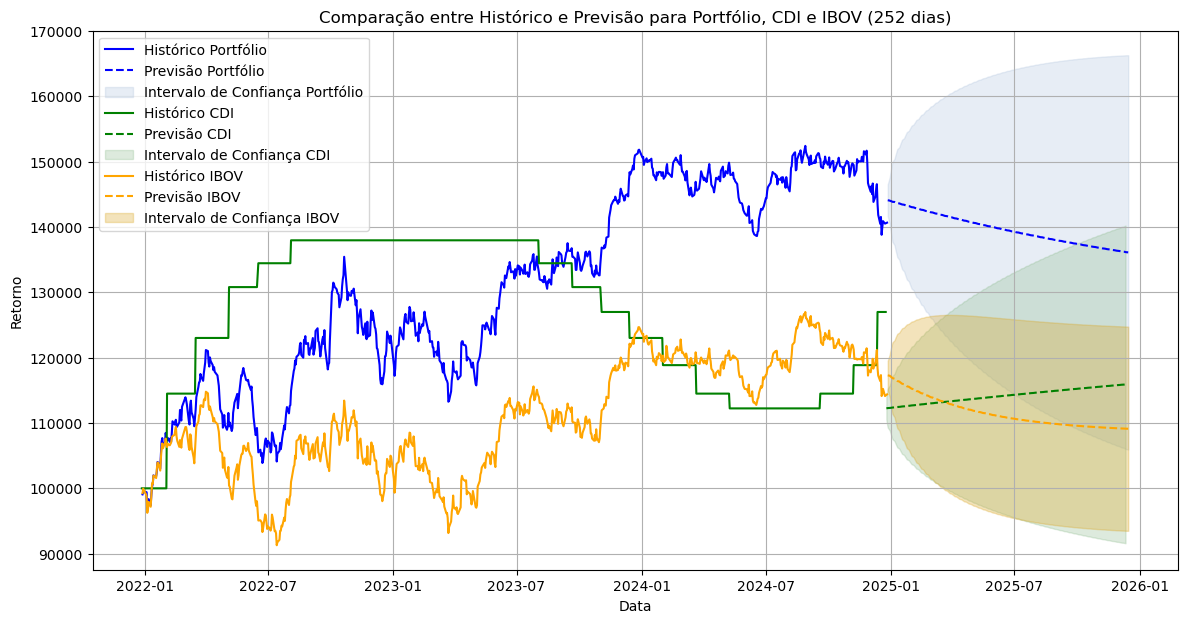

In [1717]:
# Plotar o gráfico da previsão
plt.figure(figsize=(14, 7))

plt.plot(portfolio_return.index, portfolio_return, label='Histórico Portfólio', color='blue')
plt.plot(forecast_index, forecast_mean, label='Previsão Portfólio', color='blue', linestyle='--')
plt.fill_between(forecast_index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='lightsteelblue', alpha=0.3, label='Intervalo de Confiança Portfólio')

plt.plot(cdi_return.index, cdi_return, label='Histórico CDI', color='green')
plt.plot(forecast_index_cdi, forecast_mean_cdi, label='Previsão CDI', color='green',  linestyle='--')
plt.fill_between(forecast_index_cdi, forecast_conf_int_cdi.iloc[:, 0], forecast_conf_int_cdi.iloc[:, 1], color='darkseagreen', alpha=0.3, label='Intervalo de Confiança CDI')

plt.plot(ibov_return.index, ibov_return, label='Histórico IBOV', color='orange')
plt.plot(forecast_index_ibov, forecast_mean_ibov, label='Previsão IBOV', color='orange',  linestyle='--')
plt.fill_between(forecast_index_ibov, forecast_conf_int_ibov.iloc[:, 0], forecast_conf_int_ibov.iloc[:, 1], color='goldenrod', alpha=0.3, label='Intervalo de Confiança IBOV')

plt.xlabel('Data')
plt.ylabel('Retorno')
plt.title(f'Comparação entre Histórico e Previsão para Portfólio, CDI e IBOV ({best_window} dias)')
plt.legend()
plt.grid(True)
plt.show()

### Previsão do Portfólio - LSTM

In [1718]:
# Calcula o retorno acumulado do portfolio
portfolio_return = (historical_returns.cumsum() + 1) * portfolio_value

# Cria um DataFrame com o saldo do portfolio por dia
portfolio_balance = pd.DataFrame({
    'Saldo': portfolio_return
})

# Exibe o DataFrame
print(portfolio_balance)


                    Saldo
Date                     
2021-12-29   99071.921171
2021-12-30   99367.847829
2022-01-03   99440.143549
2022-01-04   99392.851153
2022-01-05   96943.004342
...                   ...
2024-12-18  138793.858439
2024-12-19  139955.749417
2024-12-20  140883.137018
2024-12-23  140507.538430
2024-12-26  140650.629150

[749 rows x 1 columns]


In [1719]:
# Separa linhas de treino e teste
qtd_linhas = len(portfolio_balance)
qtd_linhas_treino = round(qtd_linhas * 0.7)
qtd_linhas_teste = qtd_linhas - qtd_linhas_treino

info_treino = f'Quantidade de linhas de treino: {qtd_linhas_treino}'
info_teste = f'Quantidade de linhas de teste: {qtd_linhas_teste}'

print(info_treino)
print(info_teste)

Quantidade de linhas de treino: 524
Quantidade de linhas de teste: 225


In [1720]:
# Padroniza os dados
scaler = StandardScaler()
df_scaled = scaler.fit_transform(portfolio_balance)

In [1721]:
# Separa os dados em treino e teste
train = df_scaled[:qtd_linhas_treino]
test = df_scaled[qtd_linhas_treino: qtd_linhas_treino + qtd_linhas_teste]

print(len(train) , len(test))

524 225


In [1722]:
# Define numero de dias necessários para realizar a previsão do próximo dia
steps = 30

X_train, Y_train = create_df(train, steps )
X_test, Y_test = create_df(test, steps )

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(493, 30)
(493,)
(194, 30)
(194,)


In [1723]:
# Gerando os dados esperados pelo modelo

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape)
print(X_test.shape)

(493, 30, 1)
(194, 30, 1)


In [1724]:
# Montando a rede

model = Sequential()
model.add(LSTM(35, return_sequences=True, input_shape=(steps, 1)))
model.add(LSTM(35, return_sequences=True))
model.add(LSTM(35))
model.add(Dropout(0,2))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

model.summary()

c:\Users\jeand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_39 (LSTM)                  │ (None, 30, 35)         │         5,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_40 (LSTM)                  │ (None, 30, 35)         │         9,940 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 35)             │         9,940 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 35)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,096 (98.03 KB)

 Trainable params: 25,096 (98.03 KB)

 Non-trainable params: 0 (0.00 B)

In [1725]:
# Treinamento do Modelo

validation = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=steps, verbose=2)

Epoch 1/100
17/17 - 5s - 266ms/step - loss: 0.3435 - val_loss: 0.1777
Epoch 2/100
17/17 - 0s - 15ms/step - loss: 0.0774 - val_loss: 0.0925
Epoch 3/100
17/17 - 0s - 15ms/step - loss: 0.0592 - val_loss: 0.0298
Epoch 4/100
17/17 - 0s - 16ms/step - loss: 0.0536 - val_loss: 0.0346
Epoch 5/100
17/17 - 0s - 15ms/step - loss: 0.0483 - val_loss: 0.0348
Epoch 6/100
17/17 - 0s - 15ms/step - loss: 0.0448 - val_loss: 0.0331
Epoch 7/100
17/17 - 0s - 16ms/step - loss: 0.0440 - val_loss: 0.0262
Epoch 8/100
17/17 - 0s - 15ms/step - loss: 0.0421 - val_loss: 0.0317
Epoch 9/100
17/17 - 0s - 15ms/step - loss: 0.0379 - val_loss: 0.0310
Epoch 10/100
17/17 - 0s - 14ms/step - loss: 0.0345 - val_loss: 0.0251
Epoch 11/100
17/17 - 0s - 14ms/step - loss: 0.0345 - val_loss: 0.0252
Epoch 12/100
17/17 - 0s - 16ms/step - loss: 0.0324 - val_loss: 0.0284
Epoch 13/100
17/17 - 0s - 15ms/step - loss: 0.0299 - val_loss: 0.0249
Epoch 14/100
17/17 - 0s - 16ms/step - loss: 0.0290 - val_loss: 0.0279
Epoch 15/100
17/17 - 0s - 17

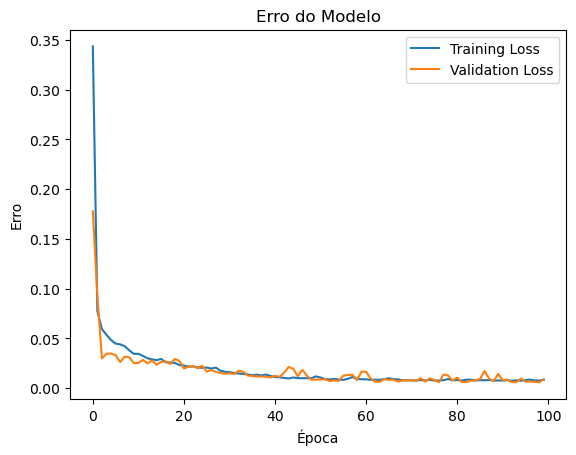

In [1726]:
# Estudo da validação
plt.plot(validation.history['loss'], label='Training Loss')
plt.plot(validation.history['val_loss'], label='Validation Loss')
plt.title('Erro do Modelo')
plt.ylabel('Erro')
plt.xlabel('Época')
plt.legend()
plt.show()

In [1727]:
# Realiza a previsão

prev = model.predict(X_test)
prev = scaler.inverse_transform(prev)

len_test = len(test)
len_prev = len(prev)

print(len_test, len_prev)

days_input_steps = len_test - steps
input_steps = test[days_input_steps:]
input_steps = np.array(input_steps).reshape(1, -1)
input_steps.shape

# Transformar em lista

list_output_steps = list(input_steps)
list_output_steps = list_output_steps[0].tolist()
list_output_steps

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
225 194


[1.1781678324878473,
 1.2944636196136776,
 1.2587324704908012,
 1.2734747765126022,
 1.2715791228995739,
 1.3188499331946657,
 1.2691500962066078,
 1.375806189945475,
 1.3414912819256135,
 1.3816506478872126,
 1.2551188357335037,
 1.0491109314362885,
 1.0216558690009847,
 0.9590693828571786,
 1.0166488830552007,
 0.9346495266771316,
 1.0442073887586663,
 0.8545627296661267,
 0.9112853666881668,
 0.983321728449009,
 1.0369357137434054,
 0.8343651724307409,
 0.7215209287801967,
 0.6292616295185279,
 0.7000937051065068,
 0.516477898600993,
 0.5945763667539274,
 0.6569122935892208,
 0.6316657989240794,
 0.6412838837904699]

In [1728]:
# loop para prever os proximos dias

pred_output = []
i = 0
n_future = best_window
while(i<n_future):
    if(len(list_output_steps)>steps):
        input_steps = np.array(list_output_steps[1:])
        print(f"{i} dia. Valores de Entrada -> {input_steps}")
        input_steps = input_steps.reshape(1, -1)
        input_steps = input_steps.reshape((1, steps, 1))
        pred = model.predict(input_steps, verbose=0)
        print(f"{i} dia. Valor Previsto -> {pred}")
        list_output_steps.extend(pred[0].tolist())
        list_output_steps = list_output_steps[1:]
        pred_output.extend(pred.tolist())
        i=i+1
    else:
        input_steps = input_steps.reshape((1, steps, 1))
        pred = model.predict(input_steps, verbose=0)
        print(pred[0])
        list_output_steps.extend(pred[0].tolist())
        print(len(list_output_steps))
        pred_output.extend(pred.tolist())
        i=i+1
print(f'Previsões -> {pred_output}')

[0.7527911]
31
1 dia. Valores de Entrada -> [1.29446362 1.25873247 1.27347478 1.27157912 1.31884993 1.2691501
 1.37580619 1.34149128 1.38165065 1.25511884 1.04911093 1.02165587
 0.95906938 1.01664888 0.93464953 1.04420739 0.85456273 0.91128537
 0.98332173 1.03693571 0.83436517 0.72152093 0.62926163 0.70009371
 0.5164779  0.59457637 0.65691229 0.6316658  0.64128388 0.75279111]
1 dia. Valor Previsto -> [[0.8465024]]
2 dia. Valores de Entrada -> [1.25873247 1.27347478 1.27157912 1.31884993 1.2691501  1.37580619
 1.34149128 1.38165065 1.25511884 1.04911093 1.02165587 0.95906938
 1.01664888 0.93464953 1.04420739 0.85456273 0.91128537 0.98332173
 1.03693571 0.83436517 0.72152093 0.62926163 0.70009371 0.5164779
 0.59457637 0.65691229 0.6316658  0.64128388 0.75279111 0.84650242]
2 dia. Valor Previsto -> [[0.9299151]]
3 dia. Valores de Entrada -> [1.27347478 1.27157912 1.31884993 1.2691501  1.37580619 1.34149128
 1.38165065 1.25511884 1.04911093 1.02165587 0.95906938 1.01664888
 0.93464953 1.04

In [1729]:
# Transforma a saída

prev = scaler.inverse_transform(pred_output)
prev = np.array(prev).reshape(1, -1)
list_output_prev = list(prev)
list_output_prev = prev[0].tolist()
list_output_prev

# Pegar as data de previsão

dates = pd.to_datetime(historical_returns.index)
predict_dates = pd.date_range(list(dates)[-1] + pd.DateOffset(1), periods=n_future, freq = 'b').tolist()
predict_dates

[Timestamp('2024-12-27 00:00:00'),
 Timestamp('2024-12-30 00:00:00'),
 Timestamp('2024-12-31 00:00:00'),
 Timestamp('2025-01-01 00:00:00'),
 Timestamp('2025-01-02 00:00:00'),
 Timestamp('2025-01-03 00:00:00'),
 Timestamp('2025-01-06 00:00:00'),
 Timestamp('2025-01-07 00:00:00'),
 Timestamp('2025-01-08 00:00:00'),
 Timestamp('2025-01-09 00:00:00'),
 Timestamp('2025-01-10 00:00:00'),
 Timestamp('2025-01-13 00:00:00'),
 Timestamp('2025-01-14 00:00:00'),
 Timestamp('2025-01-15 00:00:00'),
 Timestamp('2025-01-16 00:00:00'),
 Timestamp('2025-01-17 00:00:00'),
 Timestamp('2025-01-20 00:00:00'),
 Timestamp('2025-01-21 00:00:00'),
 Timestamp('2025-01-22 00:00:00'),
 Timestamp('2025-01-23 00:00:00'),
 Timestamp('2025-01-24 00:00:00'),
 Timestamp('2025-01-27 00:00:00'),
 Timestamp('2025-01-28 00:00:00'),
 Timestamp('2025-01-29 00:00:00'),
 Timestamp('2025-01-30 00:00:00'),
 Timestamp('2025-01-31 00:00:00'),
 Timestamp('2025-02-03 00:00:00'),
 Timestamp('2025-02-04 00:00:00'),
 Timestamp('2025-02-

In [1730]:
# Cria o dataframe de previsão

forecast_dates = []

for i in predict_dates:
    forecast_dates.append(i.date())

df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Saldo':list_output_prev})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

df_forecast = df_forecast.set_index(pd.DatetimeIndex(df_forecast['Date'].values))
df_forecast = df_forecast.drop('Date', axis=1)
df_forecast

Saldo
2024-12-27  142309.550758
2024-12-30  143703.718094
2024-12-31  144944.669481
2025-01-01  146161.589844
2025-01-02  147356.385705
...                   ...
2025-12-09  150966.863353
2025-12-10  150966.886408
2025-12-11  150966.902370
2025-12-12  150966.913011
2025-12-15  150966.920105

[252 rows x 1 columns]

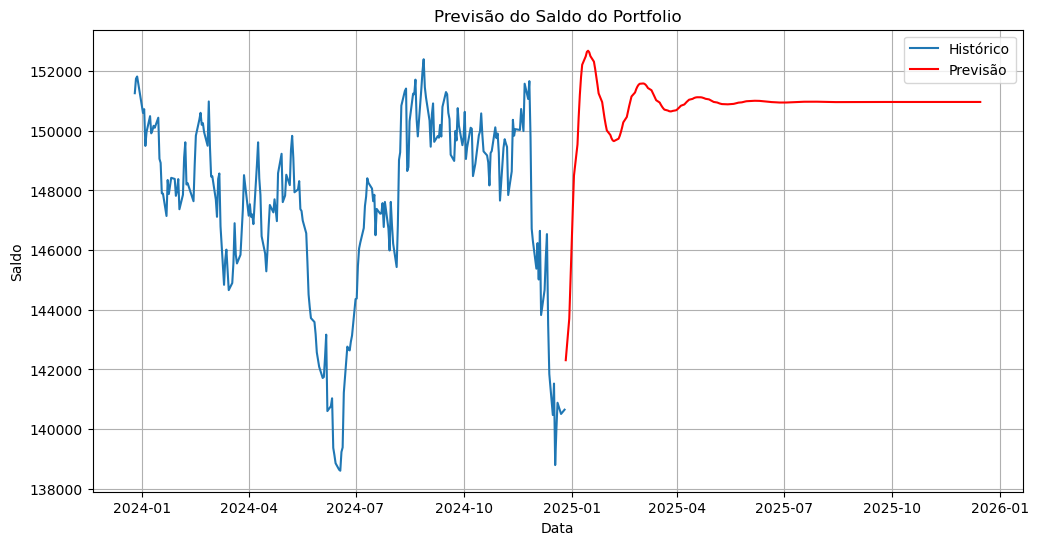

In [1731]:

# Plota o gráfico da previsão
plt.figure(figsize=(12, 6))
plt.plot(portfolio_balance.tail(best_window), label='Histórico')
plt.plot(df_forecast, label='Previsão', color='red')
plt.xlabel('Data')
plt.ylabel('Saldo')
plt.title('Previsão do Saldo do Portfolio')
plt.legend()
plt.grid(True)

# Encontra e plota os valores máximo e mínimo da previsão
#max_value = df_forecast['Saldo'].max()
#min_value = df_forecast['Saldo'].min()
#max_date = df_forecast['Saldo'].idxmax()
#min_date = df_forecast['Saldo'].idxmin()

#plt.scatter(max_date, max_value, color='green', label='Máximo', s=100)
#plt.scatter(min_date, min_value, color='red', label='Mínimo', s=100)

#plt.annotate(f'Máximo: {max_value:.2f}', (max_date, max_value), xytext=(10,10),
             #textcoords='offset points', arrowprops=dict(arrowstyle='->'))
#plt.annotate(f'Mínimo: {min_value:.2f}', (min_date, min_value), xytext=(-80,-20),
             #textcoords='offset points', arrowprops=dict(arrowstyle='->'))

#plt.fill_between(df_forecast.index, df_forecast['Saldo'], min_value, color='orange', alpha=0.3)

plt.legend()
plt.show()


## 6.3  Encontrar Distribuição Ótima do Portfolio

Restrições são condições que durante o processo de otimização precisam ser adereçadas

Nesse caso a restrição é o peso conjunto de todos os ativos, somando o valor igual a 1.

A variável restrição é um dicionário com duas chaves: 'type' e 'fun'

'type' é definido como 'eq', que significa restrição de equidade

'fun' é definido como função chamada check_sum, que vai checar se os pesos dos portfolios somam corretamente o valor '1'.

Bounds são os limites estabelecidos para as variáveis durante o processo de otimização. Nesse caso as variáveis são os pesos do portfolio, e cada peso deve ser entre 0 e 1.

In [1732]:
constraints = {'type':'eq','fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.5) for _ in range(len(portfolio))]

# Estabelece pesos iniciais

initial_weights = np.array([1/len(portfolio)]*len(portfolio))
print(initial_weights)

[0.2 0.2 0.2 0.2 0.2]


In [1733]:
# Otimiza os pesos para maximizar o indicador de Sharpe
# SLSQP é o nome para Sequential Least Squares Quadratic Programming, que é um técnica de otimização numérica muito útil para resolver problemas de otimização não lineares com restrições

optimized_results = minimize(negative_sharpe_ratio, initial_weights, 
                             args=(log_returns, cov_matrix, risk_free_rate), 
                             method='SLSQP', bounds=bounds, 
                             constraints=constraints)

# Estabelece os pesos ótimos para o portfolio

optimal_weights = optimized_results.x
print(optimal_weights)

[4.33162571e-01 3.74027096e-01 4.33247188e-16 1.92810333e-01
 0.00000000e+00]


## 6.4 Análise do Portfolio Ótimo

### Informação sobre o Portfólio Ótimo

In [1734]:
# Mostra informações do portfolio otimizado

print('Optimal Weights:')
for ticker, weight in zip(portfolio, optimal_weights):
    print(f'{ticker}: {weight:.4f}')
print()

optimal_portfolio_return = expected_returns(optimal_weights, log_returns)
print(f'Optimal Annual Return: {optimal_portfolio_return:.4f}')

optimal_portfolio_volatility = std_deviation(optimal_weights, cov_matrix)
print(f'Expected Volatility: {optimal_portfolio_volatility:.4f}')

optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)
print(f'Sharpe Ratio: {optimal_sharpe_ratio:.4f}')

Optimal Weights:
PETR4.SA: 0.4332
SBSP3.SA: 0.3740
RENT3.SA: 0.0000
ITUB4.SA: 0.1928
VALE3.SA: 0.0000

Optimal Annual Return: 0.3096
Expected Volatility: 0.2202
Sharpe Ratio: 1.4034


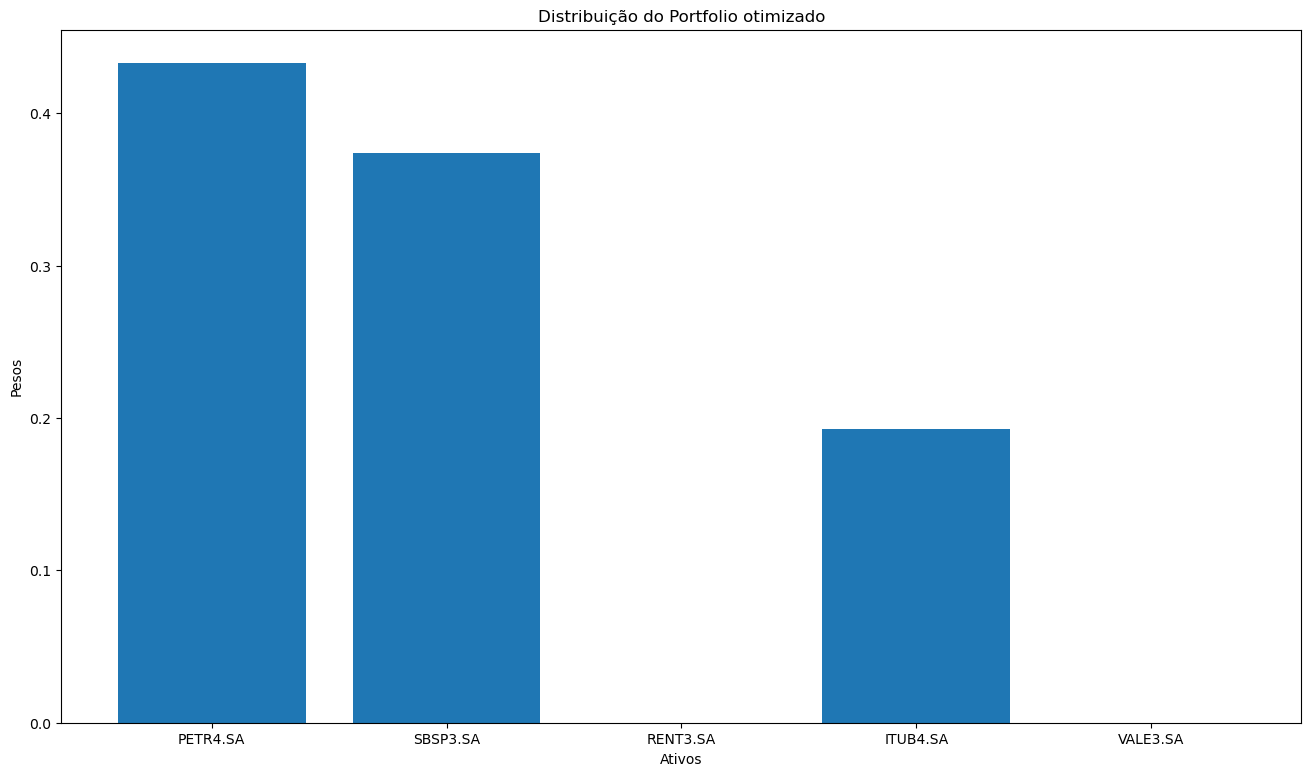

In [1735]:
# Plota em gráfico a distribuição do portfolio

plt.figure(figsize=(16,9))
plt.bar(portfolio, optimal_weights)
plt.xlabel('Ativos')
plt.ylabel('Pesos')
plt.title('Distribuição do Portfolio otimizado')
plt.show()

In [1736]:

# Calcula os retornos históricos ponderados pelo portfolio otimizado
historical_returns_optimized = (log_returns * optimal_weights).sum(axis=1)

# Transforma em uma série
historical_returns_optimized = pd.Series(historical_returns_optimized)

# Exibe os retornos históricos otimizados
print(historical_returns_optimized)


Date
2021-12-28    0.000000
2021-12-29   -0.007029
2021-12-30   -0.001478
2022-01-03    0.012738
2022-01-04   -0.003416
                ...   
2024-12-18   -0.028202
2024-12-19   -0.003723
2024-12-20   -0.003866
2024-12-23    0.003955
2024-12-26    0.004815
Length: 750, dtype: float64


### Encontrar o X-Day dos Retornos Históricos do Portfolio Ótimo

In [1737]:
# Especificar um intervalo de confiança
confidence_interval = 0.95
test_windows = [30, 60, 90, 180, 252]  # Diferentes janelas de dias


### Calcular o VaR (Value at Risk)


VaR para janela de 30 dias: R$ 8970.89


VaR para janela de 60 dias: R$ 8310.51


VaR para janela de 90 dias: R$ 8532.67


VaR para janela de 180 dias: R$ -3562.10


VaR para janela de 252 dias: R$ -11953.32


Resultados do VaR para diferentes janelas de tempo:

Janela de 30 dias: VaR = R$ 8970.89
Janela de 60 dias: VaR = R$ 8310.51
Janela de 90 dias: VaR = R$ 8532.67
Janela de 180 dias: VaR = R$ -3562.10
Janela de 252 dias: VaR = R$ -11953.32

Melhor janela de tempo: 252 dias com VaR = R$ -11953.32



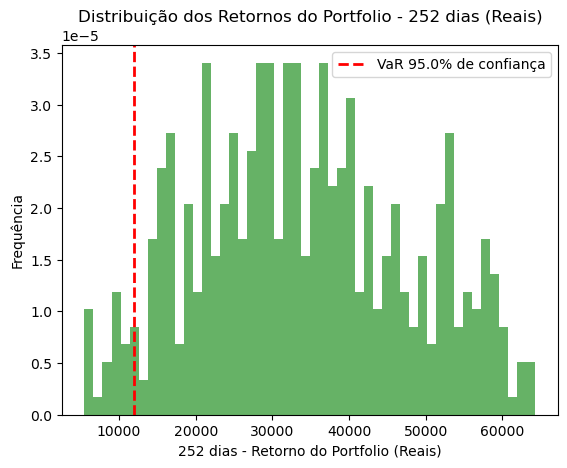

In [1738]:
# Lista para armazenar os resultados do VaR
test_windows_results_optimal = []

# Loop para calcular o VaR para cada janela de tempo
for window in test_windows:
    range_returns = historical_returns_optimized.rolling(window=window).sum().dropna()

    if range_returns.empty:
        print(f'Janela de {window} dias sem dados suficientes.')
        continue

    VaR = -np.percentile(range_returns, 100 - (confidence_interval * 100)) * portfolio_value
    test_windows_results_optimal.append((window, VaR))
    print(f'\nVaR para janela de {window} dias: R$ {VaR:.2f}\n')

# Mostrar todos os resultados armazenados em test_windows_results
print("\nResultados do VaR para diferentes janelas de tempo:\n")
for window, var in test_windows_results_optimal:
    print(f"Janela de {window} dias: VaR = R$ {var:.2f}")

# Encontrar o melhor valor de VaR (o menor, pois ele representa a perda máxima)
best_window_optimal, best_VaR_optimal = min(test_windows_results_optimal, key=lambda x: x[1])
print(f'\nMelhor janela de tempo: {best_window_optimal} dias com VaR = R$ {best_VaR_optimal:.2f}\n')

# Plotar o gráfico da distribuição dos retornos do portfólio com a melhor janela
range_returns_best_optimized = historical_returns_optimized.rolling(window=best_window_optimal).sum().dropna()
plt.hist(range_returns_best_optimized * portfolio_value, bins=50, density=True, alpha=0.6, color='g')
plt.axvline(-best_VaR_optimal, color='r', linestyle='dashed', linewidth=2, label=f'VaR {confidence_interval*100}% de confiança')
plt.xlabel(f'{best_window_optimal} dias - Retorno do Portfolio (Reais)')
plt.ylabel('Frequência')
plt.title(f'Distribuição dos Retornos do Portfolio - {best_window} dias (Reais)')
plt.legend()
plt.show()

### Backtesting

In [1739]:
# Escolha a melhor janela com base na análise anterior
# # Por exemplo, se a janela de 180 dias for a escolhida

backtesting_days = best_window  # Período de backtesting (1 ano)
violacoes_port_optimized = []

for i in range(backtesting_days, len(historical_returns_optimized)):
    # Calcular o VaR com os dados anteriores ao dia i
    janela_treino = historical_returns_optimized[i-backtesting_days:i]
    range_returns = janela_treino.rolling(window=best_window_optimal).sum().dropna()

    if range_returns.empty:
        print(f'Janela de {best_window_optimal} dias sem dados suficientes no índice {i}.')
        continue  # Pula a iteração se range_returns estiver vazio

    VaR = -np.percentile(range_returns, 100 - (confidence_interval * 100)) * portfolio_value

    # Comparar com o retorno real
    retorno_real = historical_returns_optimized.iloc[i] * portfolio_value
    if retorno_real < -VaR:
        violacoes_port_optimized.append(1)
    else:
        violacoes_port_optimized.append(0)

# Imprimir a taxa de violação observada
taxa_violacao_port_optimized = np.mean(violacoes_port_optimized)
print(f'Taxa de Violação do Portfólio Ótimo Observada: {taxa_violacao_port_optimized:.4f}')

Taxa de Violação do Portfólio Ótimo Observada: 1.0000


### Stress Test


VaR em cenário de stress (choque de 50.0%): R$ -5976.66




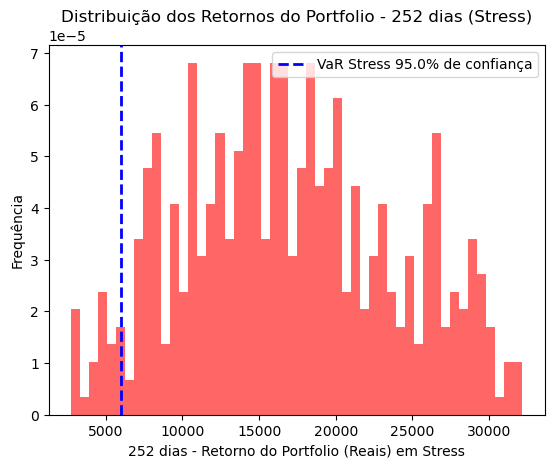

In [1740]:
# Parâmetros do Stress Test
shock_factor = 0.5  # Aplicando um choque de 50% nos retornos (simula uma queda acentuada)

# Simular cenário de stress aplicando um choque negativo nos retornos
stress_scenario_returns_optimal = historical_returns_optimized.copy()
stress_scenario_returns_optimal *= np.random.uniform(1 - shock_factor, 1 - shock_factor, size=len(stress_scenario_returns_optimal))

# Calcular os retornos acumulados no cenário de stress
range_returns_stress_optimal = stress_scenario_returns_optimal.rolling(window=best_window_optimal).sum().dropna()

# Calcular o VaR no cenário de stress
VaR_stress_optimal = -np.percentile(range_returns_stress_optimal, 100 - (confidence_interval * 100)) * portfolio_value

# Exibir o resultado do VaR em cenário de stress
print(f'\nVaR em cenário de stress (choque de {shock_factor*100}%): R$ {VaR_stress_optimal:.2f}\n\n')

# Visualizar a distribuição dos retornos no cenário de stress
plt.hist(range_returns_stress_optimal * portfolio_value, bins=50, density=True, alpha=0.6, color='r')
plt.axvline(-VaR_stress_optimal, color='b', linestyle='dashed', linewidth=2, label=f'VaR Stress {confidence_interval*100}% de confiança')
plt.xlabel(f'{best_window_optimal} dias - Retorno do Portfolio (Reais) em Stress')
plt.ylabel('Frequência')
plt.title(f'Distribuição dos Retornos do Portfolio - {best_window_optimal} dias (Stress)')
plt.legend()
plt.show()

### Análise dos Retornos do Portfolio Otimizado



Saldo atual do Portfolio Otimizado: R$ 192006.19
Saldo atual do CDI: R$ 134261.80
Saldo atual do IBOV: R$ 114376.66


Diferença Portfolio Otimizado vs. CDI: R$ 57744.39
Diferença Portfolio Otimizado vs. IBOV: R$ 77629.54



C:\Users\jeand\AppData\Local\Temp\ipykernel_37080\2555195098.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  saldo_atual_portfolio_optimal = portfolio_return_optimized[-1]
C:\Users\jeand\AppData\Local\Temp\ipykernel_37080\2555195098.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  saldo_atual_cdi = cdi_return[-1]
C:\Users\jeand\AppData\Local\Temp\ipykernel_37080\2555195098.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


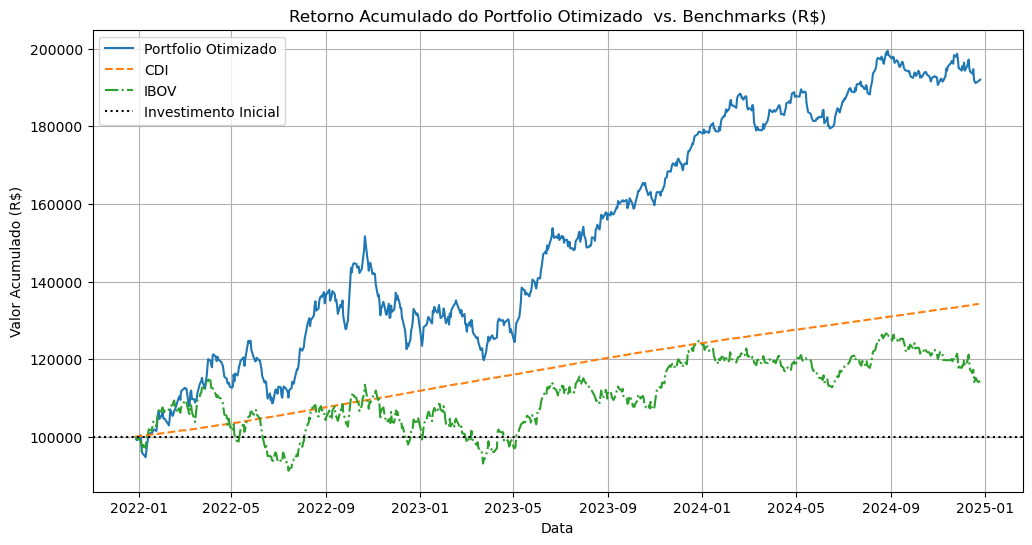

In [1741]:
# Calcula o retorno acumulado do portfolio
portfolio_return_optimized = (historical_returns_optimized.cumsum() + 1) * portfolio_value

# Calcula o retorno acumulado do CDI
cdi_return = (cdi['cdi'].cumsum() + 1) * portfolio_value

# Calcula o retorno acumulado do IBOV
ibov_return = (log_ibov['IBOV'].cumsum() + 1) * portfolio_value

# Obter os saldos atuais
saldo_atual_portfolio_optimal = portfolio_return_optimized[-1]
saldo_atual_cdi = cdi_return[-1]
saldo_atual_ibov = ibov_return[-1]

# Calcular as diferenças
diferenca_cdi_optimal = saldo_atual_portfolio_optimal - saldo_atual_cdi
diferenca_ibov_optimal = saldo_atual_portfolio_optimal - saldo_atual_ibov

# Imprimir os resultados
print('\n')
print(f"Saldo atual do Portfolio Otimizado: R$ {saldo_atual_portfolio_optimal:.2f}")
print(f"Saldo atual do CDI: R$ {saldo_atual_cdi:.2f}")
print(f"Saldo atual do IBOV: R$ {saldo_atual_ibov:.2f}\n")
print(f"\nDiferença Portfolio Otimizado vs. CDI: R$ {diferenca_cdi_optimal:.2f}")
print(f"Diferença Portfolio Otimizado vs. IBOV: R$ {diferenca_ibov_optimal:.2f}\n")

# Plota os retornos acumulados
plt.figure(figsize=(12, 6))
plt.plot(historical_returns_optimized.index, portfolio_return_optimized, label='Portfolio Otimizado')
plt.plot(cdi.index, cdi_return, label='CDI', linestyle='--')
plt.plot(log_ibov.index, ibov_return, label='IBOV', linestyle='-.')
plt.axhline(portfolio_value, color='k', linestyle=':', label='Investimento Inicial')
plt.title('Retorno Acumulado do Portfolio Otimizado  vs. Benchmarks (R$)')
plt.xlabel('Data')
plt.ylabel('Valor Acumulado (R$)')
plt.legend()
plt.grid(True)
plt.show()



In [1742]:
# Calcula as métricas para o portfolio
portfolio_mean_return_optimal = historical_returns_optimized.mean() * best_window  # Retorno médio anualizado
portfolio_std_dev_optimal = historical_returns_optimized.std() * np.sqrt(best_window)  # Desvio padrão anualizado
portfolio_sharpe_ratio_optimal = (portfolio_mean_return_optimal - risk_free_rate) / portfolio_std_dev_optimal  # Sharpe Ratio

# Calcula as métricas para o CDI
cdi_mean_return = cdi['cdi'].mean() * best_window
cdi_std_dev = cdi['cdi'].std() * np.sqrt(best_window)
cdi_sharpe_ratio = (cdi_mean_return - risk_free_rate) / cdi_std_dev  # Sharpe Ratio para o CDI (próximo de zero)

# Calcula as métricas para o IBOV
ibov_mean_return = log_ibov['IBOV'].mean() * best_window
ibov_std_dev = log_ibov['IBOV'].std() * np.sqrt(best_window)
ibov_sharpe_ratio = (ibov_mean_return - risk_free_rate) / ibov_std_dev

# Cria um DataFrame para exibir as métricas
metrics_df_optimal = pd.DataFrame({
    'Métrica': ['Retorno Médio Anualizado', 'Desvio Padrão Anualizado', 'Sharpe Ratio'],
    'Portfolio Ótimo': [portfolio_mean_return_optimal, portfolio_std_dev_optimal, portfolio_sharpe_ratio_optimal],
    'CDI': [cdi_mean_return, cdi_std_dev, cdi_sharpe_ratio],
    'IBOV': [ibov_mean_return, ibov_std_dev, ibov_sharpe_ratio]
})

# Exibe o DataFrame
print(metrics_df_optimal.to_string(index=False))


                 Métrica  Portfolio Ótimo        CDI     IBOV
Retorno Médio Anualizado         0.309141   0.114509 0.048370
Desvio Padrão Anualizado         0.220101   0.000788 0.173979
            Sharpe Ratio         1.402474 144.766572 0.275406


## 6.5 Previsão do Portfólio Ótimo

### Portfolio Ótimo - CAPM

In [1743]:
# Apaga primeira linha de historical_returns

historical_returns_optimized = historical_returns_optimized.iloc[1:]
historical_returns_optimized


Date
2021-12-29   -0.007029
2021-12-30   -0.001478
2022-01-03    0.012738
2022-01-04   -0.003416
2022-01-05   -0.037226
                ...   
2024-12-18   -0.028202
2024-12-19   -0.003723
2024-12-20   -0.003866
2024-12-23    0.003955
2024-12-26    0.004815
Length: 749, dtype: float64

In [1744]:
# Calcula o retorno médio do portfolio
portfolio_mean_return_optimal = historical_returns_optimized.mean() * best_window

# Calcula o retorno médio do IBOV
ibov_mean_return = log_ibov['IBOV'].mean() * best_window

# Calcula a covariância entre o portfolio e o IBOV
cov_portfolio_ibov_optimal = historical_returns_optimized.cov(log_ibov['IBOV']) * best_window

# Calcula a variância do IBOV
var_ibov = log_ibov['IBOV'].var() * best_window

# Calcula o beta do portfolio
beta_portfolio_optimal = cov_portfolio_ibov_optimal / var_ibov

# Calcula o retorno esperado do portfolio usando o CAPM
expected_return_capm_optimal = risk_free_rate + beta_portfolio_optimal * (ibov_mean_return - risk_free_rate)

# Calcula o alfa do portfolio
alpha_portfolio_optimal = portfolio_mean_return_optimal - expected_return_capm_optimal

# Imprime os resultados
print(f"Beta do Portfolio: {beta_portfolio_optimal:.4f}")
print(f"Retorno Esperado (CAPM): {expected_return_capm_optimal:.4f}")
print(f"Alfa do Portfolio: {alpha_portfolio_optimal:.4f}")


Beta do Portfolio: 0.9525
Retorno Esperado (CAPM): 0.0461
Alfa do Portfolio: 0.2635


Erro de Previsão do CAPM: 0.2635
R-quadrado do Modelo CAPM: 0.5661

Interpretação dos Resultados:
- Beta do Portfolio (0.9525): Indica que o portfolio ótimo é 0.95 vezes mais volátil que o IBOV.
- Alfa do Portfolio Ótimo (0.2635): Positivo, indicando que o portfolio ótimo gerou retornos acima do esperado pelo CAPM, sugerindo uma possível habilidade do gestor.
- R-quadrado do Modelo CAPM (0.5661): Indica que 56.61% da variância do retorno do portfolio ótimo é explicada pelo IBOV.


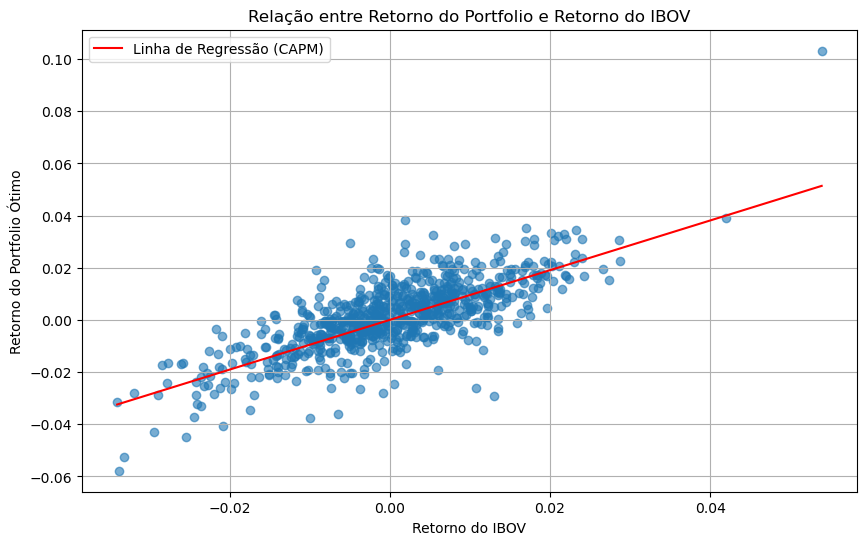

In [1745]:

# Calcula o erro de previsão do CAPM
capm_prediction_error_optimal = portfolio_mean_return_optimal - expected_return_capm_optimal

# Calcula o R-quadrado do modelo CAPM (quanto da variância do retorno do portfolio é explicada pelo IBOV)
r_squared_capm_optimal = (cov_portfolio_ibov_optimal ** 2) / (var_ibov * historical_returns_optimized.var() * best_window)

# Imprime os resultados adicionais
print(f"Erro de Previsão do CAPM: {capm_prediction_error_optimal:.4f}")
print(f"R-quadrado do Modelo CAPM: {r_squared_capm_optimal:.4f}")

# Interpretação dos resultados
print("\nInterpretação dos Resultados:")
print(f"- Beta do Portfolio ({beta_portfolio_optimal:.4f}): Indica que o portfolio ótimo é {beta_portfolio_optimal:.2f} vezes mais volátil que o IBOV.")
if alpha_portfolio > 0:
    print(f"- Alfa do Portfolio Ótimo ({alpha_portfolio_optimal:.4f}): Positivo, indicando que o portfolio ótimo gerou retornos acima do esperado pelo CAPM, sugerindo uma possível habilidade do gestor.")
elif alpha_portfolio < 0:
    print(f"- Alfa do Portfolio Ótimo ({alpha_portfolio_optimal:.4f}): Negativo, indicando que o portfolio ótimo gerou retornos abaixo do esperado pelo CAPM.")
else:
    print(f"- Alfa do Portfolio Ótimo ({alpha_portfolio_optimal:.4f}): Zero, indicando que o portfolio ótimo gerou retornos em linha com o esperado pelo CAPM.")
print(f"- R-quadrado do Modelo CAPM ({r_squared_capm_optimal:.4f}): Indica que {r_squared_capm_optimal*100:.2f}% da variância do retorno do portfolio ótimo é explicada pelo IBOV.")

# Visualização dos resultados
plt.figure(figsize=(10, 6))
plt.scatter(log_ibov['IBOV'], historical_returns_optimized, alpha=0.6)
plt.xlabel('Retorno do IBOV')
plt.ylabel('Retorno do Portfolio Ótimo')
plt.title('Relação entre Retorno do Portfolio e Retorno do IBOV')

# Adicionar a linha de regressão (CAPM)
x = np.linspace(log_ibov['IBOV'].min(), log_ibov['IBOV'].max(), 100)
y = risk_free_rate + beta_portfolio_optimal * (x - risk_free_rate)
plt.plot(x, y, color='red', label='Linha de Regressão (CAPM)')

plt.legend()
plt.grid(True)
plt.show()

### Portfolio Ótimo - Regressão Linear

In [1746]:
df_modelagem_otima = log_returns.copy()

In [1747]:

# Transforma historical_returns_optimized em um DataFrame
df_historical_returns_optimized = pd.DataFrame(historical_returns_optimized, columns=['returns'])

# Exibe o DataFrame
print(df_historical_returns_optimized.head())


             returns
Date                
2021-12-29 -0.007029
2021-12-30 -0.001478
2022-01-03  0.012738
2022-01-04 -0.003416
2022-01-05 -0.037226


In [1748]:
# Junta a df_modelagem, o cdi, e ibov, usando o index de date de df_modelagem como base
df_modelagem_otima = df_modelagem_otima.join(cdi, how='left').join(log_ibov, how='left')
df_modelagem_otima = df_modelagem_otima.join(df_historical_returns_optimized, how = 'left')
df_modelagem_otima.dropna(inplace=True)

In [1749]:
df_modelagem_otima

PETR4.SA  SBSP3.SA  RENT3.SA  ITUB4.SA  VALE3.SA       cdi  \
Date                                                                     
2021-12-29 -0.008374 -0.004757 -0.027451 -0.008415  0.002592  0.000347   
2021-12-30 -0.003158  0.008247  0.017127 -0.016569  0.009149  0.000347   
2022-01-03  0.022246 -0.005741 -0.040626  0.027222  0.000513  0.000347   
2022-01-04  0.003774 -0.027921  0.005682  0.027964 -0.011865  0.000347   
2022-01-05 -0.039467 -0.043937 -0.029344 -0.019170  0.009426  0.000347   
...              ...       ...       ...       ...       ...       ...   
2024-12-17  0.009444  0.017707  0.015189  0.005347  0.005003  0.000455   
2024-12-18 -0.026188 -0.030144 -0.027851 -0.028960 -0.023441  0.000455   
2024-12-19 -0.004029 -0.008110  0.083916  0.005474 -0.019157  0.000455   
2024-12-20 -0.008377 -0.006559  0.034127  0.011494  0.015684  0.000455   
2024-12-23  0.000271  0.020341 -0.024040 -0.019555  0.004202  0.000455   

                IBOV   returns  
Date                            
2021-12-29 -0.007245 -0.007029  
2021-12-30  0.006844 -0.001478  
2022-01-03 -0.008623  0.012738  
2022-01-04 -0.003934 -0.003416  
2022-01-05 -0.024527 -0.037226  
...              ...       ...  
2024-12-17  0.009168  0.011745  
2024-12-18 -0.031990 -0.028202  
2024-12-19  0.003439 -0.003723  
2024-12-20  0.007514 -0.003866  
2024-12-23 -0.010994  0.003955  

[748 rows x 8 columns]

In [1750]:
df_modelagem_otima.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 748 entries, 2021-12-29 to 2024-12-23
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PETR4.SA  748 non-null    float64
 1   SBSP3.SA  748 non-null    float64
 2   RENT3.SA  748 non-null    float64
 3   ITUB4.SA  748 non-null    float64
 4   VALE3.SA  748 non-null    float64
 5   cdi       748 non-null    float64
 6   IBOV      748 non-null    float64
 7   returns   748 non-null    float64
dtypes: float64(8)
memory usage: 52.6 KB


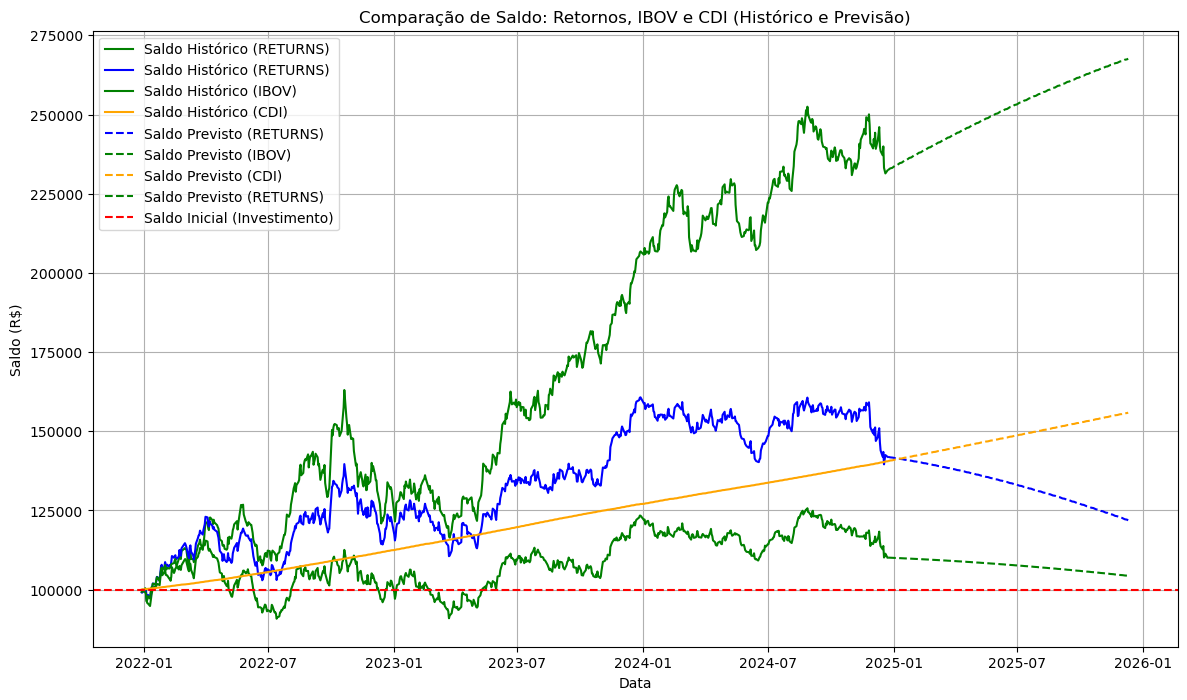


Métricas para RETURNS:
  - MSE: 0.000192
  - MAE: 0.010315
  - R²: 0.000437


In [1751]:
# Previsão Retornos

# Criando uma coluna ordinal para as datas no DataFrame
df_modelagem_otima['Date_ordinal'] = df_modelagem_otima.index.map(lambda x: x.toordinal())

# Executando regressão linear para retornos, IBOV e CDI
resultados_optimal = {}
for coluna in ['returns', 'IBOV', 'cdi']:
    resultados_optimal[coluna] = regressao_linear(df_modelagem_otima, coluna, best_window=best_window)

# Calculando saldo acumulado histórico e futuro para cada série
saldos_optimal = {'historico': {}, 'futuro': {}}
for coluna in ['returns']:
    # Saldo histórico
    saldo_historico_optimal = [valor_investido]
    for retorno in df_modelagem_otima[coluna]:
        saldo_historico_optimal.append(saldo_historico_optimal[-1] * (1 + retorno))
    saldos_optimal['historico'][coluna] = saldo_historico_optimal[1:]
    
    # Saldo futuro
    saldo_futuro_optimal = [saldos_optimal['historico'][coluna][-1]]
    for retorno in resultados_optimal[coluna]['previsoes_futuras']:
        saldo_futuro_optimal.append(saldo_futuro_optimal[-1] * (1 + retorno))
    saldos_optimal['futuro'][coluna] = saldo_futuro_optimal[1:]

# Plotando os resultados
plt.figure(figsize=(14, 8))

# Histórico
for coluna, cor in zip(['returns'], [ 'green']):
    plt.plot(df_modelagem_otima.index, saldos_optimal['historico'][coluna], label=f'Saldo Histórico ({coluna.upper()})', color=cor)

# Histórico
for coluna, cor in zip(['returns', 'IBOV', 'cdi'], ['blue', 'green', 'orange']):
    plt.plot(df_modelagem.index, saldos['historico'][coluna], label=f'Saldo Histórico ({coluna.upper()})', color=cor)

# Futuro
for coluna, cor in zip(['returns', 'IBOV', 'cdi'], ['blue', 'green', 'orange']):
    plt.plot(resultados[coluna]['datas_futuras'], saldos['futuro'][coluna], linestyle='--', label=f'Saldo Previsto ({coluna.upper()})', color=cor)

# Futuro
for coluna, cor in zip(['returns'], ['green']):
    plt.plot(resultados[coluna]['datas_futuras'], saldos_optimal['futuro'][coluna], linestyle='--', label=f'Saldo Previsto ({coluna.upper()})', color=cor)

# Linha do investimento inicial
plt.axhline(y=valor_investido, color='red', linestyle='--', label='Saldo Inicial (Investimento)')

# Configurações do gráfico
plt.xlabel('Data')
plt.ylabel('Saldo (R$)')
plt.title('Comparação de Saldo: Retornos, IBOV e CDI (Histórico e Previsão)')
plt.legend()
plt.grid(True)
plt.show()

# Métricas da regressão
for coluna in ['returns']:
    print(f"\nMétricas para {coluna.upper()}:")
    print(f"  - MSE: {resultados_optimal[coluna]['mse']:.6f}")
    print(f"  - MAE: {resultados_optimal[coluna]['mae']:.6f}")
    print(f"  - R²: {resultados_optimal[coluna]['r2']:.6f}")
    

### Previsão do Portfólio Ótimo - ARIMA

<class 'pandas.core.series.Series'>
Date
2021-12-29     99297.110720
2021-12-30     99149.305617
2022-01-03    100423.074926
2022-01-04    100081.439507
2022-01-05     96358.876413
                  ...      
2024-12-18    191888.033203
2024-12-19    191515.739627
2024-12-20    191129.166637
2024-12-23    191524.699523
2024-12-26    192006.191557
Length: 749, dtype: float64


<Axes: xlabel='Date'>

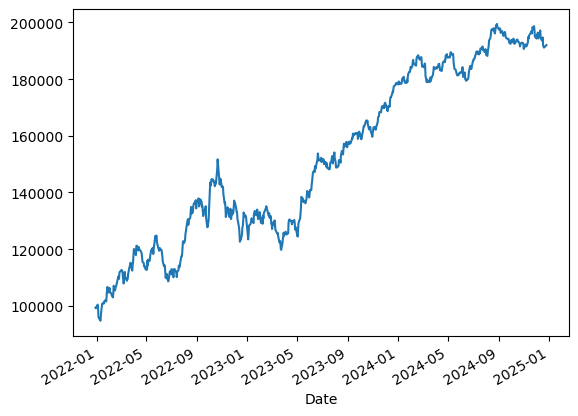

In [1752]:
# Calcula o retorno acumulado do portfolio
portfolio_return_optimized = (historical_returns_optimized.cumsum() + 1) * portfolio_value
print(type(portfolio_return_optimized))
print(portfolio_return_optimized)
portfolio_return_optimized.plot()

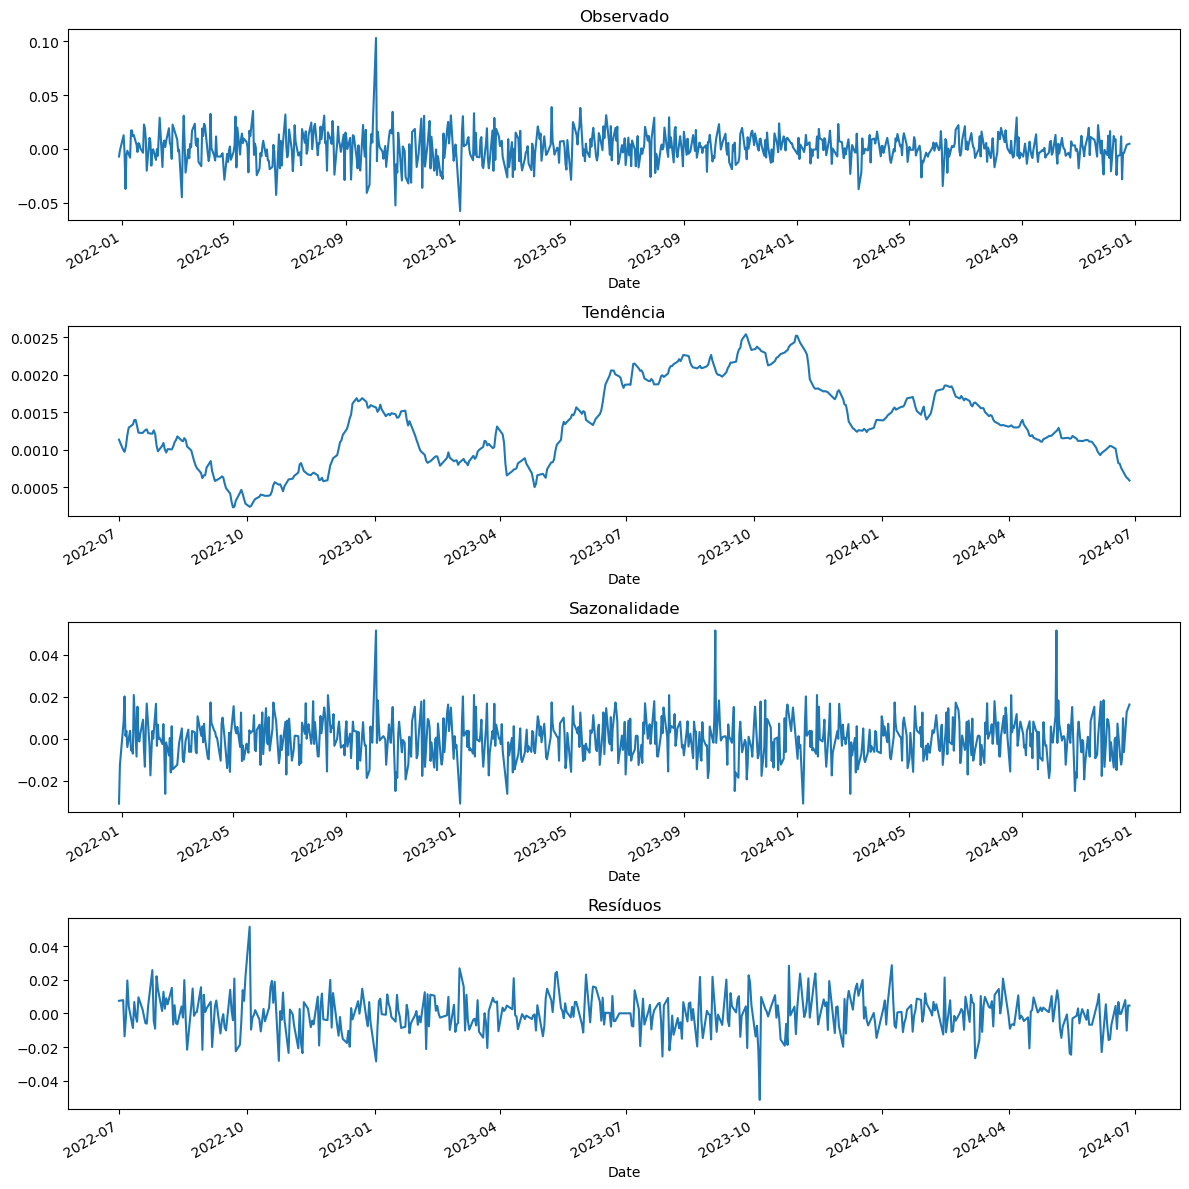

In [1753]:
# análise dos retornos

# fazendo a decomposição
decomposition_optimal = seasonal_decompose(historical_returns_optimized.dropna(), model='additive', period=best_window)

# Plotar a decomposição
fig, axes = plt.subplots(4, 1, figsize=(12, 12))
decomposition_optimal.observed.plot(ax=axes[0], title='Observado')
decomposition_optimal.trend.plot(ax=axes[1], title='Tendência')
decomposition_optimal.seasonal.plot(ax=axes[2], title='Sazonalidade')
decomposition_optimal.resid.plot(ax=axes[3], title='Resíduos')
plt.tight_layout()
plt.show()

In [1754]:
# Teste de normalidade dos resíduos (Shapiro-Wilk)
statistic_optimal, p_value_optimal = shapiro(decomposition_optimal.resid.dropna())
print(f'\nTeste de Shapiro-Wilk para retornos do portfolio: Estatística={statistic_optimal:.3f}, p-valor={p_value_optimal:.3f}')
if p_value_optimal > 0.05:
    print('Provavelmente normal')
else:
    print('Provavelmente não normal')


Teste de Shapiro-Wilk para retornos do portfolio: Estatística=0.983, p-valor=0.000
Provavelmente não normal


In [1755]:
# Teste de estacionariedade (Dickey-Fuller Aumentado)
result_adfuller_optimal = adfuller(historical_returns_optimized.dropna())
print(f'\nTeste de Dickey-Fuller Aumentado para retornos do portfolio:')
print('ADF Statistic: %f' % result_adfuller_optimal[0])
print('p-value: %f' % result_adfuller_optimal[1])
print('Critical Values:')
for key, value in result_adfuller_optimal[4].items():
    print('\t%s: %.3f' % (key, value))
if result_adfuller_optimal[1] <= 0.05:
    print('Série provavelmente estacionária\n')
else:
    print('Série provavelmente não estacionária\n')


Teste de Dickey-Fuller Aumentado para retornos do portfolio:
ADF Statistic: -25.672326
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
Série provavelmente estacionária



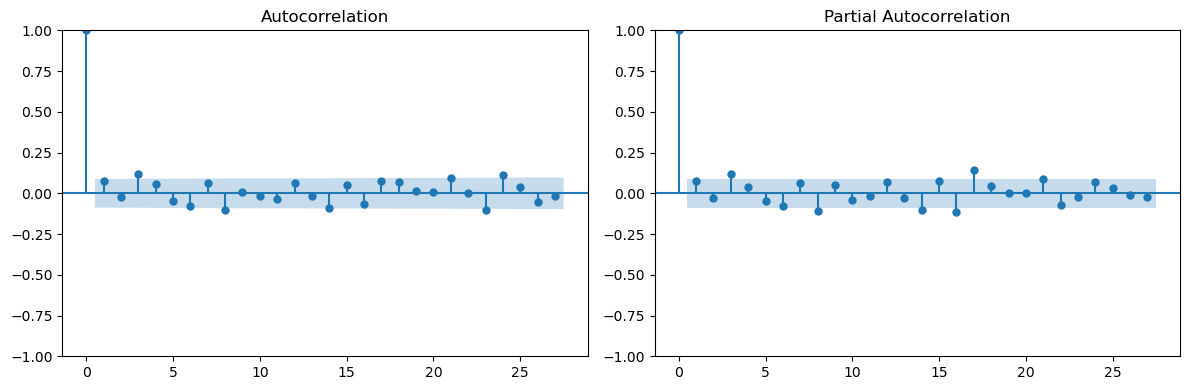

In [1756]:
# Autocorrelação e Autocorrelação Parcial dos resíduos
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(decomposition_optimal.resid.dropna(), ax=axes[0])
plot_pacf(decomposition_optimal.resid.dropna(), ax=axes[1])
plt.tight_layout()
plt.show()


In [1757]:
# Ajustar o modelo Auto-ARIMA
modelo_auto_arima_optimal = auto_arima(historical_returns_optimized,
                               start_p=1, start_q=1,
                               max_p=10, max_q=10,
                               d=0,  # Determina d automaticamente
                               seasonal=True,  # Ajuste conforme necessidade
                               trace=True,
                               error_action='ignore',
                               suppress_warnings=True,
                               stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-4278.530, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-4279.457, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-4280.345, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-4280.414, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-4275.601, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-4278.443, Time=0.35 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-4276.431, Time=0.48 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-4277.249, Time=0.07 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 1.996 seconds


In [1758]:
print(modelo_auto_arima_optimal.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  749
Model:               SARIMAX(0, 0, 1)   Log Likelihood                2143.207
Date:                Thu, 26 Dec 2024   AIC                          -4280.414
Time:                        23:16:08   BIC                          -4266.557
Sample:                             0   HQIC                         -4275.074
                                - 749                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0012      0.001      2.239      0.025       0.000       0.002
ma.L1          0.0630      0.032      1.944      0.052      -0.001       0.127
sigma2         0.0002   6.01e-06     31.838      0.0

In [1759]:
# Dividir os dados em treino e teste (80% treino, 20% teste)
train_size = int(len(portfolio_return_optimized) * 0.8)
train_data_optimal, test_data_optimal = portfolio_return_optimized[:train_size], portfolio_return_optimized[train_size:]

# Imprimir os shapes dos conjuntos de treino e teste
print("Shape dos dados de treino:", train_data_optimal.shape)
print("Shape dos dados de teste:", test_data_optimal.shape)


Shape dos dados de treino: (599,)
Shape dos dados de teste: (150,)


In [1760]:
model_optimal = ARIMA(train_data_optimal, order=(9,1,10))
result_optimal = model_optimal.fit()
result_optimal.summary()

c:\Users\jeand\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jeand\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jeand\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jeand\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  599
Model:                ARIMA(9, 1, 10)   Log Likelihood               -5203.170
Date:                Thu, 26 Dec 2024   AIC                          10446.341
Time:                        23:16:14   BIC                          10534.213
Sample:                             0   HQIC                         10480.553
                                - 599                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0393      2.649      0.015      0.988      -5.153       5.231
ar.L2         -0.2944      1.103     -0.267      0.790      -2.456       1.868
ar.L3         -0.5794      1.363     -0.425      0.671      -3.250       2.091
ar.L4         -0.0451      2.249     -0.020      0.984      -4.453       4.363
ar.L5         -0.7290      1.148     -0.635      0.525      -2.979       1.521
ar.L6          0.0004      2.435      0.000      1.000      -4.773       4.774
ar.L7         -0.0903      1.116     -0.081      0.936      -2.278       2.098
ar.L8         -0.6146      0.855     -0.719      0.472      -2.289       1.060
ar.L9          0.3596      2.106      0.171      0.864      -3.767       4.486
ma.L1         -0.0263      2.651     -0.010      0.992      -5.223       5.171
ma.L2          0.3123      1.120      0.279      0.780      -1.883       2.508
ma.L3          0.5859      1.435      0.408      0.683      -2.227       3.399
ma.L4          0.0378      2.294      0.016      0.987      -4.458       4.533
ma.L5          0.7292      1.150      0.634      0.526      -1.526       2.984
ma.L6         -0.0100      2.457     -0.004      0.997      -4.825       4.805
ma.L7          0.0916      1.095      0.084      0.933      -2.054       2.237
ma.L8          0.6080      0.858      0.708      0.479      -1.075       2.291
ma.L9         -0.3551      2.091     -0.170      0.865      -4.453       3.742
ma.L10        -0.0118      0.038     -0.313      0.755      -0.086       0.062
sigma2      2.146e+06    5.6e-05   3.83e+10      0.000    2.15e+06    2.15e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.01   Jarque-Bera (JB):               383.47
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.23e+26. Standard errors may be unstable.
"""

In [1761]:
# Realizar previsões no conjunto de teste
predictions_test_optimal = result_optimal.get_forecast(steps=len(test_data))
pred_conf_int_optimal = predictions_test_optimal.conf_int()
predicted_mean_optimal = predictions_test_optimal.predicted_mean

c:\Users\jeand\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\jeand\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [1762]:
# Prever 60 dias no futuro
forecast_steps = best_window
forecast_optimal = result_optimal.get_forecast(steps=forecast_steps)
forecast_conf_int_optimal = forecast_optimal.conf_int()
forecast_mean_optimal = forecast_optimal.predicted_mean

c:\Users\jeand\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


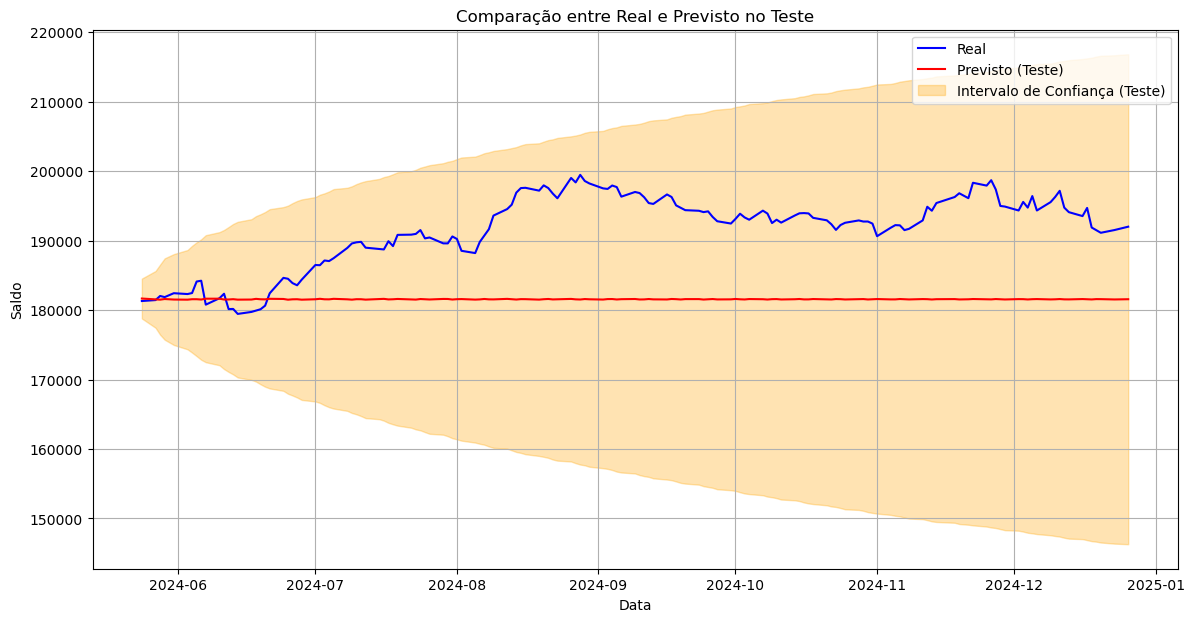

In [1763]:
# Plotar gráficos

# Gráfico de comparação do teste
plt.figure(figsize=(14, 7))
#plt.plot(portfolio_return.index[:len(train_data)].index, train_data, label ="Treino", color = 'green')
plt.plot(portfolio_return_optimized.index[-len(test_data_optimal):], test_data_optimal, label='Real', color='blue')
plt.plot(portfolio_return_optimized.index[-len(test_data_optimal):], predicted_mean_optimal, label='Previsto (Teste)', color='red')
plt.fill_between(portfolio_return_optimized.index[-len(test_data_optimal):], pred_conf_int_optimal.iloc[:, 0], pred_conf_int_optimal.iloc[:, 1], color='orange', alpha=0.3, label='Intervalo de Confiança (Teste)')
plt.xlabel('Data')
plt.ylabel('Saldo')
plt.title('Comparação entre Real e Previsto no Teste')
plt.legend()
plt.grid(True)
plt.show()

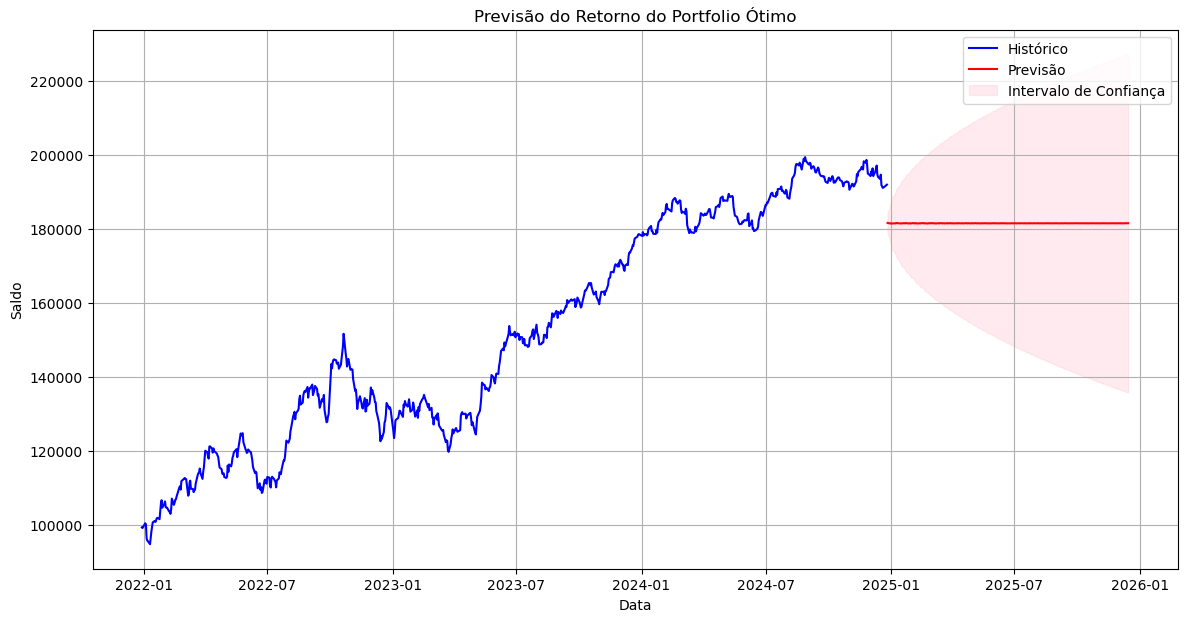

In [1764]:
# Criar um índice de datas para a previsão
last_date = portfolio_return_optimized.index[-1]
forecast_index = pd.date_range(start=last_date + timedelta(days=1), periods=forecast_steps, freq='B')  # 'B' para dias úteis

# Plotar o gráfico da previsão
plt.figure(figsize=(14, 7))
plt.plot(portfolio_return_optimized.index, portfolio_return_optimized, label='Histórico', color='blue')
plt.plot(forecast_index, forecast_mean_optimal, label='Previsão', color='red')
plt.fill_between(forecast_index, forecast_conf_int_optimal.iloc[:, 0], forecast_conf_int_optimal.iloc[:, 1], color='pink', alpha=0.3, label='Intervalo de Confiança')
plt.xlabel('Data')
plt.ylabel('Saldo')
plt.title('Previsão do Retorno do Portfolio Ótimo')
plt.legend()
plt.grid(True)
plt.show()


### Previsão do Portfolio Ótimo - LSTM

In [1765]:
# Calcula o retorno acumulado do portfolio
portfolio_return_optimal = (historical_returns_optimized.cumsum() + 1) * portfolio_value

# Cria um DataFrame com o saldo do portfolio por dia
portfolio_balance_optimal = pd.DataFrame({
    'Saldo': portfolio_return_optimal
})

# Exibe o DataFrame
print(portfolio_balance_optimal)


                    Saldo
Date                     
2021-12-29   99297.110720
2021-12-30   99149.305617
2022-01-03  100423.074926
2022-01-04  100081.439507
2022-01-05   96358.876413
...                   ...
2024-12-18  191888.033203
2024-12-19  191515.739627
2024-12-20  191129.166637
2024-12-23  191524.699523
2024-12-26  192006.191557

[749 rows x 1 columns]


In [1766]:
# Separa linhas de treino e teste
qtd_linhas = len(portfolio_balance_optimal)
qtd_linhas_treino = round(qtd_linhas * 0.7)
qtd_linhas_teste = qtd_linhas - qtd_linhas_treino

info_treino = f'Quantidade de linhas de treino: {qtd_linhas_treino}'
info_teste = f'Quantidade de linhas de teste: {qtd_linhas_teste}'

print(info_treino)
print(info_teste)

Quantidade de linhas de treino: 524
Quantidade de linhas de teste: 225


In [1767]:
# Padroniza os dados
scaler = StandardScaler()
df_scaled_optimal = scaler.fit_transform(portfolio_balance_optimal)

In [1768]:
# Separa os dados em treino e teste
train_optimal = df_scaled_optimal[:qtd_linhas_treino]
test_optimal = df_scaled_optimal[qtd_linhas_treino: qtd_linhas_treino + qtd_linhas_teste]

print(len(train) , len(test))

524 225


In [1769]:
# Define numero de dias necessários para realizar a previsão do próximo dia
steps = 30

X_train_optimal, Y_train_optimal = create_df(train_optimal, steps )
X_test_optimal, Y_test_optimal = create_df(test_optimal, steps )

print(X_train_optimal.shape)
print(Y_train_optimal.shape)
print(X_test_optimal.shape)
print(Y_test_optimal.shape)

(493, 30)
(493,)
(194, 30)
(194,)


In [1770]:
# Gerando os dados esperados pelo modelo

X_train_optimal = X_train_optimal.reshape(X_train_optimal.shape[0], X_train_optimal.shape[1], 1)
X_test_optimal = X_test_optimal.reshape(X_test_optimal.shape[0], X_test_optimal.shape[1], 1)

print(X_train_optimal.shape)
print(X_test_optimal.shape)

(493, 30, 1)
(194, 30, 1)


In [1771]:
# Montando a rede

model_LSTM_optimal = Sequential()
model_LSTM_optimal.add(LSTM(35, return_sequences=True, input_shape=(steps, 1)))
model_LSTM_optimal.add(LSTM(35, return_sequences=True))
model_LSTM_optimal.add(LSTM(35))
model_LSTM_optimal.add(Dropout(0.2))
model_LSTM_optimal.add(Dense(1))
model_LSTM_optimal.compile(loss='mse', optimizer='adam')

model_LSTM_optimal.summary()

c:\Users\jeand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_42 (LSTM)                  │ (None, 30, 35)         │         5,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ (None, 30, 35)         │         9,940 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_44 (LSTM)                  │ (None, 35)             │         9,940 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 35)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,096 (98.03 KB)

 Trainable params: 25,096 (98.03 KB)

 Non-trainable params: 0 (0.00 B)

In [1772]:
# Treinamento do Modelo

validation_optimal = model_LSTM_optimal.fit(X_train_optimal, Y_train_optimal, validation_data=(X_test_optimal, Y_test_optimal), epochs=50, batch_size=steps, verbose=2)

Epoch 1/50
17/17 - 7s - 416ms/step - loss: 0.1466 - val_loss: 0.1256
Epoch 2/50
17/17 - 0s - 18ms/step - loss: 0.0420 - val_loss: 0.0317
Epoch 3/50
17/17 - 0s - 17ms/step - loss: 0.0342 - val_loss: 0.0932
Epoch 4/50
17/17 - 0s - 19ms/step - loss: 0.0298 - val_loss: 0.0312
Epoch 5/50
17/17 - 0s - 17ms/step - loss: 0.0321 - val_loss: 0.0441
Epoch 6/50
17/17 - 0s - 18ms/step - loss: 0.0270 - val_loss: 0.0206
Epoch 7/50
17/17 - 0s - 17ms/step - loss: 0.0274 - val_loss: 0.0125
Epoch 8/50
17/17 - 0s - 17ms/step - loss: 0.0255 - val_loss: 0.0110
Epoch 9/50
17/17 - 0s - 16ms/step - loss: 0.0254 - val_loss: 0.0285
Epoch 10/50
17/17 - 0s - 18ms/step - loss: 0.0239 - val_loss: 0.0114
Epoch 11/50
17/17 - 0s - 17ms/step - loss: 0.0254 - val_loss: 0.0127
Epoch 12/50
17/17 - 0s - 16ms/step - loss: 0.0224 - val_loss: 0.0122
Epoch 13/50
17/17 - 0s - 16ms/step - loss: 0.0221 - val_loss: 0.0113
Epoch 14/50
17/17 - 0s - 18ms/step - loss: 0.0230 - val_loss: 0.0102
Epoch 15/50
17/17 - 0s - 22ms/step - loss:

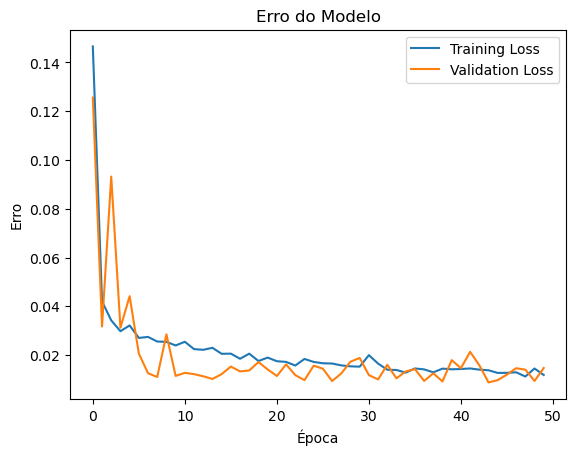

In [1773]:
plt.plot(validation_optimal.history['loss'], label='Training Loss')
plt.plot(validation_optimal.history['val_loss'], label='Validation Loss')
plt.title('Erro do Modelo')
plt.ylabel('Erro')
plt.xlabel('Época')
plt.legend()
plt.show()

In [1774]:
# Realiza a previsão

prev_optimal = model_LSTM_optimal.predict(X_test_optimal)
prev_optimal = scaler.inverse_transform(prev_optimal)

len_test = len(test_optimal)
len_prev = len(prev_optimal)

print(len_test, len_prev)

days_input_steps = len_test - steps
input_steps = test_optimal[days_input_steps:]
input_steps = np.array(input_steps).reshape(1, -1)
input_steps.shape

# Transformar em lista

list_output_steps = list(input_steps)
list_output_steps = list_output_steps[0].tolist()
list_output_steps

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
225 194


[1.3462991138173512,
 1.4111626660721324,
 1.3922706112175796,
 1.4288932008952877,
 1.4574198246402705,
 1.4753281305551478,
 1.4518793939929289,
 1.5251927358245503,
 1.5117304336195494,
 1.5373764614350325,
 1.4932986816937373,
 1.4150100476330063,
 1.4120765056903861,
 1.3934068641514021,
 1.4340850143458495,
 1.4071126845601185,
 1.461965773800224,
 1.393377141190566,
 1.43315390748915,
 1.4575893201548502,
 1.4870038866769013,
 1.4070535262640833,
 1.3855154734823778,
 1.366834992367048,
 1.4056079064613287,
 1.3125035719008107,
 1.3002130152342393,
 1.2874510511861847,
 1.300508808980031,
 1.3164043427753291]

In [1775]:
# loop para prever os proximos dias

pred_output_optimal = []
i = 0
n_future = best_window
while(i<n_future):
    if(len(list_output_steps)>steps):
        input_steps = np.array(list_output_steps[1:])
        print(f"{i} dia. Valores de Entrada -> {input_steps}")
        input_steps = input_steps.reshape(1, -1)
        input_steps = input_steps.reshape((1, steps, 1))
        pred = model.predict(input_steps, verbose=0)
        print(f"{i} dia. Valor Previsto -> {pred}")
        list_output_steps.extend(pred[0].tolist())
        list_output_steps = list_output_steps[1:]
        pred_output_optimal.extend(pred.tolist())
        i=i+1
    else:
        input_steps = input_steps.reshape((1, steps, 1))
        pred = model_LSTM_optimal.predict(input_steps, verbose=0)
        print(pred[0])
        list_output_steps.extend(pred[0].tolist())
        print(len(list_output_steps))
        pred_output_optimal.extend(pred.tolist())
        i=i+1
print(f'Previsões -> {pred_output_optimal}')

[1.2769713]
31
1 dia. Valores de Entrada -> [1.41116267 1.39227061 1.4288932  1.45741982 1.47532813 1.45187939
 1.52519274 1.51173043 1.53737646 1.49329868 1.41501005 1.41207651
 1.39340686 1.43408501 1.40711268 1.46196577 1.39337714 1.43315391
 1.45758932 1.48700389 1.40705353 1.38551547 1.36683499 1.40560791
 1.31250357 1.30021302 1.28745105 1.30050881 1.31640434 1.27697134]
1 dia. Valor Previsto -> [[1.2818434]]
2 dia. Valores de Entrada -> [1.39227061 1.4288932  1.45741982 1.47532813 1.45187939 1.52519274
 1.51173043 1.53737646 1.49329868 1.41501005 1.41207651 1.39340686
 1.43408501 1.40711268 1.46196577 1.39337714 1.43315391 1.45758932
 1.48700389 1.40705353 1.38551547 1.36683499 1.40560791 1.31250357
 1.30021302 1.28745105 1.30050881 1.31640434 1.27697134 1.28184342]
2 dia. Valor Previsto -> [[1.279135]]
3 dia. Valores de Entrada -> [1.4288932  1.45741982 1.47532813 1.45187939 1.52519274 1.51173043
 1.53737646 1.49329868 1.41501005 1.41207651 1.39340686 1.43408501
 1.40711268 1.4

In [1776]:
# Transforma a saída

prev_optimal = scaler.inverse_transform(pred_output_optimal)
prev_optimal = np.array(prev_optimal).reshape(1, -1)
list_output_prev_optimal = list(prev_optimal)
list_output_prev_optimal = prev_optimal[0].tolist()
list_output_prev_optimal

# Pegar as data de previsão

dates_optimal = pd.to_datetime(historical_returns_optimized.index)
predict_dates_optimal = pd.date_range(list(dates_optimal)[-1] + pd.DateOffset(1), periods=n_future, freq = 'b').tolist()
predict_dates_optimal

[Timestamp('2024-12-27 00:00:00'),
 Timestamp('2024-12-30 00:00:00'),
 Timestamp('2024-12-31 00:00:00'),
 Timestamp('2025-01-01 00:00:00'),
 Timestamp('2025-01-02 00:00:00'),
 Timestamp('2025-01-03 00:00:00'),
 Timestamp('2025-01-06 00:00:00'),
 Timestamp('2025-01-07 00:00:00'),
 Timestamp('2025-01-08 00:00:00'),
 Timestamp('2025-01-09 00:00:00'),
 Timestamp('2025-01-10 00:00:00'),
 Timestamp('2025-01-13 00:00:00'),
 Timestamp('2025-01-14 00:00:00'),
 Timestamp('2025-01-15 00:00:00'),
 Timestamp('2025-01-16 00:00:00'),
 Timestamp('2025-01-17 00:00:00'),
 Timestamp('2025-01-20 00:00:00'),
 Timestamp('2025-01-21 00:00:00'),
 Timestamp('2025-01-22 00:00:00'),
 Timestamp('2025-01-23 00:00:00'),
 Timestamp('2025-01-24 00:00:00'),
 Timestamp('2025-01-27 00:00:00'),
 Timestamp('2025-01-28 00:00:00'),
 Timestamp('2025-01-29 00:00:00'),
 Timestamp('2025-01-30 00:00:00'),
 Timestamp('2025-01-31 00:00:00'),
 Timestamp('2025-02-03 00:00:00'),
 Timestamp('2025-02-04 00:00:00'),
 Timestamp('2025-02-

In [1777]:
# Cria o dataframe de previsão

forecast_dates_optimal = []

for i in predict_dates_optimal:
    forecast_dates_optimal.append(i.date())

df_forecast_optimal = pd.DataFrame({'Date':np.array(forecast_dates_optimal), 'Saldo':list_output_prev_optimal})
df_forecast_optimal['Date']=pd.to_datetime(df_forecast_optimal['Date'])

df_forecast_optimal = df_forecast_optimal.set_index(pd.DatetimeIndex(df_forecast_optimal['Date'].values))
df_forecast_optimal = df_forecast_optimal.drop('Date', axis=1)
df_forecast_optimal

Saldo
2024-12-27  190811.725434
2024-12-30  190959.305849
2024-12-31  190877.264571
2025-01-01  190860.776874
2025-01-02  190905.542091
...                   ...
2025-12-09  192560.295166
2025-12-10  192560.309610
2025-12-11  192560.331276
2025-12-12  192560.334887
2025-12-15  192560.356552

[252 rows x 1 columns]

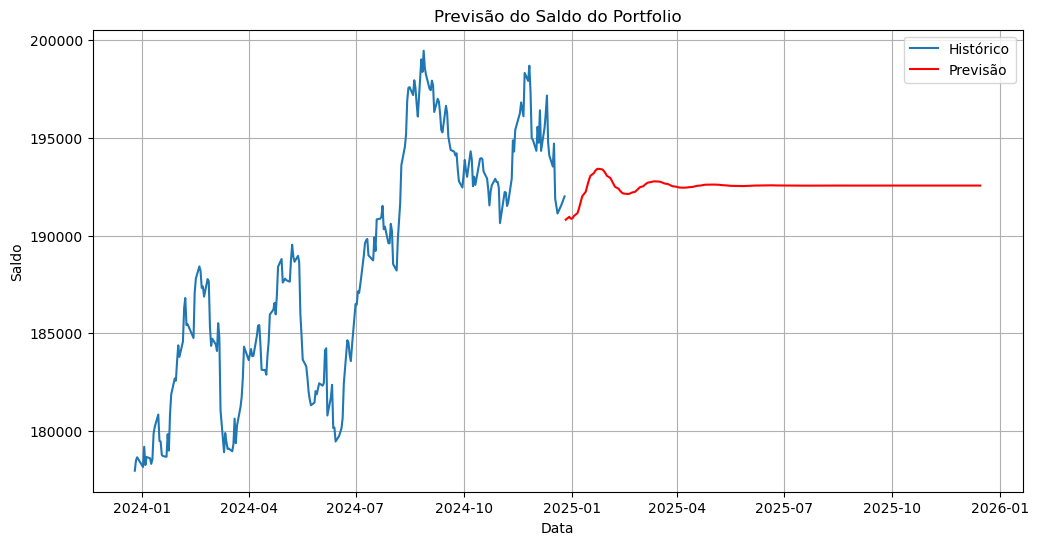

In [1778]:

# Plota o gráfico da previsão
plt.figure(figsize=(12, 6))
plt.plot(portfolio_balance_optimal.tail(best_window), label='Histórico')
plt.plot(df_forecast_optimal, label='Previsão', color='red')
plt.xlabel('Data')
plt.ylabel('Saldo')
plt.title('Previsão do Saldo do Portfolio')
plt.legend()
plt.grid(True)

# Encontra e plota os valores máximo e mínimo da previsão
#max_value = df_forecast['Saldo'].max()
#min_value = df_forecast['Saldo'].min()
#max_date = df_forecast['Saldo'].idxmax()
#min_date = df_forecast['Saldo'].idxmin()

#plt.scatter(max_date, max_value, color='green', label='Máximo', s=100)
#plt.scatter(min_date, min_value, color='red', label='Mínimo', s=100)

#plt.annotate(f'Máximo: {max_value:.2f}', (max_date, max_value), xytext=(10,10),
             #textcoords='offset points', arrowprops=dict(arrowstyle='->'))
#plt.annotate(f'Mínimo: {min_value:.2f}', (min_date, min_value), xytext=(-80,-20),
             #textcoords='offset points', arrowprops=dict(arrowstyle='->'))

#plt.fill_between(df_forecast.index, df_forecast['Saldo'], min_value, color='orange', alpha=0.3)

plt.legend()
plt.show()


# 7 - Comparação de Investimentos

## VaR , Backtesting e Stress Test

In [1779]:
###### VaR - Value at Risk ######

## Portfolio atual

print('Janelas do VaR para o Portfólio Escolhido')

# Mostrar todos os resultados armazenados em test_windows_results
print("\nResultados do VaR para diferentes janelas de tempo:")
for window, var in test_windows_results:
    print(f"Janela de {window} dias: VaR = R$ {var:.2f}")

# Encontrar o melhor valor de VaR (o menor, pois ele representa a perda máxima)
best_window, best_VaR = min(test_windows_results, key=lambda x: x[1])
print(f'\nMelhor janela de tempo: {best_window} dias com VaR = R$ {best_VaR:.2f}')

# Imprimir a taxa de violação observada
taxa_violacao = np.mean(violacoes)
print(f'Taxa de Violação Observada: {taxa_violacao:.4f}')
# Exibir o resultado do VaR em cenário de stress
print(f'VaR em cenário de stress (choque de {shock_factor*100}%): R$ {VaR_stress:.2f}\n')


print('--------------------------------------------------------------')

## Portfólio Otimizado

print('\nJanelas do VaR para o Portfólio Otimizado')

# Mostrar todos os resultados armazenados em test_windows_results
print("\nResultados do VaR para diferentes janelas de tempo:")
for window, var in test_windows_results_optimal:
    print(f"Janela de {window} dias: VaR = R$ {var:.2f}")
# Encontrar o melhor valor de VaR (o menor, pois ele representa a perda máxima)
best_window_optimal, best_VaR_optimal = min(test_windows_results_optimal, key=lambda x: x[1])
print(f'\nMelhor janela de tempo: {best_window_optimal} dias com VaR = R$ {best_VaR_optimal:.2f}')
# Imprimir a taxa de violação observada
taxa_violacao_port_optimized = np.mean(violacoes_port_optimized)
print(f'Taxa de Violação do Portfólio Ótimo Observada: {taxa_violacao_port_optimized:.4f}')
# Exibir o resultado do VaR em cenário de stress
print(f'VaR em cenário de stress (choque de {shock_factor*100}%): R$ {VaR_stress_optimal:.2f}\n\n')

Janelas do VaR para o Portfólio Escolhido

Resultados do VaR para diferentes janelas de tempo:
Janela de 30 dias: VaR = R$ 8564.20
Janela de 60 dias: VaR = R$ 9009.10
Janela de 90 dias: VaR = R$ 7769.46
Janela de 180 dias: VaR = R$ 846.81
Janela de 252 dias: VaR = R$ -540.24

Melhor janela de tempo: 252 dias com VaR = R$ -540.24
Taxa de Violação Observada: 0.9518
VaR em cenário de stress (choque de 50.0%): R$ -270.12

--------------------------------------------------------------

Janelas do VaR para o Portfólio Otimizado

Resultados do VaR para diferentes janelas de tempo:
Janela de 30 dias: VaR = R$ 8970.89
Janela de 60 dias: VaR = R$ 8310.51
Janela de 90 dias: VaR = R$ 8532.67
Janela de 180 dias: VaR = R$ -3562.10
Janela de 252 dias: VaR = R$ -11953.32

Melhor janela de tempo: 252 dias com VaR = R$ -11953.32
Taxa de Violação do Portfólio Ótimo Observada: 1.0000
VaR em cenário de stress (choque de 50.0%): R$ -5976.66




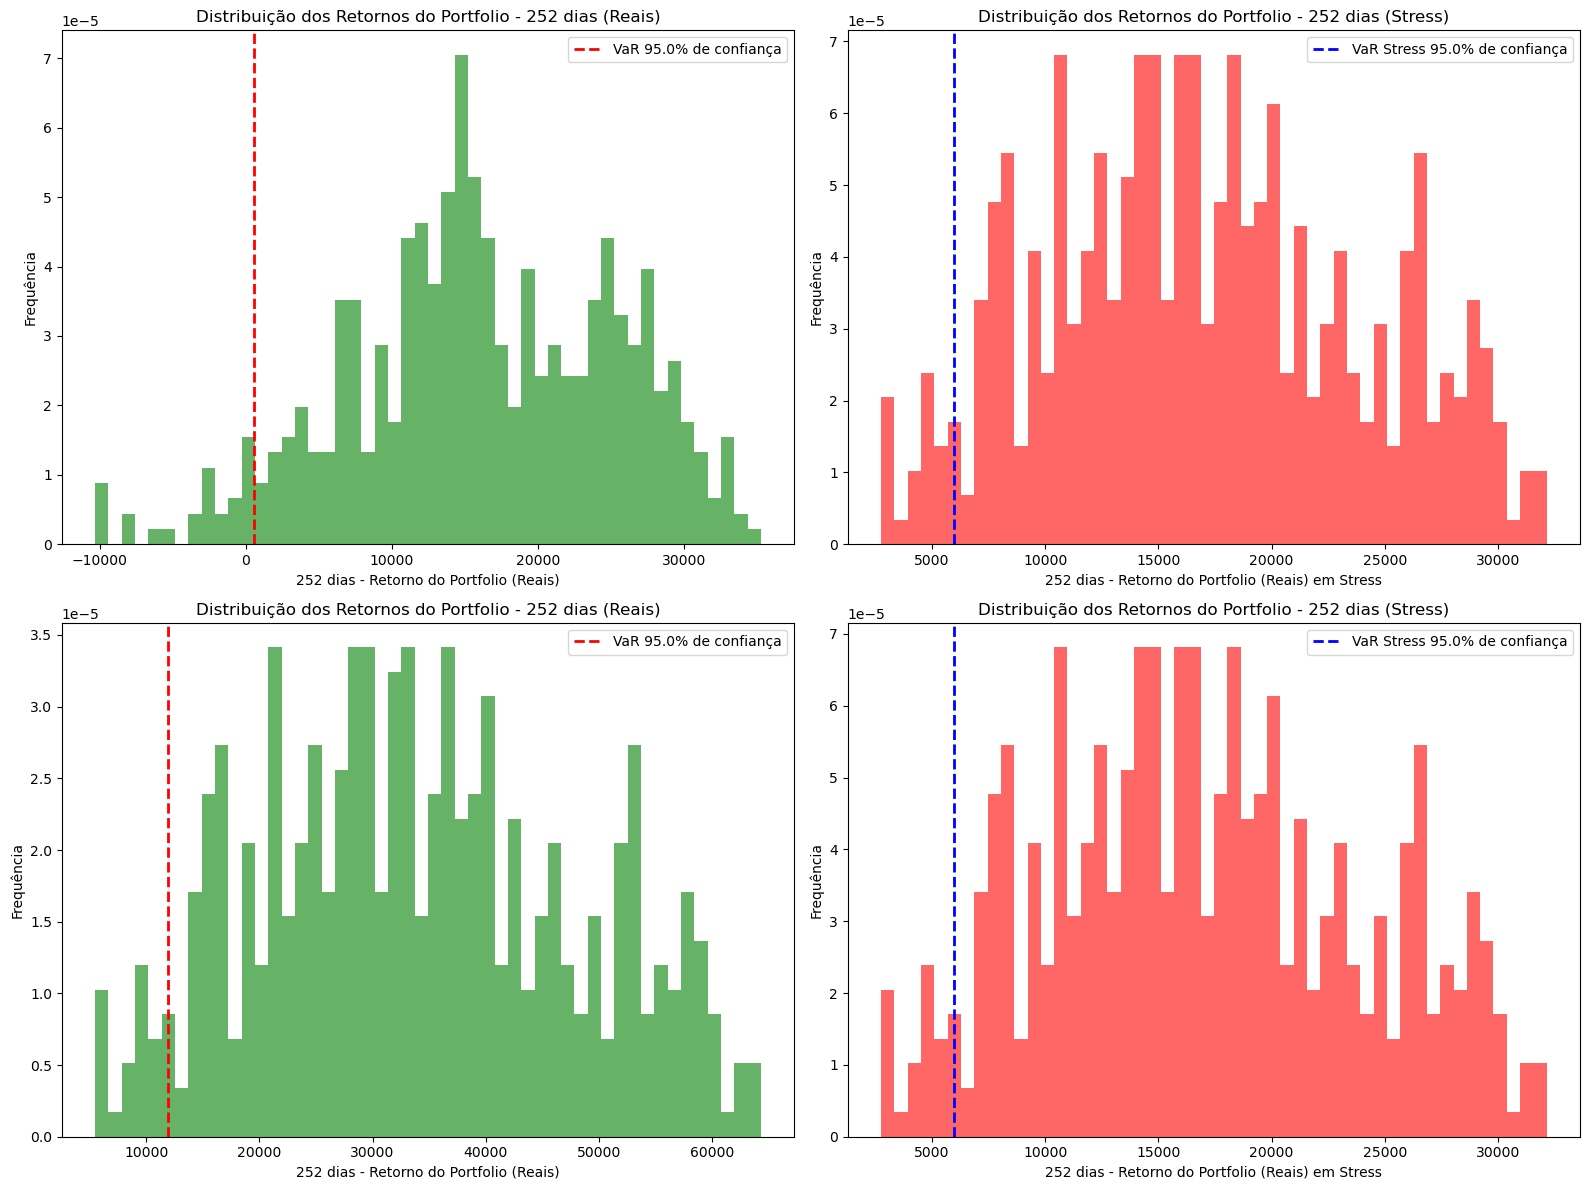

In [1780]:
# Configurar o layout 2x2
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Plotar o primeiro gráfico
range_returns_best = historical_returns.rolling(window=best_window).sum().dropna()
axs[0, 0].hist(range_returns_best * portfolio_value, bins=50, density=True, alpha=0.6, color='g')
axs[0, 0].axvline(-best_VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR {confidence_interval*100}% de confiança')
axs[0, 0].set_xlabel(f'{best_window} dias - Retorno do Portfolio (Reais)')
axs[0, 0].set_ylabel('Frequência')
axs[0, 0].set_title(f'Distribuição dos Retornos do Portfolio - {best_window} dias (Reais)')
axs[0, 0].legend()

# Plotar o segundo gráfico
axs[0, 1].hist(range_returns_stress_optimal * portfolio_value, bins=50, density=True, alpha=0.6, color='r')
axs[0, 1].axvline(-VaR_stress_optimal, color='b', linestyle='dashed', linewidth=2, label=f'VaR Stress {confidence_interval*100}% de confiança')
axs[0, 1].set_xlabel(f'{best_window_optimal} dias - Retorno do Portfolio (Reais) em Stress')
axs[0, 1].set_ylabel('Frequência')
axs[0, 1].set_title(f'Distribuição dos Retornos do Portfolio - {best_window_optimal} dias (Stress)')
axs[0, 1].legend()

# Plotar o terceiro gráfico
range_returns_best_optimized = historical_returns_optimized.rolling(window=best_window_optimal).sum().dropna()
axs[1, 0].hist(range_returns_best_optimized * portfolio_value, bins=50, density=True, alpha=0.6, color='g')
axs[1, 0].axvline(-best_VaR_optimal, color='r', linestyle='dashed', linewidth=2, label=f'VaR {confidence_interval*100}% de confiança')
axs[1, 0].set_xlabel(f'{best_window_optimal} dias - Retorno do Portfolio (Reais)')
axs[1, 0].set_ylabel('Frequência')
axs[1, 0].set_title(f'Distribuição dos Retornos do Portfolio - {best_window_optimal} dias (Reais)')
axs[1, 0].legend()

# Plotar o quarto gráfico
axs[1, 1].hist(range_returns_stress_optimal * portfolio_value, bins=50, density=True, alpha=0.6, color='r')
axs[1, 1].axvline(-VaR_stress_optimal, color='b', linestyle='dashed', linewidth=2, label=f'VaR Stress {confidence_interval*100}% de confiança')
axs[1, 1].set_xlabel(f'{best_window_optimal} dias - Retorno do Portfolio (Reais) em Stress')
axs[1, 1].set_ylabel('Frequência')
axs[1, 1].set_title(f'Distribuição dos Retornos do Portfolio - {best_window_optimal} dias (Stress)')
axs[1, 1].legend()

# Ajustar o layout para não sobrepor os gráficos
plt.tight_layout()
plt.show()

## Análise dos Retornos

In [1781]:

# Imprimir os resultados
print(f"Retornos do Portfolio Atual\n")

print(f"Saldo atual do Portfolio: R$ {saldo_atual_portfolio:.2f}")
print(f"Saldo atual do CDI: R$ {saldo_atual_cdi:.2f}")
print(f"Saldo atual do IBOV: R$ {saldo_atual_ibov:.2f}\n")
print(f"Diferença Portfolio vs. CDI: R$ {diferenca_cdi:.2f}")
print(f"Diferença Portfolio vs. IBOV: R$ {diferenca_ibov:.2f}\n")

print('--------------------------------------------------------------')

# Imprimir os resultados
print(f"Retornos do Portfolio Otimizado\n")

print(f"Saldo atual do Portfolio Otimizado: R$ {saldo_atual_portfolio_optimal:.2f}")
print(f"Saldo atual do CDI: R$ {saldo_atual_cdi:.2f}")
print(f"Saldo atual do IBOV: R$ {saldo_atual_ibov:.2f}\n")
print(f"Diferença Portfolio Otimizado vs. CDI: R$ {diferenca_cdi_optimal:.2f}")
print(f"Diferença Portfolio Otimizado vs. IBOV: R$ {diferenca_ibov_optimal:.2f}\n")

Retornos do Portfolio Atual

Saldo atual do Portfolio: R$ 140650.63
Saldo atual do CDI: R$ 134261.80
Saldo atual do IBOV: R$ 114376.66

Diferença Portfolio vs. CDI: R$ 6388.83
Diferença Portfolio vs. IBOV: R$ 26273.97

--------------------------------------------------------------
Retornos do Portfolio Otimizado

Saldo atual do Portfolio Otimizado: R$ 192006.19
Saldo atual do CDI: R$ 134261.80
Saldo atual do IBOV: R$ 114376.66

Diferença Portfolio Otimizado vs. CDI: R$ 57744.39
Diferença Portfolio Otimizado vs. IBOV: R$ 77629.54



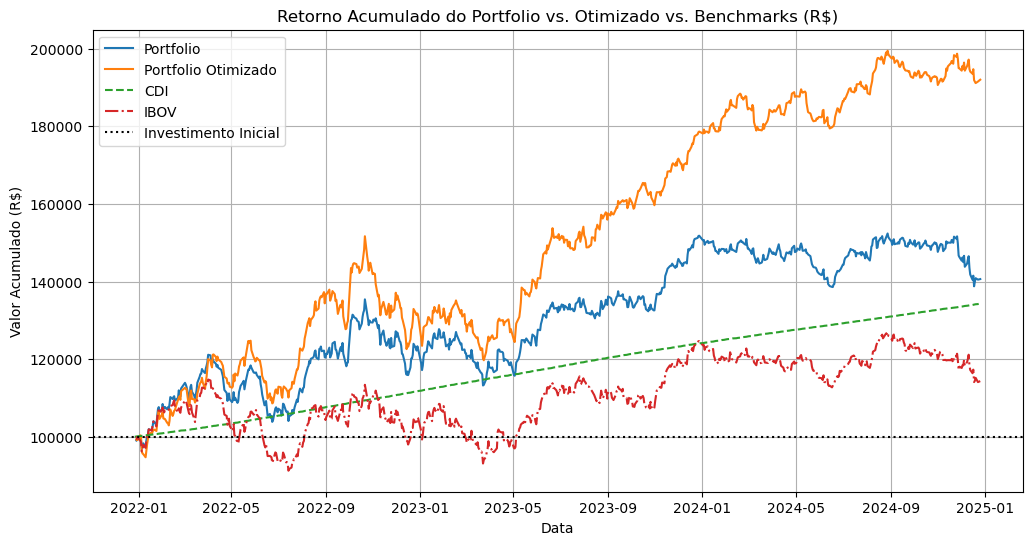

In [1782]:
# Plota os retornos acumulados
plt.figure(figsize=(12, 6))
plt.plot(historical_returns.index, portfolio_return, label='Portfolio')
plt.plot(historical_returns_optimized.index, portfolio_return_optimized, label='Portfolio Otimizado')
plt.plot(cdi.index, cdi_return, label='CDI', linestyle='--')
plt.plot(log_ibov.index, ibov_return, label='IBOV', linestyle='-.')
plt.axhline(portfolio_value, color='k', linestyle=':', label='Investimento Inicial')
plt.title('Retorno Acumulado do Portfolio vs. Otimizado vs. Benchmarks (R$)')
plt.xlabel('Data')
plt.ylabel('Valor Acumulado (R$)')
plt.legend()
plt.grid(True)
plt.show()





## CAPM 

In [1783]:
##### CAPM  #####

## Portfolio atual

# Imprime os resultados
print(f"Análise CAPM do Portfolio Atual\n")
print(f"Beta do Portfolio: {beta_portfolio:.4f}")
print(f"Retorno Esperado (CAPM): {expected_return_capm:.4f}")
print(f"Alfa do Portfolio: {alpha_portfolio:.4f}")

# Imprime os resultados adicionais
print(f"Erro de Previsão do CAPM: {capm_prediction_error:.4f}")
print(f"R-quadrado do Modelo CAPM: {r_squared:.4f}")

# Interpretação dos resultados
print("\nInterpretação dos Resultados:")
print(f"- Beta do Portfolio ({beta_portfolio:.4f}): Indica que o portfolio é {beta_portfolio:.2f} vezes mais volátil que o IBOV.")
if alpha_portfolio > 0:
    print(f"- Alfa do Portfolio ({alpha_portfolio:.4f}): Positivo, indicando que o portfolio gerou retornos acima do esperado pelo CAPM, sugerindo uma possível habilidade do gestor.")
elif alpha_portfolio < 0:
    print(f"- Alfa do Portfolio ({alpha_portfolio:.4f}): Negativo, indicando que o portfolio gerou retornos abaixo do esperado pelo CAPM.")
else:
    print(f"- Alfa do Portfolio ({alpha_portfolio:.4f}): Zero, indicando que o portfolio gerou retornos em linha com o esperado pelo CAPM.")
print(f"- R-quadrado do Modelo CAPM ({r_squared:.4f}): Indica que {r_squared*100:.2f}% da variância do retorno do portfolio é explicada pelo IBOV.")

print('--------------------------------------------------------------')

## Portfólio Otimizado


# Imprime os resultados
print(f"Análise CAPM do Portfolio Otimizado\n")

print(f"Beta do Portfolio: {beta_portfolio_optimal:.4f}")
print(f"Retorno Esperado (CAPM): {expected_return_capm_optimal:.4f}")
print(f"Alfa do Portfolio: {alpha_portfolio_optimal:.4f}")

# Imprime os resultados adicionais
print(f"Erro de Previsão do CAPM: {capm_prediction_error_optimal:.4f}")
print(f"R-quadrado do Modelo CAPM: {r_squared_capm_optimal:.4f}")

# Interpretação dos resultados
print("\nInterpretação dos Resultados:")
print(f"- Beta do Portfolio ({beta_portfolio_optimal:.4f}): Indica que o portfolio ótimo é {beta_portfolio_optimal:.2f} vezes mais volátil que o IBOV.")
if alpha_portfolio > 0:
    print(f"- Alfa do Portfolio Ótimo ({alpha_portfolio_optimal:.4f}): Positivo, indicando que o portfolio ótimo gerou retornos acima do esperado pelo CAPM, sugerindo uma possível habilidade do gestor.")
elif alpha_portfolio < 0:
    print(f"- Alfa do Portfolio Ótimo ({alpha_portfolio_optimal:.4f}): Negativo, indicando que o portfolio ótimo gerou retornos abaixo do esperado pelo CAPM.")
else:
    print(f"- Alfa do Portfolio Ótimo ({alpha_portfolio_optimal:.4f}): Zero, indicando que o portfolio ótimo gerou retornos em linha com o esperado pelo CAPM.")
print(f"- R-quadrado do Modelo CAPM ({r_squared_capm_optimal:.4f}): Indica que {r_squared_capm_optimal*100:.2f}% da variância do retorno do portfolio ótimo é explicada pelo IBOV.")

Análise CAPM do Portfolio Atual

Beta do Portfolio: 1.0140
Retorno Esperado (CAPM): 0.0490
Alfa do Portfolio: 0.0877
Erro de Previsão do CAPM: 0.0877
R-quadrado do Modelo CAPM: 0.8421

Interpretação dos Resultados:
- Beta do Portfolio (1.0140): Indica que o portfolio é 1.01 vezes mais volátil que o IBOV.
- Alfa do Portfolio (0.0877): Positivo, indicando que o portfolio gerou retornos acima do esperado pelo CAPM, sugerindo uma possível habilidade do gestor.
- R-quadrado do Modelo CAPM (0.8421): Indica que 84.21% da variância do retorno do portfolio é explicada pelo IBOV.
--------------------------------------------------------------
Análise CAPM do Portfolio Otimizado

Beta do Portfolio: 0.9525
Retorno Esperado (CAPM): 0.0461
Alfa do Portfolio: 0.2635
Erro de Previsão do CAPM: 0.2635
R-quadrado do Modelo CAPM: 0.5661

Interpretação dos Resultados:
- Beta do Portfolio (0.9525): Indica que o portfolio ótimo é 0.95 vezes mais volátil que o IBOV.
- Alfa do Portfolio Ótimo (0.2635): Positivo

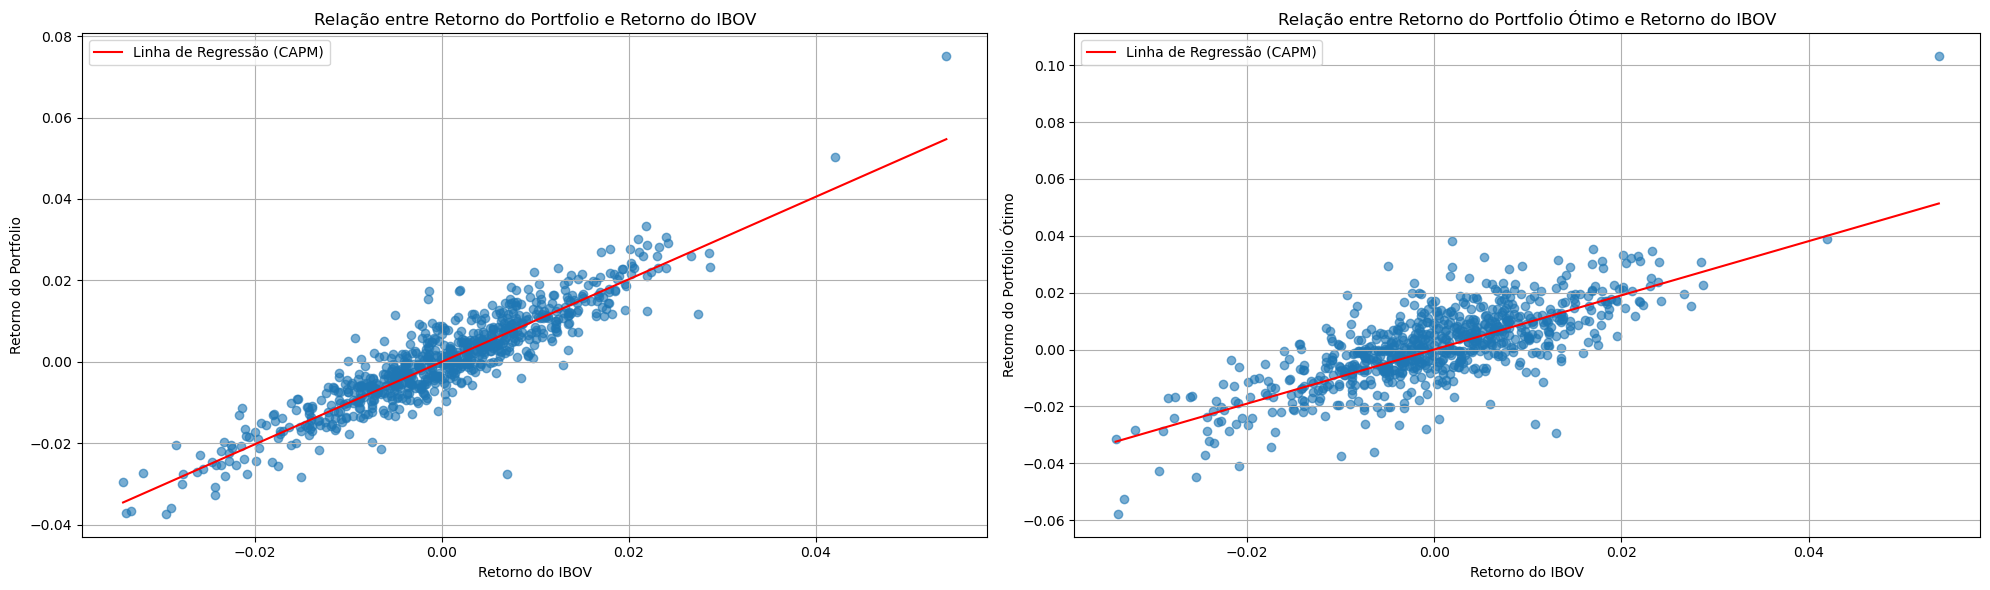

In [1784]:


# Configurar o layout 1x2 para colocar os gráficos lado a lado
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Primeiro gráfico: Relação entre Retorno do Portfolio e Retorno do IBOV
axs[0].scatter(log_ibov['IBOV'], historical_returns, alpha=0.6)
axs[0].set_xlabel('Retorno do IBOV')
axs[0].set_ylabel('Retorno do Portfolio')
axs[0].set_title('Relação entre Retorno do Portfolio e Retorno do IBOV')

# Adicionar a linha de regressão (CAPM)
x = np.linspace(log_ibov['IBOV'].min(), log_ibov['IBOV'].max(), 100)
y = risk_free_rate + beta_portfolio * (x - risk_free_rate)
axs[0].plot(x, y, color='red', label='Linha de Regressão (CAPM)')

axs[0].legend()
axs[0].grid(True)

# Segundo gráfico: Relação entre Retorno do Portfolio Ótimo e Retorno do IBOV
axs[1].scatter(log_ibov['IBOV'], historical_returns_optimized, alpha=0.6)
axs[1].set_xlabel('Retorno do IBOV')
axs[1].set_ylabel('Retorno do Portfolio Ótimo')
axs[1].set_title('Relação entre Retorno do Portfolio Ótimo e Retorno do IBOV')

# Adicionar a linha de regressão (CAPM)
y = risk_free_rate + beta_portfolio_optimal * (x - risk_free_rate)
axs[1].plot(x, y, color='red', label='Linha de Regressão (CAPM)')

axs[1].legend()
axs[1].grid(True)

# Ajustar o layout para não sobrepor os gráficos
plt.tight_layout()
plt.show()


## Regresão Linear

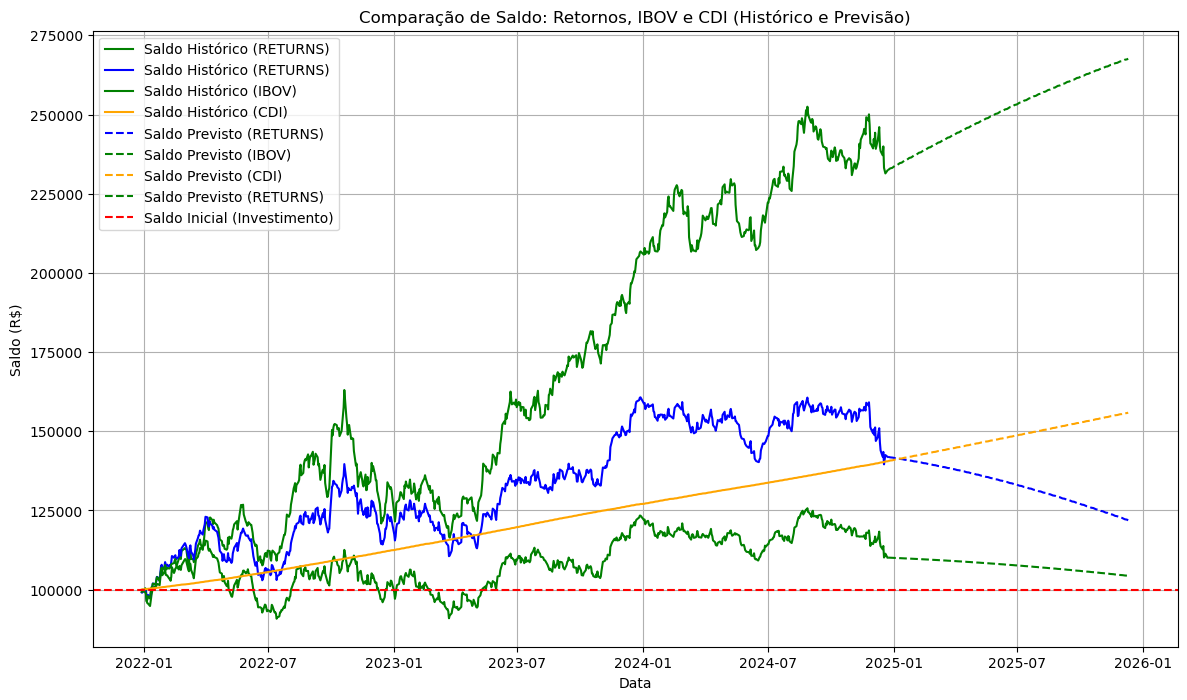


Métricas para RETURNS ótima:
  - MSE: 0.000192
  - MAE: 0.010315
  - R²: 0.000437

Métricas para RETURNS:
  - MSE: 0.000146
  - MAE: 0.009270
  - R²: 0.001720

Métricas para IBOV:
  - MSE: 0.000120
  - MAE: 0.008454
  - R²: 0.000258

Métricas para CDI:
  - MSE: 0.000000
  - MAE: 0.000038
  - R²: 0.147756


In [1785]:
# Plotando os resultados
plt.figure(figsize=(14, 8))

# Histórico
for coluna, cor in zip(['returns'], [ 'green']):
    plt.plot(df_modelagem_otima.index, saldos_optimal['historico'][coluna], label=f'Saldo Histórico ({coluna.upper()})', color=cor)

# Histórico
for coluna, cor in zip(['returns', 'IBOV', 'cdi'], ['blue', 'green', 'orange']):
    plt.plot(df_modelagem.index, saldos['historico'][coluna], label=f'Saldo Histórico ({coluna.upper()})', color=cor)

# Futuro
for coluna, cor in zip(['returns', 'IBOV', 'cdi'], ['blue', 'green', 'orange']):
    plt.plot(resultados[coluna]['datas_futuras'], saldos['futuro'][coluna], linestyle='--', label=f'Saldo Previsto ({coluna.upper()})', color=cor)

# Futuro
for coluna, cor in zip(['returns'], ['green']):
    plt.plot(resultados[coluna]['datas_futuras'], saldos_optimal['futuro'][coluna], linestyle='--', label=f'Saldo Previsto ({coluna.upper()})', color=cor)

# Linha do investimento inicial
plt.axhline(y=valor_investido, color='red', linestyle='--', label='Saldo Inicial (Investimento)')

# Configurações do gráfico
plt.xlabel('Data')
plt.ylabel('Saldo (R$)')
plt.title('Comparação de Saldo: Retornos, IBOV e CDI (Histórico e Previsão)')
plt.legend()
plt.grid(True)
plt.show()

# Métricas da regressão otima
for coluna in ['returns']:
    print(f"\nMétricas para {coluna.upper()} ótima:")
    print(f"  - MSE: {resultados_optimal[coluna]['mse']:.6f}")
    print(f"  - MAE: {resultados_optimal[coluna]['mae']:.6f}")
    print(f"  - R²: {resultados_optimal[coluna]['r2']:.6f}")

# Métricas da regressão
for coluna in ['returns', 'IBOV', 'cdi']:
    print(f"\nMétricas para {coluna.upper()}:")
    print(f"  - MSE: {resultados[coluna]['mse']:.6f}")
    print(f"  - MAE: {resultados[coluna]['mae']:.6f}")
    print(f"  - R²: {resultados[coluna]['r2']:.6f}")

## ARIMA

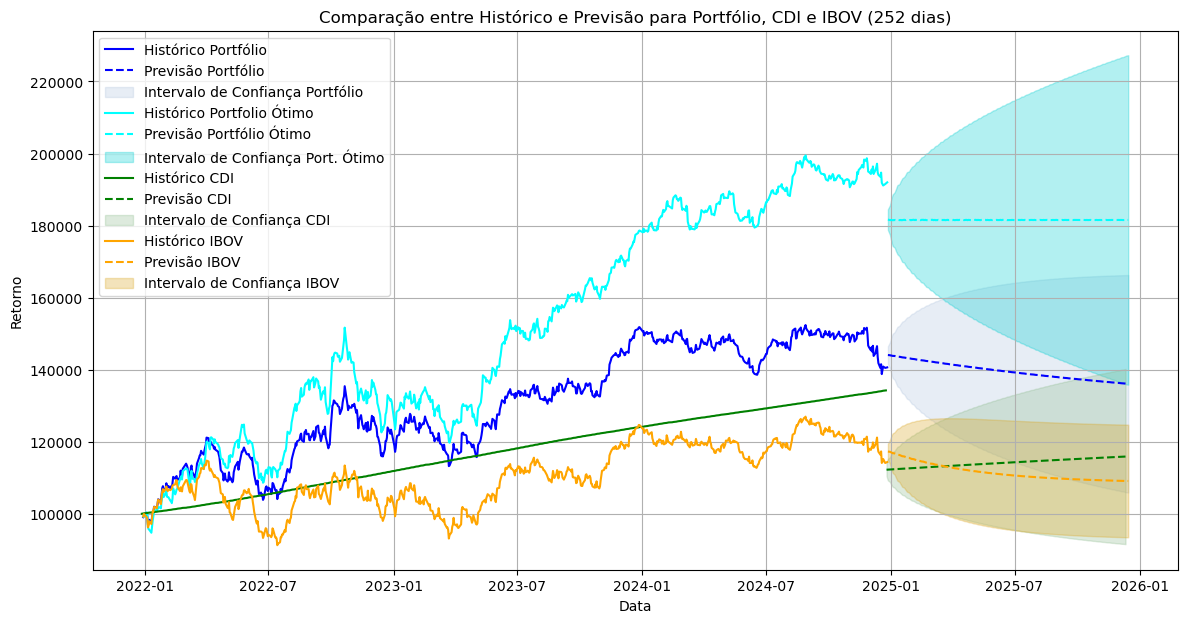

In [1786]:
plt.figure(figsize=(14, 7))

plt.plot(portfolio_return.index, portfolio_return, label='Histórico Portfólio', color='blue')
plt.plot(forecast_index, forecast_mean, label='Previsão Portfólio', color='blue', linestyle='--')
plt.fill_between(forecast_index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='lightsteelblue', alpha=0.3, label='Intervalo de Confiança Portfólio')

plt.plot(portfolio_return_optimized.index, portfolio_return_optimized, label='Histórico Portfolio Ótimo', color='cyan')
plt.plot(forecast_index, forecast_mean_optimal, label='Previsão Portfólio Ótimo', color='aqua',  linestyle='--')
plt.fill_between(forecast_index, forecast_conf_int_optimal.iloc[:, 0], forecast_conf_int_optimal.iloc[:, 1], color='darkturquoise', alpha=0.3, label='Intervalo de Confiança Port. Ótimo')

plt.plot(cdi_return.index, cdi_return, label='Histórico CDI', color='green')
plt.plot(forecast_index_cdi, forecast_mean_cdi, label='Previsão CDI', color='green',  linestyle='--')
plt.fill_between(forecast_index_cdi, forecast_conf_int_cdi.iloc[:, 0], forecast_conf_int_cdi.iloc[:, 1], color='darkseagreen', alpha=0.3, label='Intervalo de Confiança CDI')

plt.plot(ibov_return.index, ibov_return, label='Histórico IBOV', color='orange')
plt.plot(forecast_index_ibov, forecast_mean_ibov, label='Previsão IBOV', color='orange',  linestyle='--')
plt.fill_between(forecast_index_ibov, forecast_conf_int_ibov.iloc[:, 0], forecast_conf_int_ibov.iloc[:, 1], color='goldenrod', alpha=0.3, label='Intervalo de Confiança IBOV')

plt.xlabel('Data')
plt.ylabel('Retorno')
plt.title(f'Comparação entre Histórico e Previsão para Portfólio, CDI e IBOV ({best_window} dias)')
plt.legend()
plt.grid(True)
plt.show()

## LSTM

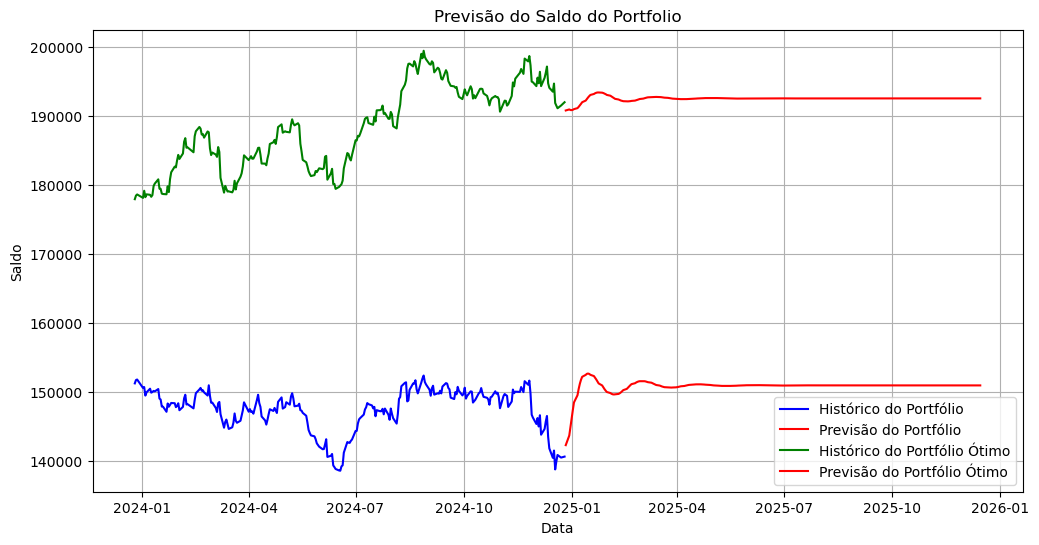

In [1787]:
# Plota o gráfico da previsão
plt.figure(figsize=(12, 6))
plt.plot(portfolio_balance.tail(best_window), label='Histórico do Portfólio', color='blue')
plt.plot(df_forecast, label='Previsão do Portfólio', color='red')
plt.plot(portfolio_balance_optimal.tail(best_window), label='Histórico do Portfólio Ótimo', color='green')
plt.plot(df_forecast_optimal, label='Previsão do Portfólio Ótimo', color='red')
plt.xlabel('Data')
plt.ylabel('Saldo')
plt.title('Previsão do Saldo do Portfolio')
plt.legend()
plt.grid(True)
plt.legend()
plt.show()


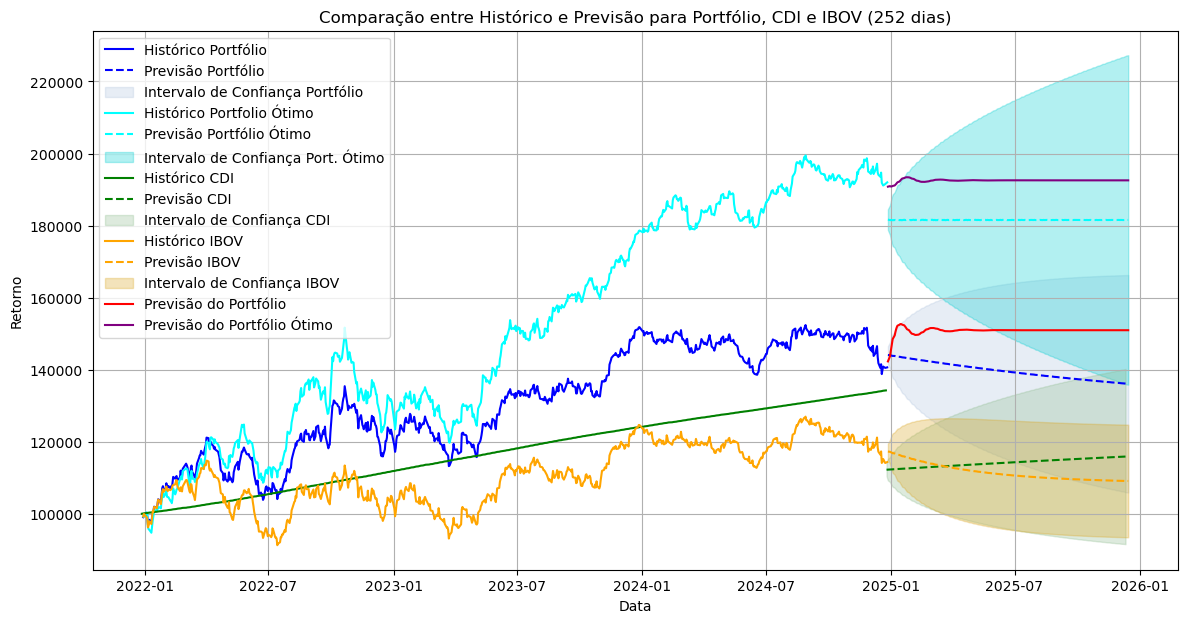

In [1788]:
plt.figure(figsize=(14, 7))

plt.plot(portfolio_return.index, portfolio_return, label='Histórico Portfólio', color='blue')
plt.plot(forecast_index, forecast_mean, label='Previsão Portfólio', color='blue', linestyle='--')
plt.fill_between(forecast_index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='lightsteelblue', alpha=0.3, label='Intervalo de Confiança Portfólio')

plt.plot(portfolio_return_optimized.index, portfolio_return_optimized, label='Histórico Portfolio Ótimo', color='cyan')
plt.plot(forecast_index, forecast_mean_optimal, label='Previsão Portfólio Ótimo', color='aqua',  linestyle='--')
plt.fill_between(forecast_index, forecast_conf_int_optimal.iloc[:, 0], forecast_conf_int_optimal.iloc[:, 1], color='darkturquoise', alpha=0.3, label='Intervalo de Confiança Port. Ótimo')

plt.plot(cdi_return.index, cdi_return, label='Histórico CDI', color='green')
plt.plot(forecast_index_cdi, forecast_mean_cdi, label='Previsão CDI', color='green',  linestyle='--')
plt.fill_between(forecast_index_cdi, forecast_conf_int_cdi.iloc[:, 0], forecast_conf_int_cdi.iloc[:, 1], color='darkseagreen', alpha=0.3, label='Intervalo de Confiança CDI')

plt.plot(ibov_return.index, ibov_return, label='Histórico IBOV', color='orange')
plt.plot(forecast_index_ibov, forecast_mean_ibov, label='Previsão IBOV', color='orange',  linestyle='--')
plt.fill_between(forecast_index_ibov, forecast_conf_int_ibov.iloc[:, 0], forecast_conf_int_ibov.iloc[:, 1], color='goldenrod', alpha=0.3, label='Intervalo de Confiança IBOV')

plt.plot(df_forecast, label='Previsão do Portfólio', color='red')
plt.plot(df_forecast_optimal, label='Previsão do Portfólio Ótimo', color='purple')

plt.xlabel('Data')
plt.ylabel('Retorno')
plt.title(f'Comparação entre Histórico e Previsão para Portfólio, CDI e IBOV ({best_window} dias)')
plt.legend()
plt.grid(True)
plt.show()

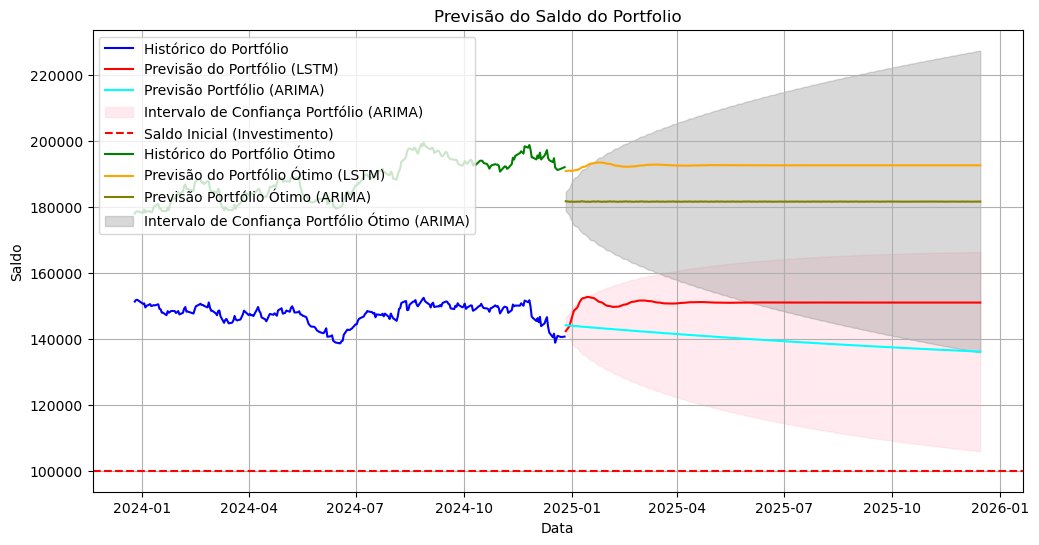

In [1789]:


# Plota o gráfico da previsão
plt.figure(figsize=(12, 6))
plt.plot(portfolio_balance.tail(252), label='Histórico do Portfólio', color='blue')
plt.plot(df_forecast, label='Previsão do Portfólio (LSTM)', color='red')
plt.plot(forecast_index, forecast_mean, label='Previsão Portfólio (ARIMA)', color='cyan')
plt.fill_between(forecast_index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Intervalo de Confiança Portfólio (ARIMA)')

# Linha do investimento inicial
plt.axhline(y=valor_investido, color='red', linestyle='--', label='Saldo Inicial (Investimento)')

plt.plot(portfolio_balance_optimal.tail(252), label='Histórico do Portfólio Ótimo', color='green')
plt.plot(df_forecast_optimal, label='Previsão do Portfólio Ótimo (LSTM)', color='orange')
plt.plot(forecast_index, forecast_mean_optimal, label='Previsão Portfólio Ótimo (ARIMA)', color='olive')
plt.fill_between(forecast_index, forecast_conf_int_optimal.iloc[:, 0], forecast_conf_int_optimal.iloc[:, 1], color='gray', alpha=0.3, label='Intervalo de Confiança Portfólio Ótimo (ARIMA)')
plt.xlabel('Data')
plt.xlabel('Data')
plt.ylabel('Saldo')
plt.title('Previsão do Saldo do Portfolio')
plt.legend()
plt.grid(True)
plt.legend()
plt.show()

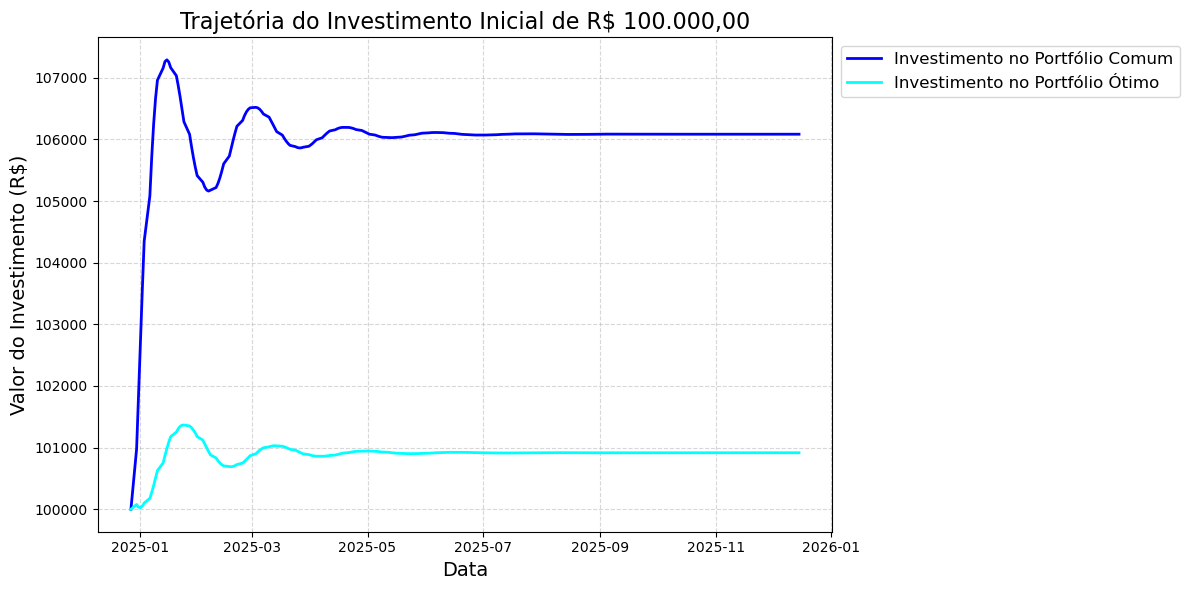

In [1790]:
# Definindo o valor inicial do investimento
initial_investment = 100000

# Cálculo dos retornos previstos para os dois portfólios (comum e ótimo)
# Vamos assumir que df_forecast e df_forecast_optimal possuem os retornos diários previstos

# Calculando o retorno diário previsto e acumulado para o portfólio comum
portfolio_returns = df_forecast.pct_change().fillna(0) + 1  # Retornos previstos do portfólio
portfolio_optimal_returns = df_forecast_optimal.pct_change().fillna(0) + 1  # Retornos previstos do portfólio ótimo

# Calculando a evolução do valor do investimento ao longo do tempo
portfolio_value = initial_investment * portfolio_returns.cumprod()  # Valor do portfólio comum
portfolio_optimal_value = initial_investment * portfolio_optimal_returns.cumprod()  # Valor do portfólio ótimo

# Plotando o gráfico com as trajetórias de investimento
plt.figure(figsize=(12, 6))

# Trajetória de investimento para o portfólio comum
plt.plot(portfolio_value, label='Investimento no Portfólio Comum', color='blue', linewidth=2)

# Trajetória de investimento para o portfólio ótimo
plt.plot(portfolio_optimal_value, label='Investimento no Portfólio Ótimo', color='cyan', linewidth=2)

# Adicionando rótulos e título
plt.xlabel('Data', fontsize=14)
plt.ylabel('Valor do Investimento (R$)', fontsize=14)
plt.title('Trajetória do Investimento Inicial de R$ 100.000,00', fontsize=16)

# Legenda
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)

# Grid
plt.grid(True, linestyle='--', alpha=0.5)

# Ajustando layout
plt.tight_layout()

# Mostrar o gráfico
plt.show()


# 8 - Conclusão

Este trabalho visa oferecer uma ferramenta prática e eficiente para investidores, utilizando técnicas de Machine Learning para analisar e comparar diferentes opções de investimento. Através da previsão de retornos e análise de risco, espera-se proporcionar insights valiosos que auxiliem na tomada de decisões financeiras mais informadas e estratégicas.